## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
# Visualizations will be shown in the notebook.
%matplotlib inline
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname) 
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imwrite('output_images/drawChessboardCorners/' + fname.split('/')[-1], img)

# Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Distortion correction

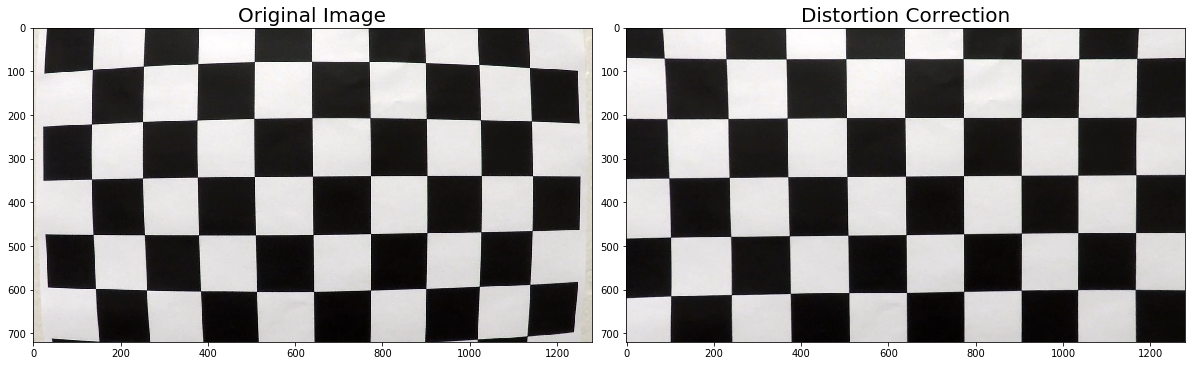

In [2]:
def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Test Undistorting image
image = mpimg.imread('camera_cal/calibration1.jpg') 
undistort_image = cal_undistort(image)

# Plot in notebook
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(undistort_image)
ax2.set_title('Distortion Correction', fontsize=20)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)

# Save to local disk
plt.savefig('output_images/distortion_correction.png')

## Color and Gradient threshold

### Combining Thresholds

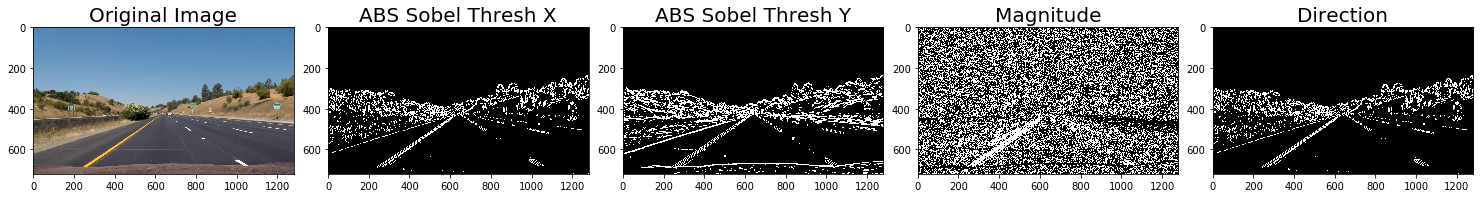

In [3]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):

    sobel = None
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return grad_binary

def mag_threshold(image, sobel_kernel=3, thresh=(0, 255)):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return dir_binary

# Test Combining Thresholds
image = mpimg.imread('test_images/straight_lines1.jpg') 
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_threshold(image, sobel_kernel=ksize, thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Plot in notebook
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(gradx, cmap='gray')
ax2.set_title('ABS Sobel Thresh X', fontsize=20)

ax3.imshow(grady, cmap='gray')
ax3.set_title('ABS Sobel Thresh Y', fontsize=20)

ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('Magnitude', fontsize=20)

ax5.imshow(gradx, cmap='gray')
ax5.set_title('Direction', fontsize=20)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)

# Save to local disk
plt.savefig('output_images/combining_thresholds.png')

### HLS space

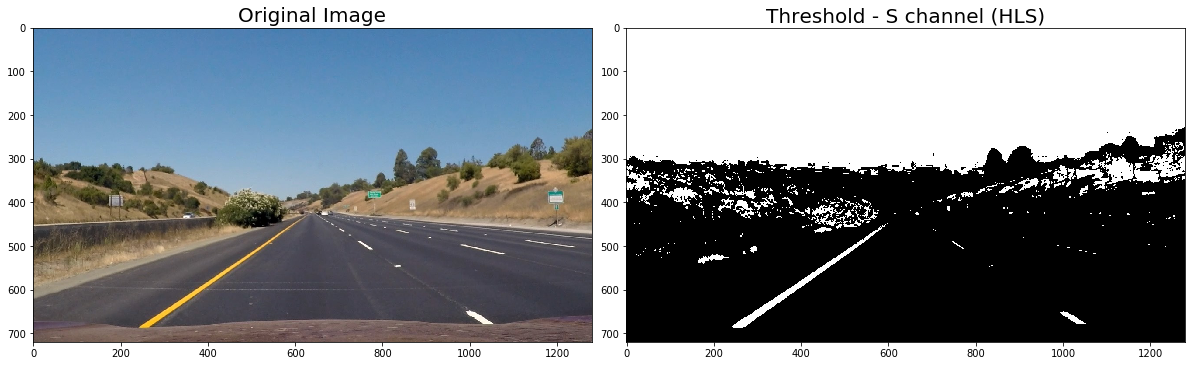

In [4]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result

    return binary_output

# Test HLS select
image = mpimg.imread('test_images/straight_lines1.jpg') 
hls_image = hls_select(image, thresh=(90, 255))

# Plot in notebook
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(hls_image, cmap='gray')
ax2.set_title('Threshold - S channel (HLS)', fontsize=20)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)

# Save to local disk
plt.savefig('output_images/thresholds_s_channel.png')

### Pipeline Threshold

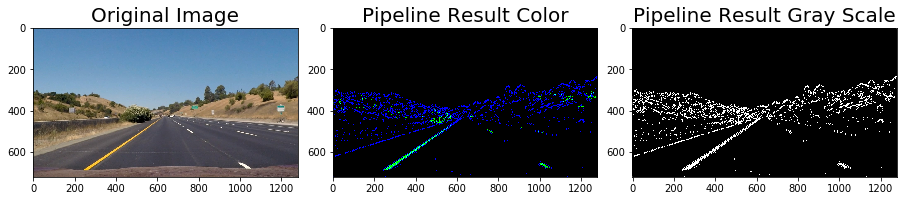

In [5]:
def pipeline_threshold(img, kernel_size=15, gradxy_thresh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3), s_thresh=(170, 255)):
    img = np.copy(img)

    # Threshold x gradient
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=kernel_size, thresh=gradxy_thresh)

    # Threshold y gradient
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=kernel_size, thresh=gradxy_thresh)

    # Magnitude
    mag_binary = mag_threshold(img, sobel_kernel=kernel_size, thresh=mag_thresh)

    # Direction
    dir_binary = dir_threshold(image, sobel_kernel=kernel_size, thresh=dir_thresh)

    # Threshold gray combine
    gray_combined = np.zeros_like(dir_binary)
    gray_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Threshold color channel
    s_binary = hls_select(img, thresh=s_thresh)

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(s_binary), s_binary, gray_combined))
    
    # Threshold combine
    combined = np.zeros_like(dir_binary)
    combined[((s_binary == 1) | (gray_combined == 1))] = 1

    return color_binary, combined

# Test Pipeline
image = mpimg.imread('test_images/straight_lines1.jpg')
color_result, gray_result = pipeline_threshold(image)

# Plot in notebook
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(color_result)
ax2.set_title('Pipeline Result Color', fontsize=20)

ax3.imshow(gray_result, cmap='gray')
ax3.set_title('Pipeline Result Gray Scale', fontsize=20)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)

# Save to local disk
plt.savefig('output_images/pipeline_threshold.png')

## Perspective transform

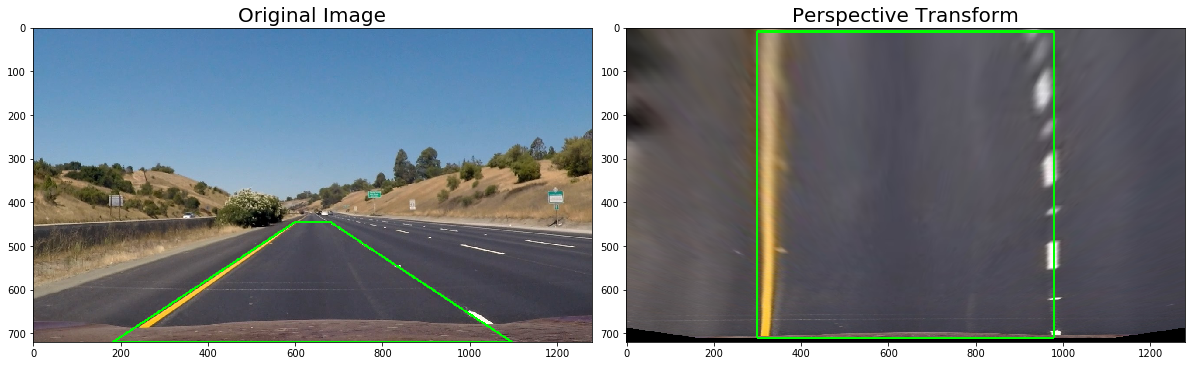

In [6]:
def get_points(img):
    img_width = img.shape[1]
    img_height = img.shape[0]

    src_point1 = (int(img_width/7), img_height)
    src_point2 = (int(img_width/2)-40, int(img_height/2)+85)
    src_point3 = (int(img_width/2)+40, int(img_height/2)+85)
    src_point4 = (int(img_width/7*6), img_height)
    src = np.float32([src_point1, src_point2, src_point3, src_point4])

    calipX = 300
    calipY = 10
    dst_point1 = (calipX, img_height-calipY)
    dst_point2 = (calipX, calipY)
    dst_point3 = (img_width-calipX, calipY)
    dst_point4 = (img_width-calipX, img_height-calipY)
    dst = np.float32([dst_point1, dst_point2, dst_point3, dst_point4])

    return src, dst

def warped_process(img):
    img_size = (img.shape[1], img.shape[0])

    # 1) Undistort
    img = cal_undistort(img)
    # 2) Get source points and dest. points
    src, dst = get_points(img)
    # 3) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # 4) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

# Test Perspective Transform
image = mpimg.imread('test_images/straight_lines1.jpg')
top_down, M, Minv = warped_process(image)

# Draw source points and dest. points in to images
src, dst = get_points(image)

pts_src = np.array(src, np.int32)
cv2.polylines(image, [pts_src], True, (0,255,0), 4)

pts_dst = np.array(dst, np.int32)
cv2.polylines(top_down, [pts_dst], True, (0,255,0), 4)

# Plot in notebook
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(top_down)
ax2.set_title('Perspective Transform', fontsize=20)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)

# Save to local disk
plt.savefig('output_images/perspective_transform.png')

## Sliding Window Search

In [7]:
# Draw window areas
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

# Find all window centroids
def find_window_centroids(image, window_width=50, window_height=80, margin=100):

    img_width = image.shape[1]
    img_height = image.shape[0]

    # Store the (left,right) window centroid positions per level
    window_centroids = []
    # Create our window template that we will use for convolutions
    window = np.ones(window_width)

    # First find the two starting positions for the left and right lane by using np.sum
    # to get the vertical image slice and then np.convolve the vertical image slice 
    # with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*img_height/4):, :int(img_width/2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
    r_sum = np.sum(image[int(3*img_height/4):, int(img_width/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum)) - window_width/2 + int(img_width/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1, int(img_height/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(img_height-(level+1)*window_height):
                                    int(img_height-level*window_height),
                                    :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is 
        # at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center + offset - margin, 0))
        l_max_index = int(min(l_center + offset + margin, img_width))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center + offset - margin, 0))
        r_max_index = int(min(r_center + offset + margin, img_width))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids

# Draw all window centroids
def draw_window_results(image, window_centroids, window_width=50, window_height=80):

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows
        for level in range(0, len(window_centroids)):
            l_mask = window_mask(window_width,
                                    window_height,
                                    image,
                                    window_centroids[level][0],
                                    level)
            r_mask = window_mask(window_width,
                                    window_height,
                                    image,
                                    window_centroids[level][1],
                                    level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        #template = np.array(r_points + l_points, np.uint8)
        r_template = np.array(r_points, np.uint8)
        l_template = np.array(l_points, np.uint8)

        # create a zero color channel
        zero_channel = np.zeros_like(r_template)
        # make window pixels green
        r_template = np.array(cv2.merge((zero_channel, r_template, zero_channel)),np.uint8)
        l_template = np.array(cv2.merge((zero_channel, zero_channel, l_template)),np.uint8)

        # making the original road pixels 3 color channels
        warpage = np.array(cv2.merge((image, image, image)),np.uint8)

        # overlay the orignal road image with window results
        template = cv2.addWeighted(r_template, 1, l_template, 1, 0.0)
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((image, image, image)),np.uint8)

    # Display the final results
    plt.figure()
    plt.imshow(output)
    plt.title('window fitting results')

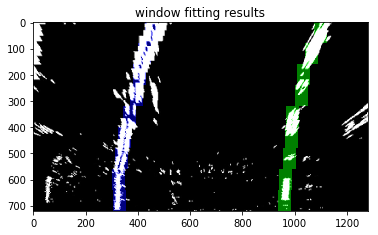

In [8]:
# Test Sliding Window Search
warped = cv2.imread('output_images/test_warped_example.jpg', cv2.IMREAD_GRAYSCALE)
window_centroids = find_window_centroids(warped)
draw_window_results(warped, window_centroids)

# Save to local disk
plt.savefig('output_images/window_fitting.png')

## Measuring Curvature

In [9]:
def measuring_curvature(linex, ploty, y_eval, xm_per_pix=30/720, ym_per_pix=3.7/700):
    # Fit new polynomials to x,y in world space    
    line_fit_cr = np.polyfit(ploty*ym_per_pix, linex*xm_per_pix, 2) # f(y)=Ay**2 + By + C
    y_eval_cr = y_eval*ym_per_pix

    line_curverad = ((1 + (2*line_fit_cr[0]*y_eval_cr + line_fit_cr[1])**2)**1.5) / np.absolute(2*line_fit_cr[0])
    return line_curverad

### Test Measuring Curvature

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_fake_data(y_range=720, x_base=200, y_base=900, line_width=100):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, y_range-1, num=y_range)# to cover same y-range as image

    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([x_base + (y**2)*quadratic_coeff + np.random.randint(-line_width/2, high=51) 
                                  for y in ploty])
    rightx = np.array([y_base + (y**2)*quadratic_coeff + np.random.randint(-line_width/2, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    return leftx, rightx, ploty

leftx, rightx, ploty = generate_fake_data()

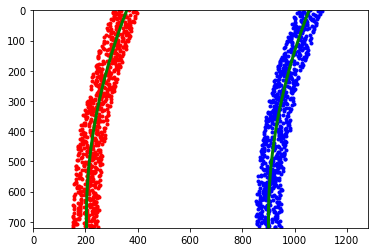

In [11]:
# Test fake data
# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2) # f(y)=Ay**2 + By + C
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2) # f(y)=Ay**2 + By + C
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.xlim(0, 1280)
plt.ylim(0, 720)

plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [12]:
# Test Measuring Curvature
y_eval = np.max(ploty)

# Calculate the new radius of curvature
left_curverad = measuring_curvature(leftx, ploty, y_eval)
right_curverad = measuring_curvature(rightx, ploty, y_eval)

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1.06878633845 m 1.06362289544 m


## Drawing Lane

In [13]:
def drawing_lane(image, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result

## Test Image

In [14]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

15.1771257893 m 14.8389114826 m


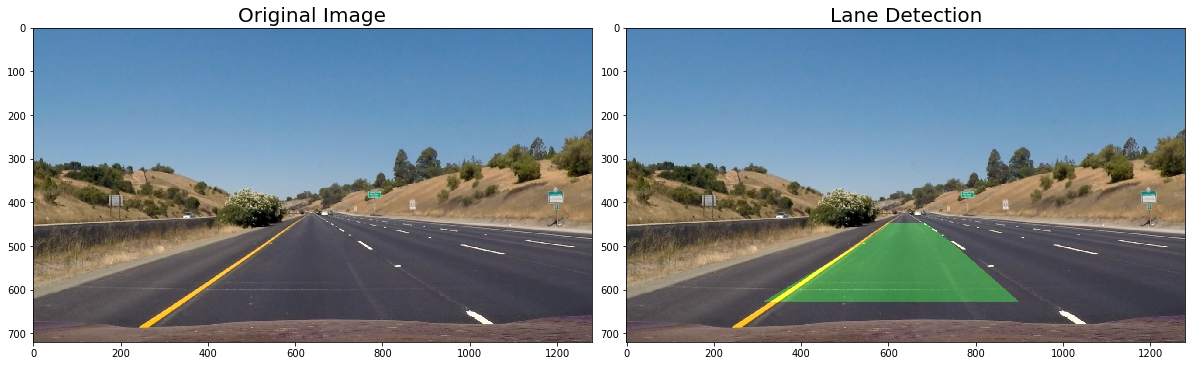

In [15]:
def drawing_lane(image, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result

def process_image(image):

    # Step 1
    color_image, thresh_image = pipeline_threshold(image)

    # Step 2
    warped_image, M, Minv = warped_process(thresh_image)
    warped_image = np.uint8(255*warped_image) # un-scaled

    # Step 3
    window_width = 50
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    window_centroids = find_window_centroids(warped_image, window_width, window_height, margin)
    #draw_window_results(warped_image, window_centroids, window_width, window_height)

    # Step 4
    lines_fit = np.asarray(window_centroids).T
    leftx = lines_fit[0]
    rightx = lines_fit[1]
    image_height = warped_image.shape[0]
    ploty = np.array([float(i)
                     for i in range (int(window_height/2), image_height, window_height)])
    y_eval = np.max(ploty)
    left_curverad = measuring_curvature(leftx, ploty, y_eval)
    right_curverad = measuring_curvature(rightx, ploty, y_eval)
    print(left_curverad, 'm', right_curverad, 'm')

    # Step 5
    left_fit = np.polyfit(ploty, leftx, 2) # f(y)=Ay**2 + By + C
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2) # f(y)=Ay**2 + By + C
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    result = drawing_lane(image, warped_image, Minv, left_fitx, right_fitx, ploty)

    return result

image = mpimg.imread('test_images/straight_lines1.jpg')
output_image = process_image(image)

# Plot in notebook
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(output_image)
ax2.set_title('Lane Detection', fontsize=20)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)

# Save to local disk
plt.savefig('output_images/lane_detection.png')

In [16]:
for image_name in images:
    image = mpimg.imread(image_name)
    process_image(image)

15.1771257893 m 14.8389114826 m
5.68276180827 m 49.6445045994 m
231.119315195 m 116.432611652 m
162.473119745 m 74.7729451939 m
152.98392453 m 125.466908233 m
228.595437657 m 127.7079814 m
125.511419547 m 132.639109439 m
187.859156384 m 3.16122298555 m


## Test on Videos

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_path = 'ouput_videos/'

### Video Project

In [18]:
video_name = 'project_video.mp4'
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+video_name, audio=False)

138.60384049 m 131.32783366 m
[MoviePy] >>>> Building video ouput_videos/project_video.mp4
[MoviePy] Writing video ouput_videos/project_video.mp4


  0%|          | 1/1261 [00:00<14:20,  1.46it/s]

138.60384049 m 131.32783366 m


  0%|          | 2/1261 [00:01<14:31,  1.44it/s]

142.628093186 m 173.06088053 m


  0%|          | 3/1261 [00:02<14:23,  1.46it/s]

141.855791663 m 173.03410384 m


  0%|          | 4/1261 [00:02<14:25,  1.45it/s]

143.930223897 m 120.347171287 m


  0%|          | 5/1261 [00:03<14:20,  1.46it/s]

140.118308326 m 116.115666212 m


  0%|          | 6/1261 [00:04<14:17,  1.46it/s]

143.52009976 m 46.3514274503 m


  1%|          | 7/1261 [00:04<14:20,  1.46it/s]

149.356025584 m 45.2527721161 m


  1%|          | 8/1261 [00:05<14:26,  1.45it/s]

155.869709702 m 199.426931078 m


  1%|          | 9/1261 [00:06<14:13,  1.47it/s]

147.271410005 m 91.7046015787 m


  1%|          | 10/1261 [00:06<14:23,  1.45it/s]

156.083700668 m 119.513660541 m


  1%|          | 11/1261 [00:07<14:28,  1.44it/s]

162.184712556 m 147.098459574 m


  1%|          | 12/1261 [00:08<14:40,  1.42it/s]

155.529462586 m 1061.02575164 m


  1%|          | 13/1261 [00:08<14:21,  1.45it/s]

157.564267947 m 291.845473164 m


  1%|          | 14/1261 [00:09<14:13,  1.46it/s]

152.384718921 m 172.912302844 m


  1%|          | 15/1261 [00:10<14:06,  1.47it/s]

170.84244054 m 187.522436122 m


  1%|▏         | 16/1261 [00:10<13:55,  1.49it/s]

179.374148254 m 184.032181493 m


  1%|▏         | 17/1261 [00:11<13:50,  1.50it/s]

189.652884287 m 208.760596828 m


  1%|▏         | 18/1261 [00:12<13:53,  1.49it/s]

200.145416169 m 279.952030034 m


  2%|▏         | 19/1261 [00:12<14:01,  1.48it/s]

200.701820462 m 276.364984984 m


  2%|▏         | 20/1261 [00:13<14:13,  1.45it/s]

203.639061414 m 167.718624892 m


  2%|▏         | 21/1261 [00:14<14:07,  1.46it/s]

208.275746303 m 127.054256245 m


  2%|▏         | 22/1261 [00:15<13:59,  1.48it/s]

206.174310259 m 114.936838544 m


  2%|▏         | 23/1261 [00:15<13:49,  1.49it/s]

204.060967685 m 99.6748002164 m


  2%|▏         | 24/1261 [00:16<13:47,  1.49it/s]

194.267323445 m 194.976364401 m


  2%|▏         | 25/1261 [00:17<13:49,  1.49it/s]

190.574362817 m 158.128924676 m


  2%|▏         | 26/1261 [00:17<13:45,  1.50it/s]

208.594763851 m 127.149447824 m


  2%|▏         | 27/1261 [00:18<13:57,  1.47it/s]

187.925444134 m 131.976100473 m


  2%|▏         | 28/1261 [00:19<14:07,  1.45it/s]

176.689844691 m 683.498174853 m


  2%|▏         | 29/1261 [00:19<14:11,  1.45it/s]

179.4734398 m 113.933720294 m


  2%|▏         | 30/1261 [00:20<14:08,  1.45it/s]

198.565384565 m 191.623026246 m


  2%|▏         | 31/1261 [00:21<14:01,  1.46it/s]

214.993106482 m 171.346161001 m


  3%|▎         | 32/1261 [00:21<13:55,  1.47it/s]

219.362488529 m 302.565114835 m


  3%|▎         | 33/1261 [00:22<13:53,  1.47it/s]

226.206329191 m 307.990681535 m


  3%|▎         | 34/1261 [00:23<13:50,  1.48it/s]

218.108043313 m 149.715532571 m


  3%|▎         | 35/1261 [00:23<14:04,  1.45it/s]

204.152411238 m 213.756012181 m


  3%|▎         | 36/1261 [00:24<14:05,  1.45it/s]

257.442095755 m 180.135262584 m


  3%|▎         | 37/1261 [00:25<14:09,  1.44it/s]

257.003146744 m 162.093316386 m


  3%|▎         | 38/1261 [00:25<13:57,  1.46it/s]

239.742225287 m 236.098015659 m


  3%|▎         | 39/1261 [00:26<13:51,  1.47it/s]

256.682280316 m 254.957902607 m


  3%|▎         | 40/1261 [00:27<13:51,  1.47it/s]

252.407953733 m 224.92682311 m


  3%|▎         | 41/1261 [00:28<14:02,  1.45it/s]

263.036169602 m 191.630549528 m


  3%|▎         | 42/1261 [00:28<14:02,  1.45it/s]

259.851428123 m 193.655350982 m


  3%|▎         | 43/1261 [00:29<14:29,  1.40it/s]

258.108084861 m 248.070305356 m


  3%|▎         | 44/1261 [00:30<14:26,  1.40it/s]

244.259079842 m 287.20425009 m


  4%|▎         | 45/1261 [00:30<14:18,  1.42it/s]

239.610586299 m 228.244906846 m


  4%|▎         | 46/1261 [00:31<14:09,  1.43it/s]

230.64406444 m 310.889782192 m


  4%|▎         | 47/1261 [00:32<13:57,  1.45it/s]

235.415639657 m 169.058340188 m


  4%|▍         | 48/1261 [00:32<13:55,  1.45it/s]

244.593973322 m 186.979252374 m


  4%|▍         | 49/1261 [00:33<13:55,  1.45it/s]

241.885490868 m 0.798287400353 m


  4%|▍         | 50/1261 [00:34<13:50,  1.46it/s]

224.264666558 m 0.635743544253 m


  4%|▍         | 51/1261 [00:34<13:42,  1.47it/s]

220.857144478 m 294.874240496 m


  4%|▍         | 52/1261 [00:35<13:50,  1.46it/s]

237.264997716 m 252.619546545 m


  4%|▍         | 53/1261 [00:36<14:17,  1.41it/s]

237.258581062 m 218.120440838 m


  4%|▍         | 54/1261 [00:37<14:20,  1.40it/s]

230.975608849 m 191.567692258 m


  4%|▍         | 55/1261 [00:37<14:06,  1.43it/s]

207.528108268 m 218.783152408 m


  4%|▍         | 56/1261 [00:38<14:02,  1.43it/s]

231.469228296 m 235.987933581 m


  5%|▍         | 57/1261 [00:39<13:48,  1.45it/s]

182.841778703 m 2273.64257945 m


  5%|▍         | 58/1261 [00:39<14:07,  1.42it/s]

175.838632688 m 183.816657701 m


  5%|▍         | 59/1261 [00:40<14:03,  1.43it/s]

220.931743796 m 210.392126223 m


  5%|▍         | 60/1261 [00:41<14:07,  1.42it/s]

190.373355887 m 295.756957859 m


  5%|▍         | 61/1261 [00:42<14:10,  1.41it/s]

188.204747004 m 235.156056624 m


  5%|▍         | 62/1261 [00:42<14:14,  1.40it/s]

197.459723604 m 237.401543935 m


  5%|▍         | 63/1261 [00:43<14:09,  1.41it/s]

175.251782037 m 232.10719118 m


  5%|▌         | 64/1261 [00:44<14:27,  1.38it/s]

195.064222465 m 479.257589635 m


  5%|▌         | 65/1261 [00:44<14:30,  1.37it/s]

160.121238092 m 312.767060479 m


  5%|▌         | 66/1261 [00:45<14:17,  1.39it/s]

182.664696861 m 284.322159611 m


  5%|▌         | 67/1261 [00:46<14:31,  1.37it/s]

180.470379193 m 268.34574492 m


  5%|▌         | 68/1261 [00:47<15:12,  1.31it/s]

146.026090979 m 245.966360298 m


  5%|▌         | 69/1261 [00:48<15:43,  1.26it/s]

170.654792762 m 242.338115604 m


  6%|▌         | 70/1261 [00:48<16:01,  1.24it/s]

135.158654703 m 182.905376306 m


  6%|▌         | 71/1261 [00:49<15:31,  1.28it/s]

166.519709806 m 197.076114682 m


  6%|▌         | 72/1261 [00:50<15:15,  1.30it/s]

150.96812574 m 230.736729667 m


  6%|▌         | 73/1261 [00:51<14:58,  1.32it/s]

138.241817205 m 166.242688403 m


  6%|▌         | 74/1261 [00:51<14:29,  1.37it/s]

132.24408917 m 140.720819123 m


  6%|▌         | 75/1261 [00:52<14:18,  1.38it/s]

126.748212049 m 133.154227661 m


  6%|▌         | 76/1261 [00:53<14:18,  1.38it/s]

137.44583478 m 179.854662877 m


  6%|▌         | 77/1261 [00:53<14:05,  1.40it/s]

127.988668884 m 173.272608797 m


  6%|▌         | 78/1261 [00:54<13:53,  1.42it/s]

130.120701235 m 164.863191282 m


  6%|▋         | 79/1261 [00:55<13:41,  1.44it/s]

124.082163834 m 162.503581457 m


  6%|▋         | 80/1261 [00:55<13:35,  1.45it/s]

125.496212632 m 156.227250198 m


  6%|▋         | 81/1261 [00:56<13:39,  1.44it/s]

127.910439496 m 194.874561275 m


  7%|▋         | 82/1261 [00:57<13:37,  1.44it/s]

164.454764962 m 246.072258108 m


  7%|▋         | 83/1261 [00:58<13:37,  1.44it/s]

169.149975873 m 260.471478045 m


  7%|▋         | 84/1261 [00:58<13:40,  1.44it/s]

127.260350816 m 90.0851533757 m


  7%|▋         | 85/1261 [00:59<13:40,  1.43it/s]

125.669627554 m 87.2274361042 m


  7%|▋         | 86/1261 [01:00<13:39,  1.43it/s]

128.496386107 m 283.565978044 m


  7%|▋         | 87/1261 [01:00<13:34,  1.44it/s]

164.439482785 m 131.223351074 m


  7%|▋         | 88/1261 [01:01<13:24,  1.46it/s]

153.255106999 m 165.890799358 m


  7%|▋         | 89/1261 [01:02<13:21,  1.46it/s]

155.729709138 m 162.53561556 m


  7%|▋         | 90/1261 [01:02<13:23,  1.46it/s]

171.021393612 m 231.844234816 m


  7%|▋         | 91/1261 [01:03<13:21,  1.46it/s]

171.15207983 m 155.523189899 m


  7%|▋         | 92/1261 [01:04<13:23,  1.46it/s]

162.962878016 m 185.082568828 m


  7%|▋         | 93/1261 [01:04<13:25,  1.45it/s]

168.176636336 m 261.640257528 m


  7%|▋         | 94/1261 [01:05<13:15,  1.47it/s]

172.903392248 m 218.035746833 m


  8%|▊         | 95/1261 [01:06<13:18,  1.46it/s]

159.747861793 m 151.633174009 m


  8%|▊         | 96/1261 [01:07<13:21,  1.45it/s]

159.955212781 m 1068.58042233 m


  8%|▊         | 97/1261 [01:07<13:16,  1.46it/s]

168.526813246 m 1.39476763731 m


  8%|▊         | 98/1261 [01:08<13:15,  1.46it/s]

160.522134325 m 1.35616392685 m


  8%|▊         | 99/1261 [01:09<13:13,  1.46it/s]

169.867537983 m 207.429562961 m


  8%|▊         | 100/1261 [01:09<13:15,  1.46it/s]

158.559941709 m 125.739502817 m


  8%|▊         | 101/1261 [01:10<13:17,  1.45it/s]

158.973921156 m 114.822181478 m


  8%|▊         | 102/1261 [01:11<13:22,  1.44it/s]

162.140089766 m 150.393725763 m


  8%|▊         | 103/1261 [01:11<13:30,  1.43it/s]

167.284750081 m 169.77870228 m


  8%|▊         | 104/1261 [01:12<13:26,  1.43it/s]

190.000678487 m 154.854845501 m


  8%|▊         | 105/1261 [01:13<13:30,  1.43it/s]

169.413828903 m 149.627604981 m


  8%|▊         | 106/1261 [01:13<13:28,  1.43it/s]

142.017974602 m 183.752561295 m


  8%|▊         | 107/1261 [01:14<13:24,  1.44it/s]

150.369002088 m 149.153106084 m


  9%|▊         | 108/1261 [01:15<13:23,  1.44it/s]

154.463960453 m 253.878695358 m


  9%|▊         | 109/1261 [01:16<13:11,  1.46it/s]

163.967331797 m 104.399722737 m


  9%|▊         | 110/1261 [01:16<13:03,  1.47it/s]

157.240493003 m 89.6573494314 m


  9%|▉         | 111/1261 [01:17<13:04,  1.47it/s]

162.361704828 m 1.42529546329 m


  9%|▉         | 112/1261 [01:18<13:09,  1.46it/s]

159.704369411 m 126.795320435 m


  9%|▉         | 113/1261 [01:18<13:09,  1.45it/s]

156.924053392 m 138.039211161 m


  9%|▉         | 114/1261 [01:19<13:04,  1.46it/s]

157.251823844 m 201.432078576 m


  9%|▉         | 115/1261 [01:20<12:59,  1.47it/s]

195.517716982 m 178.919326012 m


  9%|▉         | 116/1261 [01:20<12:58,  1.47it/s]

189.731995517 m 186.427715685 m


  9%|▉         | 117/1261 [01:21<12:55,  1.47it/s]

192.398162235 m 183.096387686 m


  9%|▉         | 118/1261 [01:22<12:52,  1.48it/s]

192.484956591 m 205.655504582 m


  9%|▉         | 119/1261 [01:22<12:54,  1.47it/s]

193.314612222 m 302.886920638 m


 10%|▉         | 120/1261 [01:23<13:00,  1.46it/s]

203.860902162 m 277.807780952 m


 10%|▉         | 121/1261 [01:24<13:04,  1.45it/s]

205.608347996 m 2.79858082539 m


 10%|▉         | 122/1261 [01:24<12:55,  1.47it/s]

205.192910405 m 211.719803243 m


 10%|▉         | 123/1261 [01:25<12:46,  1.48it/s]

204.46629331 m 292.067121767 m


 10%|▉         | 124/1261 [01:26<12:51,  1.47it/s]

205.831207404 m 250.833846425 m


 10%|▉         | 125/1261 [01:26<12:53,  1.47it/s]

203.172191427 m 236.974234143 m


 10%|▉         | 126/1261 [01:27<12:45,  1.48it/s]

209.234965471 m 206.588948134 m


 10%|█         | 127/1261 [01:28<12:50,  1.47it/s]

202.540343198 m 211.067361637 m


 10%|█         | 128/1261 [01:28<13:04,  1.44it/s]

216.372274372 m 195.167337671 m


 10%|█         | 129/1261 [01:29<13:00,  1.45it/s]

211.528723428 m 302.681332494 m


 10%|█         | 130/1261 [01:30<13:05,  1.44it/s]

209.90761988 m 290.121079646 m


 10%|█         | 131/1261 [01:31<13:07,  1.44it/s]

207.59151816 m 276.97034776 m


 10%|█         | 132/1261 [01:31<13:17,  1.42it/s]

198.333755697 m 247.482680882 m


 11%|█         | 133/1261 [01:32<13:20,  1.41it/s]

195.402492964 m 216.128761585 m


 11%|█         | 134/1261 [01:33<13:06,  1.43it/s]

183.319814109 m 194.807964173 m


 11%|█         | 135/1261 [01:33<13:01,  1.44it/s]

181.891792557 m 278.22556538 m


 11%|█         | 136/1261 [01:34<12:56,  1.45it/s]

192.690258396 m 257.385153545 m


 11%|█         | 137/1261 [01:35<12:49,  1.46it/s]

162.380962059 m 204.073209352 m


 11%|█         | 138/1261 [01:35<12:46,  1.47it/s]

141.648317816 m 138.505342636 m


 11%|█         | 139/1261 [01:36<12:42,  1.47it/s]

134.947524441 m 174.795052333 m


 11%|█         | 140/1261 [01:37<12:44,  1.47it/s]

137.339813893 m 184.308604716 m


 11%|█         | 141/1261 [01:37<12:45,  1.46it/s]

135.327936566 m 170.599512078 m


 11%|█▏        | 142/1261 [01:38<12:38,  1.48it/s]

134.916025321 m 134.926788238 m


 11%|█▏        | 143/1261 [01:39<12:40,  1.47it/s]

141.245259131 m 282.828113327 m


 11%|█▏        | 144/1261 [01:39<12:41,  1.47it/s]

141.021306496 m 137.769521458 m


 11%|█▏        | 145/1261 [01:40<12:50,  1.45it/s]

135.792606416 m 0.99443217647 m


 12%|█▏        | 146/1261 [01:41<12:42,  1.46it/s]

151.02797393 m 2.26949999687 m


 12%|█▏        | 147/1261 [01:42<12:37,  1.47it/s]

145.612946711 m 183.487491955 m


 12%|█▏        | 148/1261 [01:42<12:39,  1.47it/s]

164.873580066 m 244.48494473 m


 12%|█▏        | 149/1261 [01:43<12:45,  1.45it/s]

180.291318689 m 188.894014154 m


 12%|█▏        | 150/1261 [01:44<12:51,  1.44it/s]

156.061048102 m 188.318597816 m


 12%|█▏        | 151/1261 [01:44<13:07,  1.41it/s]

153.859923913 m 184.330474675 m


 12%|█▏        | 152/1261 [01:45<13:16,  1.39it/s]

150.985108293 m 171.854688453 m


 12%|█▏        | 153/1261 [01:46<13:17,  1.39it/s]

164.935658047 m 168.64531859 m


 12%|█▏        | 154/1261 [01:47<13:06,  1.41it/s]

166.048407214 m 158.262178057 m


 12%|█▏        | 155/1261 [01:47<13:15,  1.39it/s]

166.044066182 m 130.117650475 m


 12%|█▏        | 156/1261 [01:48<13:21,  1.38it/s]

156.584622578 m 275.32850087 m


 12%|█▏        | 157/1261 [01:49<13:20,  1.38it/s]

168.980152552 m 178.79161032 m


 13%|█▎        | 158/1261 [01:49<13:17,  1.38it/s]

167.474151423 m 3.86423408942 m


 13%|█▎        | 159/1261 [01:50<13:12,  1.39it/s]

172.588720846 m 179.374890316 m


 13%|█▎        | 160/1261 [01:51<13:09,  1.39it/s]

189.585399304 m 171.243865876 m


 13%|█▎        | 161/1261 [01:52<13:12,  1.39it/s]

178.865332377 m 278.928619697 m


 13%|█▎        | 162/1261 [01:52<13:05,  1.40it/s]

183.562198321 m 140.5334367 m


 13%|█▎        | 163/1261 [01:53<12:50,  1.42it/s]

173.84325362 m 131.985177391 m


 13%|█▎        | 164/1261 [01:54<12:42,  1.44it/s]

206.214874547 m 180.360083603 m


 13%|█▎        | 165/1261 [01:54<12:36,  1.45it/s]

226.239493039 m 192.000387018 m


 13%|█▎        | 166/1261 [01:55<12:40,  1.44it/s]

221.994614056 m 193.545821508 m


 13%|█▎        | 167/1261 [01:56<12:46,  1.43it/s]

231.738887024 m 200.860812224 m


 13%|█▎        | 168/1261 [01:56<12:39,  1.44it/s]

222.692233758 m 218.561930852 m


 13%|█▎        | 169/1261 [01:57<12:31,  1.45it/s]

229.403331927 m 201.60734956 m


 13%|█▎        | 170/1261 [01:58<12:27,  1.46it/s]

214.594788733 m 290.750308778 m


 14%|█▎        | 171/1261 [01:58<12:37,  1.44it/s]

220.350644203 m 314.525257918 m


 14%|█▎        | 172/1261 [01:59<12:51,  1.41it/s]

217.297060671 m 243.244804657 m


 14%|█▎        | 173/1261 [02:00<12:53,  1.41it/s]

218.205749567 m 216.473897415 m


 14%|█▍        | 174/1261 [02:01<12:40,  1.43it/s]

220.449450659 m 229.912763475 m


 14%|█▍        | 175/1261 [02:01<12:39,  1.43it/s]

224.262070434 m 288.621520482 m


 14%|█▍        | 176/1261 [02:02<12:37,  1.43it/s]

227.959213665 m 253.848196491 m


 14%|█▍        | 177/1261 [02:03<12:24,  1.46it/s]

216.800704067 m 253.261810863 m


 14%|█▍        | 178/1261 [02:03<12:23,  1.46it/s]

219.251669215 m 240.296062376 m


 14%|█▍        | 179/1261 [02:04<12:18,  1.47it/s]

215.5741006 m 260.116415229 m


 14%|█▍        | 180/1261 [02:05<12:27,  1.45it/s]

221.52720942 m 336.821641845 m


 14%|█▍        | 181/1261 [02:05<12:27,  1.44it/s]

225.00065965 m 293.369597814 m


 14%|█▍        | 182/1261 [02:06<12:23,  1.45it/s]

219.891324641 m 255.597538367 m


 15%|█▍        | 183/1261 [02:07<12:20,  1.46it/s]

225.51001627 m 296.262206924 m


 15%|█▍        | 184/1261 [02:07<12:21,  1.45it/s]

232.922620632 m 266.014746549 m


 15%|█▍        | 185/1261 [02:08<12:15,  1.46it/s]

236.497774203 m 354.137401978 m


 15%|█▍        | 186/1261 [02:09<12:09,  1.47it/s]

250.647531036 m 308.755504484 m


 15%|█▍        | 187/1261 [02:10<12:08,  1.47it/s]

253.941610171 m 254.499635749 m


 15%|█▍        | 188/1261 [02:10<12:07,  1.48it/s]

257.410190445 m 136.560900256 m


 15%|█▍        | 189/1261 [02:11<12:09,  1.47it/s]

257.397827575 m 219.741291015 m


 15%|█▌        | 190/1261 [02:12<12:04,  1.48it/s]

259.44653408 m 76.5940014363 m


 15%|█▌        | 191/1261 [02:12<11:57,  1.49it/s]

262.817219639 m 86.1346725905 m


 15%|█▌        | 192/1261 [02:13<12:01,  1.48it/s]

260.395814404 m 316.56627455 m


 15%|█▌        | 193/1261 [02:14<12:01,  1.48it/s]

266.336969888 m 40.5863293724 m


 15%|█▌        | 194/1261 [02:14<11:57,  1.49it/s]

262.836751114 m 33.7534497716 m


 15%|█▌        | 195/1261 [02:15<12:00,  1.48it/s]

258.151147276 m 387.17345113 m


 16%|█▌        | 196/1261 [02:16<12:02,  1.47it/s]

247.591568428 m 265.286699913 m


 16%|█▌        | 197/1261 [02:16<12:09,  1.46it/s]

231.632068169 m 45.8092195401 m


 16%|█▌        | 198/1261 [02:17<12:00,  1.48it/s]

219.85356277 m 130.05087515 m


 16%|█▌        | 199/1261 [02:18<11:57,  1.48it/s]

210.659614984 m 124.987831208 m


 16%|█▌        | 200/1261 [02:18<12:01,  1.47it/s]

206.538893486 m 31.7114758656 m


 16%|█▌        | 201/1261 [02:19<11:59,  1.47it/s]

203.667883136 m 319.356703954 m


 16%|█▌        | 202/1261 [02:20<11:55,  1.48it/s]

210.121843203 m 150.359690765 m


 16%|█▌        | 203/1261 [02:20<11:58,  1.47it/s]

211.088000583 m 175.302957427 m


 16%|█▌        | 204/1261 [02:21<11:56,  1.48it/s]

208.811952834 m 184.271698912 m


 16%|█▋        | 205/1261 [02:22<11:54,  1.48it/s]

216.704613151 m 174.613701948 m


 16%|█▋        | 206/1261 [02:22<11:54,  1.48it/s]

219.725608574 m 290.214927119 m


 16%|█▋        | 207/1261 [02:23<11:53,  1.48it/s]

228.471187087 m 269.920859955 m


 16%|█▋        | 208/1261 [02:24<11:55,  1.47it/s]

232.014390725 m 251.949182684 m


 17%|█▋        | 209/1261 [02:24<11:56,  1.47it/s]

230.295065534 m 235.033287768 m


 17%|█▋        | 210/1261 [02:25<11:50,  1.48it/s]

226.453950653 m 227.146962367 m


 17%|█▋        | 211/1261 [02:26<11:46,  1.49it/s]

218.845323349 m 212.118442538 m


 17%|█▋        | 212/1261 [02:26<11:48,  1.48it/s]

220.027175942 m 173.235271047 m


 17%|█▋        | 213/1261 [02:27<11:45,  1.49it/s]

210.179289983 m 258.57250228 m


 17%|█▋        | 214/1261 [02:28<11:48,  1.48it/s]

219.406155643 m 265.718192758 m


 17%|█▋        | 215/1261 [02:28<11:49,  1.47it/s]

219.81321372 m 218.980767046 m


 17%|█▋        | 216/1261 [02:29<11:50,  1.47it/s]

220.157673828 m 204.533159072 m


 17%|█▋        | 217/1261 [02:30<11:48,  1.47it/s]

218.951049649 m 277.909342823 m


 17%|█▋        | 218/1261 [02:31<11:45,  1.48it/s]

211.229834466 m 258.626672552 m


 17%|█▋        | 219/1261 [02:31<11:42,  1.48it/s]

214.416753661 m 1787.05352044 m


 17%|█▋        | 220/1261 [02:32<11:51,  1.46it/s]

204.552022207 m 264.624591099 m


 18%|█▊        | 221/1261 [02:33<11:53,  1.46it/s]

205.505682077 m 260.238407202 m


 18%|█▊        | 222/1261 [02:33<11:56,  1.45it/s]

202.650087507 m 1.81119221588 m


 18%|█▊        | 223/1261 [02:34<11:52,  1.46it/s]

200.532782217 m 0.676228798388 m


 18%|█▊        | 224/1261 [02:35<11:53,  1.45it/s]

205.514090154 m 241.702474066 m


 18%|█▊        | 225/1261 [02:35<11:54,  1.45it/s]

203.549738899 m 194.900386672 m


 18%|█▊        | 226/1261 [02:36<11:47,  1.46it/s]

204.590706883 m 228.533203148 m


 18%|█▊        | 227/1261 [02:37<11:40,  1.48it/s]

199.606449301 m 211.134028889 m


 18%|█▊        | 228/1261 [02:37<11:43,  1.47it/s]

198.428033989 m 178.966591978 m


 18%|█▊        | 229/1261 [02:38<11:38,  1.48it/s]

194.319722173 m 200.873171563 m


 18%|█▊        | 230/1261 [02:39<11:35,  1.48it/s]

190.252568786 m 199.097680041 m


 18%|█▊        | 231/1261 [02:39<11:32,  1.49it/s]

190.332371055 m 264.486186872 m


 18%|█▊        | 232/1261 [02:40<11:34,  1.48it/s]

181.225590992 m 257.180569954 m


 18%|█▊        | 233/1261 [02:41<11:30,  1.49it/s]

185.033696428 m 262.189824994 m


 19%|█▊        | 234/1261 [02:41<11:37,  1.47it/s]

181.443923251 m 235.198132498 m


 19%|█▊        | 235/1261 [02:42<11:37,  1.47it/s]

181.312378387 m 360.10871843 m


 19%|█▊        | 236/1261 [02:43<11:56,  1.43it/s]

185.624397643 m 257.622395626 m


 19%|█▉        | 237/1261 [02:44<11:52,  1.44it/s]

183.08171619 m 242.242205167 m


 19%|█▉        | 238/1261 [02:44<11:44,  1.45it/s]

187.048912008 m 235.484659431 m


 19%|█▉        | 239/1261 [02:45<11:38,  1.46it/s]

189.18345003 m 347.743407752 m


 19%|█▉        | 240/1261 [02:46<11:35,  1.47it/s]

186.149780658 m 379.43588659 m


 19%|█▉        | 241/1261 [02:46<11:31,  1.48it/s]

183.796286938 m 285.65568722 m


 19%|█▉        | 242/1261 [02:47<11:28,  1.48it/s]

179.286117086 m 204.270947348 m


 19%|█▉        | 243/1261 [02:48<11:31,  1.47it/s]

185.609133222 m 254.028228947 m


 19%|█▉        | 244/1261 [02:48<11:32,  1.47it/s]

184.341548448 m 249.319787667 m


 19%|█▉        | 245/1261 [02:49<11:35,  1.46it/s]

190.075291742 m 218.946055959 m


 20%|█▉        | 246/1261 [02:50<11:34,  1.46it/s]

190.124728128 m 304.873404672 m


 20%|█▉        | 247/1261 [02:50<11:35,  1.46it/s]

189.405384829 m 254.882523834 m


 20%|█▉        | 248/1261 [02:51<11:30,  1.47it/s]

195.973779287 m 424.613694505 m


 20%|█▉        | 249/1261 [02:52<11:25,  1.48it/s]

191.489510446 m 231.733894691 m


 20%|█▉        | 250/1261 [02:52<11:21,  1.48it/s]

194.397714472 m 275.562510222 m


 20%|█▉        | 251/1261 [02:53<11:19,  1.49it/s]

190.727438436 m 261.863304462 m


 20%|█▉        | 252/1261 [02:54<11:23,  1.48it/s]

189.495330915 m 312.133107008 m


 20%|██        | 253/1261 [02:54<11:19,  1.48it/s]

187.943236807 m 248.171116795 m


 20%|██        | 254/1261 [02:55<11:16,  1.49it/s]

188.703376214 m 395.306217196 m


 20%|██        | 255/1261 [02:56<11:13,  1.49it/s]

191.996532838 m 235.816091934 m


 20%|██        | 256/1261 [02:56<11:14,  1.49it/s]

192.667526214 m 213.223110491 m


 20%|██        | 257/1261 [02:57<11:13,  1.49it/s]

199.293047475 m 288.127057175 m


 20%|██        | 258/1261 [02:58<11:16,  1.48it/s]

195.696401759 m 263.744583464 m


 21%|██        | 259/1261 [02:58<11:15,  1.48it/s]

155.616682787 m 214.623987131 m


 21%|██        | 260/1261 [02:59<11:14,  1.48it/s]

154.071653708 m 192.218138226 m


 21%|██        | 261/1261 [03:00<11:16,  1.48it/s]

101.955661386 m 189.341796886 m


 21%|██        | 262/1261 [03:00<11:12,  1.49it/s]

105.346163634 m 167.313985322 m


 21%|██        | 263/1261 [03:01<11:13,  1.48it/s]

114.595706698 m 217.144021457 m


 21%|██        | 264/1261 [03:02<11:19,  1.47it/s]

113.235005728 m 283.642379709 m


 21%|██        | 265/1261 [03:02<11:13,  1.48it/s]

124.40433325 m 250.455163241 m


 21%|██        | 266/1261 [03:03<11:10,  1.48it/s]

131.07913246 m 254.458358959 m


 21%|██        | 267/1261 [03:04<11:09,  1.48it/s]

122.946402865 m 151.768520624 m


 21%|██▏       | 268/1261 [03:04<11:08,  1.48it/s]

125.741926231 m 166.120009542 m


 21%|██▏       | 269/1261 [03:05<11:04,  1.49it/s]

120.298362115 m 158.400242013 m


 21%|██▏       | 270/1261 [03:06<11:01,  1.50it/s]

116.499296186 m 153.854187139 m


 21%|██▏       | 271/1261 [03:06<11:00,  1.50it/s]

113.725299655 m 194.919298737 m


 22%|██▏       | 272/1261 [03:07<11:03,  1.49it/s]

113.271604485 m 159.865243264 m


 22%|██▏       | 273/1261 [03:08<11:11,  1.47it/s]

112.57659331 m 152.531009905 m


 22%|██▏       | 274/1261 [03:08<11:07,  1.48it/s]

109.431830984 m 255.208453122 m


 22%|██▏       | 275/1261 [03:09<11:04,  1.48it/s]

107.092567826 m 235.009862633 m


 22%|██▏       | 276/1261 [03:10<11:05,  1.48it/s]

98.4773172675 m 229.652671257 m


 22%|██▏       | 277/1261 [03:11<11:18,  1.45it/s]

89.9209773665 m 180.245187666 m


 22%|██▏       | 278/1261 [03:11<11:10,  1.47it/s]

83.5585049618 m 154.557091 m


 22%|██▏       | 279/1261 [03:12<11:04,  1.48it/s]

83.786951908 m 128.592864245 m


 22%|██▏       | 280/1261 [03:13<11:06,  1.47it/s]

81.7010315 m 189.30274812 m


 22%|██▏       | 281/1261 [03:13<11:01,  1.48it/s]

77.6963142167 m 184.778060249 m


 22%|██▏       | 282/1261 [03:14<11:02,  1.48it/s]

74.4218392935 m 148.54125978 m


 22%|██▏       | 283/1261 [03:15<11:03,  1.47it/s]

73.0978498209 m 131.606716184 m


 23%|██▎       | 284/1261 [03:15<11:11,  1.46it/s]

66.2566055972 m 108.578976545 m


 23%|██▎       | 285/1261 [03:16<11:10,  1.46it/s]

72.4543243821 m 97.6719650484 m


 23%|██▎       | 286/1261 [03:17<11:04,  1.47it/s]

72.0583888614 m 180.155144328 m


 23%|██▎       | 287/1261 [03:17<11:01,  1.47it/s]

61.7385135355 m 87.559330153 m


 23%|██▎       | 288/1261 [03:18<11:00,  1.47it/s]

64.8880500376 m 79.1961626728 m


 23%|██▎       | 289/1261 [03:19<10:57,  1.48it/s]

58.6050545849 m 146.433947202 m


 23%|██▎       | 290/1261 [03:19<10:54,  1.48it/s]

56.7526194799 m 130.001812897 m


 23%|██▎       | 291/1261 [03:20<10:49,  1.49it/s]

54.1298081954 m 99.2660973506 m


 23%|██▎       | 292/1261 [03:21<10:58,  1.47it/s]

52.5610788767 m 200.535149097 m


 23%|██▎       | 293/1261 [03:21<11:03,  1.46it/s]

38.6843371771 m 175.462234515 m


 23%|██▎       | 294/1261 [03:22<10:57,  1.47it/s]

50.6988767884 m 176.082836308 m


 23%|██▎       | 295/1261 [03:23<11:09,  1.44it/s]

49.4462632533 m 168.878922466 m


 23%|██▎       | 296/1261 [03:23<11:02,  1.46it/s]

44.4393616177 m 145.788162325 m


 24%|██▎       | 297/1261 [03:24<10:55,  1.47it/s]

41.8969465554 m 83.6440981099 m


 24%|██▎       | 298/1261 [03:25<10:53,  1.47it/s]

41.8242685116 m 136.452956612 m


 24%|██▎       | 299/1261 [03:25<10:53,  1.47it/s]

41.0691929207 m 120.405405113 m


 24%|██▍       | 300/1261 [03:26<10:49,  1.48it/s]

42.9784671248 m 116.448176319 m


 24%|██▍       | 301/1261 [03:27<10:46,  1.48it/s]

41.5766707719 m 101.958155754 m


 24%|██▍       | 302/1261 [03:27<10:44,  1.49it/s]

42.7557508142 m 109.78719047 m


 24%|██▍       | 303/1261 [03:28<10:43,  1.49it/s]

42.888772341 m 85.0973822096 m


 24%|██▍       | 304/1261 [03:29<10:50,  1.47it/s]

39.8132384905 m 74.760231502 m


 24%|██▍       | 305/1261 [03:30<10:48,  1.47it/s]

39.9927047406 m 65.0939356223 m


 24%|██▍       | 306/1261 [03:30<10:49,  1.47it/s]

33.4902290641 m 77.2715455035 m


 24%|██▍       | 307/1261 [03:31<10:53,  1.46it/s]

33.9888416795 m 68.9044818233 m


 24%|██▍       | 308/1261 [03:32<10:52,  1.46it/s]

25.4702228802 m 94.7028381159 m


 25%|██▍       | 309/1261 [03:32<10:45,  1.47it/s]

24.0056722144 m 90.9074939913 m


 25%|██▍       | 310/1261 [03:33<10:47,  1.47it/s]

20.199402523 m 75.7864447136 m


 25%|██▍       | 311/1261 [03:34<10:45,  1.47it/s]

17.8617195755 m 75.4793102125 m


 25%|██▍       | 312/1261 [03:34<10:43,  1.47it/s]

15.6793847623 m 69.648786378 m


 25%|██▍       | 313/1261 [03:35<10:40,  1.48it/s]

12.7580986331 m 145.301093529 m


 25%|██▍       | 314/1261 [03:36<10:43,  1.47it/s]

12.7441072035 m 104.787730671 m


 25%|██▍       | 315/1261 [03:36<10:41,  1.47it/s]

13.6254462604 m 150.737608248 m


 25%|██▌       | 316/1261 [03:37<10:38,  1.48it/s]

11.3481310887 m 51.6054407871 m


 25%|██▌       | 317/1261 [03:38<10:41,  1.47it/s]

13.0003928224 m 52.5308884745 m


 25%|██▌       | 318/1261 [03:38<10:51,  1.45it/s]

12.2292842152 m 67.7289612068 m


 25%|██▌       | 319/1261 [03:39<10:44,  1.46it/s]

14.4281761011 m 57.6514840431 m


 25%|██▌       | 320/1261 [03:40<10:38,  1.47it/s]

13.8547301406 m 68.7236031075 m


 25%|██▌       | 321/1261 [03:40<10:39,  1.47it/s]

16.0885002623 m 49.1608295803 m


 26%|██▌       | 322/1261 [03:41<10:37,  1.47it/s]

14.6588804541 m 53.7487925113 m


 26%|██▌       | 323/1261 [03:42<10:33,  1.48it/s]

8.3009530258 m 53.8776172198 m


 26%|██▌       | 324/1261 [03:42<10:36,  1.47it/s]

7.66275316046 m 38.4280437074 m


 26%|██▌       | 325/1261 [03:43<10:32,  1.48it/s]

6.71549328033 m 46.6942216058 m


 26%|██▌       | 326/1261 [03:44<10:33,  1.48it/s]

6.41458390271 m 4.83263207903 m


 26%|██▌       | 327/1261 [03:44<10:31,  1.48it/s]

6.63522319043 m 18.8917485581 m


 26%|██▌       | 328/1261 [03:45<10:30,  1.48it/s]

6.64393377695 m 7.95685828256 m


 26%|██▌       | 329/1261 [03:46<10:34,  1.47it/s]

8.30925833262 m 23.6739973565 m


 26%|██▌       | 330/1261 [03:47<10:32,  1.47it/s]

6.9006218226 m 24.3827562287 m


 26%|██▌       | 331/1261 [03:47<10:30,  1.48it/s]

9.33730249272 m 39.5409224307 m


 26%|██▋       | 332/1261 [03:48<10:32,  1.47it/s]

8.04842765285 m 9.10300305763 m


 26%|██▋       | 333/1261 [03:49<10:27,  1.48it/s]

9.43575463277 m 4.67595573218 m


 26%|██▋       | 334/1261 [03:49<10:31,  1.47it/s]

5.66161855048 m 2.28420739108 m


 27%|██▋       | 335/1261 [03:50<10:31,  1.47it/s]

7.73454734942 m 12.1855232478 m


 27%|██▋       | 336/1261 [03:51<10:26,  1.48it/s]

7.49000183447 m 32.9045936444 m


 27%|██▋       | 337/1261 [03:51<10:24,  1.48it/s]

6.6990030948 m 32.8306286411 m


 27%|██▋       | 338/1261 [03:52<10:25,  1.48it/s]

6.61803064201 m 21.9346528224 m


 27%|██▋       | 339/1261 [03:53<10:22,  1.48it/s]

6.28887249608 m 27.8760420112 m


 27%|██▋       | 340/1261 [03:53<10:22,  1.48it/s]

5.62619129531 m 37.6065428495 m


 27%|██▋       | 341/1261 [03:54<10:28,  1.46it/s]

5.53592300594 m 14.3286684306 m


 27%|██▋       | 342/1261 [03:55<10:29,  1.46it/s]

6.45255293437 m 19.6640979479 m


 27%|██▋       | 343/1261 [03:55<10:32,  1.45it/s]

4.97520673744 m 49.6832494093 m


 27%|██▋       | 344/1261 [03:56<10:29,  1.46it/s]

5.77609141454 m 36.1864594853 m


 27%|██▋       | 345/1261 [03:57<10:24,  1.47it/s]

5.91100361553 m 34.8346762692 m


 27%|██▋       | 346/1261 [03:57<10:29,  1.45it/s]

6.66925071683 m 29.5743184237 m


 28%|██▊       | 347/1261 [03:58<10:24,  1.46it/s]

5.88212882577 m 34.5323884267 m


 28%|██▊       | 348/1261 [03:59<10:19,  1.47it/s]

6.78642026005 m 34.724488297 m


 28%|██▊       | 349/1261 [03:59<10:18,  1.47it/s]

10.2812257402 m 29.0694531393 m


 28%|██▊       | 350/1261 [04:00<10:19,  1.47it/s]

6.30208256521 m 21.6297988514 m


 28%|██▊       | 351/1261 [04:01<10:18,  1.47it/s]

7.77124488522 m 18.0263736585 m


 28%|██▊       | 352/1261 [04:02<10:17,  1.47it/s]

9.3890847065 m 16.5698051227 m


 28%|██▊       | 353/1261 [04:02<10:13,  1.48it/s]

6.59696132021 m 17.0287126551 m


 28%|██▊       | 354/1261 [04:03<10:15,  1.47it/s]

44.5718461742 m 23.0457824979 m


 28%|██▊       | 355/1261 [04:04<10:11,  1.48it/s]

6.49678702408 m 102.295332015 m


 28%|██▊       | 356/1261 [04:04<10:08,  1.49it/s]

10.5523720962 m 15.2446388795 m


 28%|██▊       | 357/1261 [04:05<10:07,  1.49it/s]

5.69033407451 m 8.79414586592 m


 28%|██▊       | 358/1261 [04:06<10:07,  1.49it/s]

4.86166528312 m 2.30270101893 m


 28%|██▊       | 359/1261 [04:06<10:15,  1.47it/s]

6.58908086522 m 28.0144986776 m


 29%|██▊       | 360/1261 [04:07<10:42,  1.40it/s]

5.80438811046 m 24.4958657807 m


 29%|██▊       | 361/1261 [04:08<10:38,  1.41it/s]

6.49166983359 m 22.2683529087 m


 29%|██▊       | 362/1261 [04:08<10:37,  1.41it/s]

6.2557824294 m 26.5202815328 m


 29%|██▉       | 363/1261 [04:09<10:25,  1.44it/s]

6.12752362309 m 23.4789180014 m


 29%|██▉       | 364/1261 [04:10<10:18,  1.45it/s]

7.23158503463 m 2.20970990755 m


 29%|██▉       | 365/1261 [04:10<10:13,  1.46it/s]

14.9915687011 m 17.0946233869 m


 29%|██▉       | 366/1261 [04:11<10:09,  1.47it/s]

55.00161686 m 15.8514379242 m


 29%|██▉       | 367/1261 [04:12<10:06,  1.47it/s]

30.3976806731 m 13.4886768269 m


 29%|██▉       | 368/1261 [04:12<10:06,  1.47it/s]

95.8357235622 m 3.63727564697 m


 29%|██▉       | 369/1261 [04:13<10:00,  1.48it/s]

49.2849289267 m 20.9340892392 m


 29%|██▉       | 370/1261 [04:14<10:03,  1.48it/s]

8.69568607842 m 19.7924934041 m


 29%|██▉       | 371/1261 [04:15<10:05,  1.47it/s]

6.15834757076 m 32.8741911581 m


 30%|██▉       | 372/1261 [04:15<10:01,  1.48it/s]

4.04135738072 m 24.1156469629 m


 30%|██▉       | 373/1261 [04:16<10:04,  1.47it/s]

4.42710466333 m 18.0156104127 m


 30%|██▉       | 374/1261 [04:17<10:03,  1.47it/s]

4.97892358021 m 34.6544318134 m


 30%|██▉       | 375/1261 [04:17<10:00,  1.47it/s]

3.61695526212 m 22.7401554283 m


 30%|██▉       | 376/1261 [04:18<09:59,  1.48it/s]

4.06768697721 m 2.13204864301 m


 30%|██▉       | 377/1261 [04:19<09:54,  1.49it/s]

3.75786191572 m 21.1478414989 m


 30%|██▉       | 378/1261 [04:19<09:58,  1.48it/s]

3.74666712149 m 29.795670518 m


 30%|███       | 379/1261 [04:20<09:55,  1.48it/s]

4.02866339735 m 2.08312377414 m


 30%|███       | 380/1261 [04:21<09:58,  1.47it/s]

4.39498878712 m 4.17512279412 m


 30%|███       | 381/1261 [04:21<09:57,  1.47it/s]

4.67644481787 m 3.38857012802 m


 30%|███       | 382/1261 [04:22<10:01,  1.46it/s]

4.9697586416 m 2.43604046163 m


 30%|███       | 383/1261 [04:23<10:03,  1.45it/s]

5.03894616109 m 2.68618658669 m


 30%|███       | 384/1261 [04:23<10:00,  1.46it/s]

5.12038726658 m 13.2238663185 m


 31%|███       | 385/1261 [04:24<09:56,  1.47it/s]

5.69944515478 m 2.37961487481 m


 31%|███       | 386/1261 [04:25<09:56,  1.47it/s]

6.39829386549 m 2.55562218186 m


 31%|███       | 387/1261 [04:25<09:55,  1.47it/s]

7.8094950882 m 4.20579531232 m


 31%|███       | 388/1261 [04:26<09:58,  1.46it/s]

7.95904164843 m 14.0935849124 m


 31%|███       | 389/1261 [04:27<10:01,  1.45it/s]

9.19267570498 m 10.8894193659 m


 31%|███       | 390/1261 [04:27<10:04,  1.44it/s]

9.55840502552 m 11.7114068279 m


 31%|███       | 391/1261 [04:28<10:06,  1.43it/s]

10.7885037048 m 8.84407303537 m


 31%|███       | 392/1261 [04:29<10:00,  1.45it/s]

11.9784369966 m 8.72347334776 m


 31%|███       | 393/1261 [04:30<09:55,  1.46it/s]

10.6897289004 m 15.1312261365 m


 31%|███       | 394/1261 [04:30<09:54,  1.46it/s]

11.5358077262 m 14.8549672514 m


 31%|███▏      | 395/1261 [04:31<09:54,  1.46it/s]

10.9391532066 m 39.3698427142 m


 31%|███▏      | 396/1261 [04:32<09:51,  1.46it/s]

10.7318395301 m 17.7250552174 m


 31%|███▏      | 397/1261 [04:32<09:52,  1.46it/s]

12.3193977557 m 11.1113276412 m


 32%|███▏      | 398/1261 [04:33<09:53,  1.45it/s]

12.5705351027 m 15.3698854324 m


 32%|███▏      | 399/1261 [04:34<09:47,  1.47it/s]

13.9304930352 m 35.6173867985 m


 32%|███▏      | 400/1261 [04:34<09:48,  1.46it/s]

3.57752829866 m 3.32669670015 m


 32%|███▏      | 401/1261 [04:35<09:43,  1.47it/s]

12.7815472685 m 3.10677421194 m


 32%|███▏      | 402/1261 [04:36<09:45,  1.47it/s]

13.2060086479 m 3.9057953378 m


 32%|███▏      | 403/1261 [04:36<09:43,  1.47it/s]

12.6162561706 m 11.9800075247 m


 32%|███▏      | 404/1261 [04:37<09:38,  1.48it/s]

12.2451688909 m 10.0531100901 m


 32%|███▏      | 405/1261 [04:38<09:35,  1.49it/s]

13.106614431 m 25.7168423617 m


 32%|███▏      | 406/1261 [04:38<09:38,  1.48it/s]

9.19511977224 m 8.44630951226 m


 32%|███▏      | 407/1261 [04:39<09:35,  1.48it/s]

10.8583030124 m 7.67761595954 m


 32%|███▏      | 408/1261 [04:40<09:35,  1.48it/s]

9.16214325538 m 11.7648993757 m


 32%|███▏      | 409/1261 [04:40<09:32,  1.49it/s]

6.79336742777 m 10.8810242424 m


 33%|███▎      | 410/1261 [04:41<09:37,  1.47it/s]

12.7587878477 m 9.00879800673 m


 33%|███▎      | 411/1261 [04:42<09:36,  1.47it/s]

13.7002601227 m 15.3160620435 m


 33%|███▎      | 412/1261 [04:42<09:33,  1.48it/s]

15.9569994753 m 3.18111026572 m


 33%|███▎      | 413/1261 [04:43<09:31,  1.48it/s]

16.4839737546 m 3.20483531298 m


 33%|███▎      | 414/1261 [04:44<09:33,  1.48it/s]

16.4743834795 m 3.91801158198 m


 33%|███▎      | 415/1261 [04:44<09:32,  1.48it/s]

15.0835815236 m 16.0110868718 m


 33%|███▎      | 416/1261 [04:45<09:30,  1.48it/s]

18.171138164 m 13.4776890634 m


 33%|███▎      | 417/1261 [04:46<09:26,  1.49it/s]

18.3003519476 m 18.8399531583 m


 33%|███▎      | 418/1261 [04:46<09:32,  1.47it/s]

16.4557341979 m 15.2675907756 m


 33%|███▎      | 419/1261 [04:47<09:31,  1.47it/s]

16.2448518325 m 14.6729133677 m


 33%|███▎      | 420/1261 [04:48<09:34,  1.47it/s]

8.40072862133 m 19.5477325918 m


 33%|███▎      | 421/1261 [04:49<09:30,  1.47it/s]

8.20006314398 m 9.27928040056 m


 33%|███▎      | 422/1261 [04:49<09:33,  1.46it/s]

11.7730741983 m 8.62537673129 m


 34%|███▎      | 423/1261 [04:50<09:31,  1.47it/s]

12.6696148046 m 6.20792879714 m


 34%|███▎      | 424/1261 [04:51<09:26,  1.48it/s]

14.8384112242 m 2.9161224688 m


 34%|███▎      | 425/1261 [04:51<09:24,  1.48it/s]

15.7127140404 m 19.6289449403 m


 34%|███▍      | 426/1261 [04:52<09:28,  1.47it/s]

16.2804604732 m 5.49850931082 m


 34%|███▍      | 427/1261 [04:53<09:25,  1.48it/s]

11.8114281241 m 15.0950676594 m


 34%|███▍      | 428/1261 [04:53<09:23,  1.48it/s]

11.7248188191 m 13.249401988 m


 34%|███▍      | 429/1261 [04:54<09:26,  1.47it/s]

12.1382426949 m 10.9640189343 m


 34%|███▍      | 430/1261 [04:55<09:25,  1.47it/s]

11.7620411137 m 15.4635633674 m


 34%|███▍      | 431/1261 [04:55<09:23,  1.47it/s]

13.4881113047 m 13.2634749239 m


 34%|███▍      | 432/1261 [04:56<09:19,  1.48it/s]

12.8569582516 m 13.7792205674 m


 34%|███▍      | 433/1261 [04:57<09:15,  1.49it/s]

14.5359505948 m 11.7322837771 m


 34%|███▍      | 434/1261 [04:57<09:23,  1.47it/s]

13.9143067554 m 6.55873164403 m


 34%|███▍      | 435/1261 [04:58<09:20,  1.47it/s]

12.163405218 m 6.89249279315 m


 35%|███▍      | 436/1261 [04:59<09:19,  1.47it/s]

10.6279742042 m 2.70702532786 m


 35%|███▍      | 437/1261 [04:59<09:19,  1.47it/s]

8.46996946398 m 18.1449351537 m


 35%|███▍      | 438/1261 [05:00<09:17,  1.48it/s]

9.47355644062 m 15.8378867768 m


 35%|███▍      | 439/1261 [05:01<09:15,  1.48it/s]

11.0325255505 m 14.4339645838 m


 35%|███▍      | 440/1261 [05:01<09:13,  1.48it/s]

9.25065352834 m 4.4015992049 m


 35%|███▍      | 441/1261 [05:02<09:11,  1.49it/s]

7.69717586979 m 2.80044742167 m


 35%|███▌      | 442/1261 [05:03<09:14,  1.48it/s]

6.38894715611 m 2.67045761349 m


 35%|███▌      | 443/1261 [05:03<09:14,  1.47it/s]

8.03682066058 m 9.32682239684 m


 35%|███▌      | 444/1261 [05:04<09:13,  1.48it/s]

7.2543702562 m 4.14627150748 m


 35%|███▌      | 445/1261 [05:05<09:12,  1.48it/s]

7.36268992091 m 25.0645561418 m


 35%|███▌      | 446/1261 [05:06<09:19,  1.46it/s]

6.58170991106 m 166.045928828 m


 35%|███▌      | 447/1261 [05:06<09:14,  1.47it/s]

8.37400293464 m 18.5545582736 m


 36%|███▌      | 448/1261 [05:07<09:11,  1.47it/s]

5.25451986054 m 14.2304304596 m


 36%|███▌      | 449/1261 [05:08<09:12,  1.47it/s]

6.01323528872 m 16.2088598302 m


 36%|███▌      | 450/1261 [05:08<09:10,  1.47it/s]

4.82559030236 m 14.014334585 m


 36%|███▌      | 451/1261 [05:09<09:09,  1.47it/s]

4.75610090745 m 20.3622727267 m


 36%|███▌      | 452/1261 [05:10<09:07,  1.48it/s]

5.09471058935 m 15.9431043357 m


 36%|███▌      | 453/1261 [05:10<09:04,  1.48it/s]

5.42767302722 m 994.235682956 m


 36%|███▌      | 454/1261 [05:11<09:04,  1.48it/s]

5.04268827189 m 2.248307975 m


 36%|███▌      | 455/1261 [05:12<09:06,  1.48it/s]

5.30031091303 m 2.3981136984 m


 36%|███▌      | 456/1261 [05:12<09:05,  1.48it/s]

4.76946100431 m 3.7257735341 m


 36%|███▌      | 457/1261 [05:13<09:04,  1.48it/s]

4.65604801641 m 16.8700292465 m


 36%|███▋      | 458/1261 [05:14<09:08,  1.46it/s]

5.04282882688 m 15.1951989409 m


 36%|███▋      | 459/1261 [05:14<09:07,  1.46it/s]

4.20247466727 m 34.7386708457 m


 36%|███▋      | 460/1261 [05:15<09:05,  1.47it/s]

4.68473807934 m 22.9871493364 m


 37%|███▋      | 461/1261 [05:16<09:05,  1.47it/s]

4.84535761828 m 8.58226112063 m


 37%|███▋      | 462/1261 [05:16<09:04,  1.47it/s]

5.79655223462 m 7.50444339379 m


 37%|███▋      | 463/1261 [05:17<08:59,  1.48it/s]

7.0438740095 m 6.95362925864 m


 37%|███▋      | 464/1261 [05:18<08:53,  1.49it/s]

5.74942610632 m 12.3018473706 m


 37%|███▋      | 465/1261 [05:18<08:51,  1.50it/s]

5.79685014001 m 8.69049628307 m


 37%|███▋      | 466/1261 [05:19<08:55,  1.48it/s]

5.07831779753 m 18.4855242586 m


 37%|███▋      | 467/1261 [05:20<08:54,  1.49it/s]

5.93115400423 m 4.57240569773 m


 37%|███▋      | 468/1261 [05:20<08:53,  1.49it/s]

5.55740951849 m 4.25022564209 m


 37%|███▋      | 469/1261 [05:21<08:51,  1.49it/s]

5.62221833834 m 5.17153494708 m


 37%|███▋      | 470/1261 [05:22<08:53,  1.48it/s]

7.12842100627 m 6.62319632385 m


 37%|███▋      | 471/1261 [05:22<08:53,  1.48it/s]

5.98723773151 m 9.84458822831 m


 37%|███▋      | 472/1261 [05:23<08:49,  1.49it/s]

7.10778174942 m 7.7038481429 m


 38%|███▊      | 473/1261 [05:24<08:52,  1.48it/s]

7.17193277951 m 8.77407993127 m


 38%|███▊      | 474/1261 [05:24<08:59,  1.46it/s]

6.26655399106 m 5.55647375087 m


 38%|███▊      | 475/1261 [05:25<08:56,  1.46it/s]

8.64933667697 m 5.93628206195 m


 38%|███▊      | 476/1261 [05:26<08:57,  1.46it/s]

8.23338995584 m 5.02788305998 m


 38%|███▊      | 477/1261 [05:26<08:52,  1.47it/s]

9.29256718352 m 4.37403441579 m


 38%|███▊      | 478/1261 [05:27<08:56,  1.46it/s]

10.6113105219 m 5.59053640336 m


 38%|███▊      | 479/1261 [05:28<08:54,  1.46it/s]

10.5819472165 m 9.4114896878 m


 38%|███▊      | 480/1261 [05:29<08:51,  1.47it/s]

11.599381574 m 5.3625699269 m


 38%|███▊      | 481/1261 [05:29<08:48,  1.48it/s]

9.70032422726 m 5.03611678177 m


 38%|███▊      | 482/1261 [05:30<08:47,  1.48it/s]

11.1588867061 m 4.76950374646 m


 38%|███▊      | 483/1261 [05:31<08:53,  1.46it/s]

11.4433077845 m 3.93004564263 m


 38%|███▊      | 484/1261 [05:31<08:55,  1.45it/s]

10.082149218 m 17.6034005243 m


 38%|███▊      | 485/1261 [05:32<08:52,  1.46it/s]

11.0601863267 m 5.8156665904 m


 39%|███▊      | 486/1261 [05:33<08:51,  1.46it/s]

7.67251503328 m 7.63328590313 m


 39%|███▊      | 487/1261 [05:33<08:48,  1.47it/s]

6.91833712277 m 6.45675136314 m


 39%|███▊      | 488/1261 [05:34<08:49,  1.46it/s]

5.66871177307 m 11.7864532054 m


 39%|███▉      | 489/1261 [05:35<08:51,  1.45it/s]

5.46349977156 m 12.419787949 m


 39%|███▉      | 490/1261 [05:35<08:49,  1.46it/s]

5.86170660887 m 11.6349635509 m


 39%|███▉      | 491/1261 [05:36<08:49,  1.45it/s]

5.16016153405 m 3.594868196 m


 39%|███▉      | 492/1261 [05:37<08:47,  1.46it/s]

6.74946965395 m 8.15670581734 m


 39%|███▉      | 493/1261 [05:37<08:47,  1.45it/s]

10.6255600589 m 9.90388777449 m


 39%|███▉      | 494/1261 [05:38<08:40,  1.47it/s]

12.1349491868 m 16.3855584962 m


 39%|███▉      | 495/1261 [05:39<08:37,  1.48it/s]

13.735541125 m 5.90888606549 m


 39%|███▉      | 496/1261 [05:39<08:36,  1.48it/s]

13.8524913244 m 4.71266049869 m


 39%|███▉      | 497/1261 [05:40<08:35,  1.48it/s]

15.1215673784 m 5.00915295955 m


 39%|███▉      | 498/1261 [05:41<08:34,  1.48it/s]

8.33980300369 m 10.9120211362 m


 40%|███▉      | 499/1261 [05:41<08:30,  1.49it/s]

12.6291147634 m 11.0576993612 m


 40%|███▉      | 500/1261 [05:42<08:36,  1.47it/s]

18.8023115693 m 10.0180391447 m


 40%|███▉      | 501/1261 [05:43<08:38,  1.47it/s]

22.2312679439 m 7.31086210393 m


 40%|███▉      | 502/1261 [05:44<08:36,  1.47it/s]

16.0440044066 m 6.8891107448 m


 40%|███▉      | 503/1261 [05:44<08:34,  1.47it/s]

16.6525215006 m 6.09683424084 m


 40%|███▉      | 504/1261 [05:45<08:34,  1.47it/s]

14.4630848883 m 4.65678863217 m


 40%|████      | 505/1261 [05:46<08:34,  1.47it/s]

15.1560759392 m 10.9444296713 m


 40%|████      | 506/1261 [05:46<08:31,  1.48it/s]

12.6056972396 m 7.9811376566 m


 40%|████      | 507/1261 [05:47<08:30,  1.48it/s]

11.5472670334 m 9.39291916082 m


 40%|████      | 508/1261 [05:48<08:31,  1.47it/s]

13.4680285142 m 10.1195663856 m


 40%|████      | 509/1261 [05:48<08:35,  1.46it/s]

14.6268374424 m 5.52884128954 m


 40%|████      | 510/1261 [05:49<08:34,  1.46it/s]

15.1686047969 m 13.3286218206 m


 41%|████      | 511/1261 [05:50<08:30,  1.47it/s]

15.4532284877 m 287.557697346 m


 41%|████      | 512/1261 [05:50<08:31,  1.46it/s]

13.7082339494 m 11.7364448397 m


 41%|████      | 513/1261 [05:51<08:27,  1.47it/s]

10.7319619616 m 3.6444941132 m


 41%|████      | 514/1261 [05:52<08:22,  1.49it/s]

11.5878990807 m 3.9090687274 m


 41%|████      | 515/1261 [05:52<08:21,  1.49it/s]

12.6748955417 m 26.3631391348 m


 41%|████      | 516/1261 [05:53<08:22,  1.48it/s]

13.2081972704 m 72.3713474697 m


 41%|████      | 517/1261 [05:54<08:23,  1.48it/s]

13.2835747368 m 21.190132531 m


 41%|████      | 518/1261 [05:54<08:22,  1.48it/s]

15.0768284674 m 18.5307756553 m


 41%|████      | 519/1261 [05:55<08:21,  1.48it/s]

15.4848934403 m 18.8824384304 m


 41%|████      | 520/1261 [05:56<08:24,  1.47it/s]

8.85028126034 m 12.4442675631 m


 41%|████▏     | 521/1261 [05:56<08:25,  1.46it/s]

4.81877470934 m 44.0554075571 m


 41%|████▏     | 522/1261 [05:57<08:21,  1.47it/s]

129.930959702 m 28.207139105 m


 41%|████▏     | 523/1261 [05:58<08:20,  1.48it/s]

183.168710319 m 29.7040736361 m


 42%|████▏     | 524/1261 [05:58<08:21,  1.47it/s]

208.870442436 m 9.32182396481 m


 42%|████▏     | 525/1261 [05:59<08:19,  1.47it/s]

216.198609903 m 2.70086775762 m


 42%|████▏     | 526/1261 [06:00<08:23,  1.46it/s]

271.847182337 m 3.43356356919 m


 42%|████▏     | 527/1261 [06:01<08:21,  1.46it/s]

242.615645754 m 4.10194898986 m


 42%|████▏     | 528/1261 [06:01<08:34,  1.43it/s]

257.938781304 m 5.79899773271 m


 42%|████▏     | 529/1261 [06:02<08:29,  1.44it/s]

304.401269097 m 6.57140221749 m


 42%|████▏     | 530/1261 [06:03<08:23,  1.45it/s]

289.863258884 m 21.4471727498 m


 42%|████▏     | 531/1261 [06:03<08:25,  1.44it/s]

244.283515837 m 9.28147441241 m


 42%|████▏     | 532/1261 [06:04<08:23,  1.45it/s]

1.47950657315 m 7.21693707229 m


 42%|████▏     | 533/1261 [06:05<08:18,  1.46it/s]

7.23687025607 m 16.8835644296 m


 42%|████▏     | 534/1261 [06:05<08:17,  1.46it/s]

5.30678210517 m 9.84685452708 m


 42%|████▏     | 535/1261 [06:06<08:31,  1.42it/s]

4.53973364531 m 7.1711692158 m


 43%|████▎     | 536/1261 [06:07<08:46,  1.38it/s]

4.93573515642 m 33.1426302369 m


 43%|████▎     | 537/1261 [06:08<08:41,  1.39it/s]

4.3383577011 m 12.114578424 m


 43%|████▎     | 538/1261 [06:08<08:35,  1.40it/s]

3.03786802214 m 13.7249983252 m


 43%|████▎     | 539/1261 [06:09<08:37,  1.40it/s]

6.0229713316 m 13.3157345352 m


 43%|████▎     | 540/1261 [06:10<08:26,  1.42it/s]

40.9919852271 m 17.0447742649 m


 43%|████▎     | 541/1261 [06:10<08:22,  1.43it/s]

69.8806425822 m 27.9570023329 m


 43%|████▎     | 542/1261 [06:11<08:16,  1.45it/s]

105.804859871 m 28.3419249857 m


 43%|████▎     | 543/1261 [06:12<08:16,  1.45it/s]

113.065325463 m 26.2881725373 m


 43%|████▎     | 544/1261 [06:12<08:12,  1.46it/s]

164.82082858 m 14.0609906828 m


 43%|████▎     | 545/1261 [06:13<08:07,  1.47it/s]

164.549881729 m 10.8623924767 m


 43%|████▎     | 546/1261 [06:14<08:03,  1.48it/s]

388.293952061 m 13.3087817112 m


 43%|████▎     | 547/1261 [06:14<08:04,  1.48it/s]

421.9250638 m 14.3290258357 m


 43%|████▎     | 548/1261 [06:15<08:03,  1.47it/s]

422.121990278 m 22.8801412284 m


 44%|████▎     | 549/1261 [06:16<08:01,  1.48it/s]

257.017274467 m 9.21881044225 m


 44%|████▎     | 550/1261 [06:16<08:04,  1.47it/s]

295.428036139 m 11.8554353469 m


 44%|████▎     | 551/1261 [06:17<07:59,  1.48it/s]

300.06302289 m 10.1177472808 m


 44%|████▍     | 552/1261 [06:18<08:15,  1.43it/s]

296.863747723 m 1.71966558959 m


 44%|████▍     | 553/1261 [06:19<08:10,  1.44it/s]

177.778555891 m 274.202332773 m


 44%|████▍     | 554/1261 [06:19<08:06,  1.45it/s]

183.568428239 m 18.2402068692 m


 44%|████▍     | 555/1261 [06:20<08:04,  1.46it/s]

264.460978691 m 19.969010283 m


 44%|████▍     | 556/1261 [06:21<08:02,  1.46it/s]

246.865400505 m 25.5210128986 m


 44%|████▍     | 557/1261 [06:21<08:01,  1.46it/s]

106.645771418 m 22.5350514169 m


 44%|████▍     | 558/1261 [06:22<07:58,  1.47it/s]

109.314694931 m 22.0157896005 m


 44%|████▍     | 559/1261 [06:23<07:58,  1.47it/s]

147.58547225 m 41.690692965 m


 44%|████▍     | 560/1261 [06:23<07:57,  1.47it/s]

229.217107182 m 1.81527111818 m


 44%|████▍     | 561/1261 [06:24<07:55,  1.47it/s]

224.009998331 m 1.23210082592 m


 45%|████▍     | 562/1261 [06:25<07:56,  1.47it/s]

261.653489834 m 2.32174684481 m


 45%|████▍     | 563/1261 [06:25<07:53,  1.47it/s]

232.124403369 m 55.3318323664 m


 45%|████▍     | 564/1261 [06:26<07:54,  1.47it/s]

225.765759434 m 2.21921008917 m


 45%|████▍     | 565/1261 [06:27<07:52,  1.47it/s]

499.804071555 m 19.6885631198 m


 45%|████▍     | 566/1261 [06:27<07:49,  1.48it/s]

169.404611966 m 22.4541358485 m


 45%|████▍     | 567/1261 [06:28<07:50,  1.48it/s]

328.324512986 m 11.7699179993 m


 45%|████▌     | 568/1261 [06:29<07:51,  1.47it/s]

35.9857708688 m 6.80826306317 m


 45%|████▌     | 569/1261 [06:29<07:50,  1.47it/s]

1.92680570233 m 11.2697622369 m


 45%|████▌     | 570/1261 [06:30<07:51,  1.46it/s]

12.4173519568 m 11.1632285393 m


 45%|████▌     | 571/1261 [06:31<07:49,  1.47it/s]

230.515745094 m 7.0271124114 m


 45%|████▌     | 572/1261 [06:31<07:51,  1.46it/s]

20.1637028718 m 53.5531783434 m


 45%|████▌     | 573/1261 [06:32<07:49,  1.47it/s]

16.6576464453 m 3.92571203611 m


 46%|████▌     | 574/1261 [06:33<07:47,  1.47it/s]

30.0172228451 m 3.85302567351 m


 46%|████▌     | 575/1261 [06:34<07:47,  1.47it/s]

19.2768994745 m 14.4866603743 m


 46%|████▌     | 576/1261 [06:34<07:47,  1.47it/s]

2.2268202884 m 24.6663767298 m


 46%|████▌     | 577/1261 [06:35<07:47,  1.46it/s]

4.61254814632 m 24.905524232 m


 46%|████▌     | 578/1261 [06:36<07:46,  1.46it/s]

6.5348983053 m 47.6584459002 m


 46%|████▌     | 579/1261 [06:36<07:44,  1.47it/s]

19.1314068445 m 67.5372451619 m


 46%|████▌     | 580/1261 [06:37<07:48,  1.45it/s]

18.307827887 m 57.912366237 m


 46%|████▌     | 581/1261 [06:38<07:47,  1.46it/s]

325.76850167 m 43.9297055544 m


 46%|████▌     | 582/1261 [06:38<07:46,  1.46it/s]

10.4540101722 m 41.6265932802 m


 46%|████▌     | 583/1261 [06:39<07:44,  1.46it/s]

26.168995318 m 12.4256921567 m


 46%|████▋     | 584/1261 [06:40<07:44,  1.46it/s]

2.57252477257 m 11.8879553942 m


 46%|████▋     | 585/1261 [06:40<07:39,  1.47it/s]

13.3756420925 m 5.92529602743 m


 46%|████▋     | 586/1261 [06:41<07:36,  1.48it/s]

2.49309893485 m 4.47477500562 m


 47%|████▋     | 587/1261 [06:42<07:37,  1.47it/s]

3.20671728388 m 13.8757359465 m


 47%|████▋     | 588/1261 [06:42<07:38,  1.47it/s]

3.11765746631 m 31.4744682427 m


 47%|████▋     | 589/1261 [06:43<07:35,  1.47it/s]

3.30203503742 m 20.2832307254 m


 47%|████▋     | 590/1261 [06:44<07:34,  1.48it/s]

18.3968167897 m 8.10697645805 m


 47%|████▋     | 591/1261 [06:44<07:38,  1.46it/s]

32.1668633617 m 4.72515007495 m


 47%|████▋     | 592/1261 [06:45<07:36,  1.46it/s]

6.95957566379 m 21.1420459541 m


 47%|████▋     | 593/1261 [06:46<07:33,  1.47it/s]

22.0715255539 m 110.28949169 m


 47%|████▋     | 594/1261 [06:47<07:37,  1.46it/s]

13.8017450112 m 40.7957392763 m


 47%|████▋     | 595/1261 [06:47<07:47,  1.42it/s]

63.5490647291 m 37.9366675266 m


 47%|████▋     | 596/1261 [06:48<07:41,  1.44it/s]

81.2574509681 m 12.0364261764 m


 47%|████▋     | 597/1261 [06:49<07:37,  1.45it/s]

85.9639283082 m 30.8772592986 m


 47%|████▋     | 598/1261 [06:49<07:38,  1.45it/s]

116.042789688 m 23.5923634988 m


 48%|████▊     | 599/1261 [06:50<07:37,  1.45it/s]

129.138716314 m 26.1325643656 m


 48%|████▊     | 600/1261 [06:51<07:35,  1.45it/s]

180.813644984 m 56.3661526151 m


 48%|████▊     | 601/1261 [06:51<07:31,  1.46it/s]

68.5418322144 m 51.4532072294 m


 48%|████▊     | 602/1261 [06:52<07:36,  1.44it/s]

61.6737475297 m 39.7387174099 m


 48%|████▊     | 603/1261 [06:53<07:32,  1.45it/s]

73.8558598849 m 40.6720262085 m


 48%|████▊     | 604/1261 [06:53<07:31,  1.45it/s]

11.2255246817 m 43.929349038 m


 48%|████▊     | 605/1261 [06:54<07:26,  1.47it/s]

40.2837726385 m 54.7795148233 m


 48%|████▊     | 606/1261 [06:55<07:29,  1.46it/s]

128.298550251 m 68.1929169207 m


 48%|████▊     | 607/1261 [06:55<07:27,  1.46it/s]

55.6467758786 m 56.1646950827 m


 48%|████▊     | 608/1261 [06:56<07:23,  1.47it/s]

123.377351663 m 62.8064956461 m


 48%|████▊     | 609/1261 [06:57<07:21,  1.48it/s]

128.428374888 m 65.1487841438 m


 48%|████▊     | 610/1261 [06:58<07:24,  1.47it/s]

169.170513093 m 80.7828514078 m


 48%|████▊     | 611/1261 [06:58<07:22,  1.47it/s]

172.611227001 m 74.3337709428 m


 49%|████▊     | 612/1261 [06:59<07:22,  1.47it/s]

198.006265139 m 77.3002617005 m


 49%|████▊     | 613/1261 [07:00<07:26,  1.45it/s]

56.1940310581 m 86.9713239903 m


 49%|████▊     | 614/1261 [07:00<07:25,  1.45it/s]

108.812497499 m 84.6316834814 m


 49%|████▉     | 615/1261 [07:01<07:22,  1.46it/s]

119.922888962 m 85.5970690929 m


 49%|████▉     | 616/1261 [07:02<07:20,  1.46it/s]

165.845768425 m 90.5800226486 m


 49%|████▉     | 617/1261 [07:02<07:19,  1.47it/s]

237.59308911 m 121.453221001 m


 49%|████▉     | 618/1261 [07:03<07:23,  1.45it/s]

206.054930251 m 117.762689685 m


 49%|████▉     | 619/1261 [07:04<07:18,  1.46it/s]

287.518441418 m 138.080334639 m


 49%|████▉     | 620/1261 [07:04<07:15,  1.47it/s]

264.054133075 m 130.970251382 m


 49%|████▉     | 621/1261 [07:05<07:11,  1.48it/s]

223.632660621 m 149.06889139 m


 49%|████▉     | 622/1261 [07:06<07:14,  1.47it/s]

250.071744476 m 136.212582878 m


 49%|████▉     | 623/1261 [07:06<07:14,  1.47it/s]

238.008820879 m 135.626204833 m


 49%|████▉     | 624/1261 [07:07<07:11,  1.48it/s]

236.765129066 m 132.114011464 m


 50%|████▉     | 625/1261 [07:08<07:09,  1.48it/s]

278.893791593 m 149.82848391 m


 50%|████▉     | 626/1261 [07:08<07:12,  1.47it/s]

305.909578484 m 152.444913639 m


 50%|████▉     | 627/1261 [07:09<07:08,  1.48it/s]

287.430441158 m 150.269860053 m


 50%|████▉     | 628/1261 [07:10<07:06,  1.48it/s]

104.45847399 m 146.961276557 m


 50%|████▉     | 629/1261 [07:10<07:05,  1.49it/s]

47.0593300247 m 135.421715808 m


 50%|████▉     | 630/1261 [07:11<07:10,  1.47it/s]

212.788431119 m 126.657844088 m


 50%|█████     | 631/1261 [07:12<07:09,  1.47it/s]

281.037712707 m 120.222406008 m


 50%|█████     | 632/1261 [07:12<07:06,  1.47it/s]

322.71139862 m 117.931766319 m


 50%|█████     | 633/1261 [07:13<07:03,  1.48it/s]

827.471966774 m 138.934988386 m


 50%|█████     | 634/1261 [07:14<07:06,  1.47it/s]

178.594487071 m 124.738906064 m


 50%|█████     | 635/1261 [07:15<07:13,  1.44it/s]

182.64078475 m 127.734890785 m


 50%|█████     | 636/1261 [07:15<07:08,  1.46it/s]

234.727586273 m 136.232301288 m


 51%|█████     | 637/1261 [07:16<07:06,  1.46it/s]

0.641799909856 m 162.414347611 m


 51%|█████     | 638/1261 [07:17<07:05,  1.46it/s]

0.593135739586 m 162.744159726 m


 51%|█████     | 639/1261 [07:17<07:08,  1.45it/s]

50.1349951687 m 144.260956502 m


 51%|█████     | 640/1261 [07:18<07:07,  1.45it/s]

183.565957636 m 134.404199135 m


 51%|█████     | 641/1261 [07:19<07:02,  1.47it/s]

123.896835153 m 124.162604873 m


 51%|█████     | 642/1261 [07:19<07:04,  1.46it/s]

110.180432074 m 112.150942026 m


 51%|█████     | 643/1261 [07:20<07:01,  1.47it/s]

119.941901255 m 118.458354931 m


 51%|█████     | 644/1261 [07:21<06:59,  1.47it/s]

128.087622847 m 119.393549139 m


 51%|█████     | 645/1261 [07:21<06:57,  1.48it/s]

158.252355461 m 120.592285371 m


 51%|█████     | 646/1261 [07:22<06:58,  1.47it/s]

194.350662734 m 118.83073398 m


 51%|█████▏    | 647/1261 [07:23<06:54,  1.48it/s]

166.125936246 m 118.327223631 m


 51%|█████▏    | 648/1261 [07:23<06:52,  1.49it/s]

169.362905413 m 112.698733966 m


 51%|█████▏    | 649/1261 [07:24<06:50,  1.49it/s]

154.53174689 m 122.970215034 m


 52%|█████▏    | 650/1261 [07:25<06:55,  1.47it/s]

147.448491365 m 118.039076201 m


 52%|█████▏    | 651/1261 [07:25<06:54,  1.47it/s]

147.626176994 m 121.435846256 m


 52%|█████▏    | 652/1261 [07:26<06:50,  1.48it/s]

142.823058145 m 123.205760384 m


 52%|█████▏    | 653/1261 [07:27<06:48,  1.49it/s]

144.881534771 m 121.865223293 m


 52%|█████▏    | 654/1261 [07:27<06:51,  1.48it/s]

153.581628019 m 116.304693539 m


 52%|█████▏    | 655/1261 [07:28<06:49,  1.48it/s]

159.934981153 m 112.705396351 m


 52%|█████▏    | 656/1261 [07:29<06:49,  1.48it/s]

160.997312193 m 112.829767413 m


 52%|█████▏    | 657/1261 [07:29<06:50,  1.47it/s]

159.54182565 m 111.50700689 m


 52%|█████▏    | 658/1261 [07:30<06:51,  1.47it/s]

152.125589318 m 112.244803044 m


 52%|█████▏    | 659/1261 [07:31<06:49,  1.47it/s]

158.27169104 m 109.249786545 m


 52%|█████▏    | 660/1261 [07:32<06:47,  1.47it/s]

142.963964547 m 114.656065399 m


 52%|█████▏    | 661/1261 [07:32<06:44,  1.48it/s]

138.820740046 m 105.958121464 m


 52%|█████▏    | 662/1261 [07:33<06:46,  1.47it/s]

124.518688869 m 104.75180245 m


 53%|█████▎    | 663/1261 [07:34<06:46,  1.47it/s]

122.034129587 m 102.548286245 m


 53%|█████▎    | 664/1261 [07:34<06:43,  1.48it/s]

118.427572823 m 106.294162696 m


 53%|█████▎    | 665/1261 [07:35<06:44,  1.47it/s]

139.955896093 m 112.322247163 m


 53%|█████▎    | 666/1261 [07:36<06:43,  1.47it/s]

120.385352635 m 102.618912163 m


 53%|█████▎    | 667/1261 [07:36<06:41,  1.48it/s]

124.353081485 m 92.4018611511 m


 53%|█████▎    | 668/1261 [07:37<06:43,  1.47it/s]

111.827415896 m 97.2675416159 m


 53%|█████▎    | 669/1261 [07:38<06:42,  1.47it/s]

105.26246713 m 100.894586902 m


 53%|█████▎    | 670/1261 [07:38<06:43,  1.47it/s]

103.433725775 m 95.4263412037 m


 53%|█████▎    | 671/1261 [07:39<06:45,  1.45it/s]

253.743569836 m 103.746685746 m


 53%|█████▎    | 672/1261 [07:40<06:42,  1.46it/s]

236.729378983 m 104.345806227 m


 53%|█████▎    | 673/1261 [07:40<06:41,  1.46it/s]

249.469269384 m 107.5861336 m


 53%|█████▎    | 674/1261 [07:41<06:39,  1.47it/s]

229.676871146 m 99.6173843011 m


 54%|█████▎    | 675/1261 [07:42<06:38,  1.47it/s]

230.40334719 m 101.873753111 m


 54%|█████▎    | 676/1261 [07:42<06:38,  1.47it/s]

141.168582374 m 109.958914347 m


 54%|█████▎    | 677/1261 [07:43<06:35,  1.48it/s]

235.303684542 m 112.59096478 m


 54%|█████▍    | 678/1261 [07:44<06:37,  1.47it/s]

229.793846214 m 103.680253566 m


 54%|█████▍    | 679/1261 [07:44<06:36,  1.47it/s]

119.89019544 m 103.109295007 m


 54%|█████▍    | 680/1261 [07:45<06:33,  1.48it/s]

230.284371452 m 98.8192365243 m


 54%|█████▍    | 681/1261 [07:46<06:31,  1.48it/s]

120.629279767 m 107.856457378 m


 54%|█████▍    | 682/1261 [07:46<06:36,  1.46it/s]

104.407033338 m 109.189885787 m


 54%|█████▍    | 683/1261 [07:47<06:37,  1.45it/s]

231.114779766 m 107.495852985 m


 54%|█████▍    | 684/1261 [07:48<06:34,  1.46it/s]

232.570207429 m 106.065172085 m


 54%|█████▍    | 685/1261 [07:49<06:32,  1.47it/s]

233.69034054 m 106.856580677 m


 54%|█████▍    | 686/1261 [07:49<06:30,  1.47it/s]

125.404774232 m 112.728240758 m


 54%|█████▍    | 687/1261 [07:50<06:28,  1.48it/s]

116.782846857 m 113.051807555 m


 55%|█████▍    | 688/1261 [07:51<06:26,  1.48it/s]

120.42471162 m 112.934305878 m


 55%|█████▍    | 689/1261 [07:51<06:24,  1.49it/s]

98.3965680149 m 107.720637766 m


 55%|█████▍    | 690/1261 [07:52<06:24,  1.49it/s]

106.055886686 m 112.468411106 m


 55%|█████▍    | 691/1261 [07:53<06:22,  1.49it/s]

131.580779521 m 101.415190851 m


 55%|█████▍    | 692/1261 [07:53<06:21,  1.49it/s]

113.9901659 m 87.8888568618 m


 55%|█████▍    | 693/1261 [07:54<06:22,  1.49it/s]

113.581670978 m 108.961580371 m


 55%|█████▌    | 694/1261 [07:55<06:22,  1.48it/s]

114.194683792 m 109.878290452 m


 55%|█████▌    | 695/1261 [07:55<06:21,  1.48it/s]

132.464829953 m 111.436385222 m


 55%|█████▌    | 696/1261 [07:56<06:23,  1.47it/s]

290.013961948 m 108.429951881 m


 55%|█████▌    | 697/1261 [07:57<06:20,  1.48it/s]

297.303002532 m 110.906905836 m


 55%|█████▌    | 698/1261 [07:57<06:22,  1.47it/s]

143.940864973 m 115.983227227 m


 55%|█████▌    | 699/1261 [07:58<06:19,  1.48it/s]

238.287698716 m 117.949754828 m


 56%|█████▌    | 700/1261 [07:59<06:20,  1.47it/s]

159.973565106 m 125.447890791 m


 56%|█████▌    | 701/1261 [07:59<06:19,  1.48it/s]

233.123548083 m 129.55637483 m


 56%|█████▌    | 702/1261 [08:00<06:19,  1.47it/s]

158.988066291 m 119.467125518 m


 56%|█████▌    | 703/1261 [08:01<06:17,  1.48it/s]

160.191023649 m 115.39404286 m


 56%|█████▌    | 704/1261 [08:01<06:16,  1.48it/s]

141.868792135 m 118.227963069 m


 56%|█████▌    | 705/1261 [08:02<06:16,  1.48it/s]

168.707601196 m 121.178763408 m


 56%|█████▌    | 706/1261 [08:03<06:18,  1.47it/s]

162.748831219 m 121.357456165 m


 56%|█████▌    | 707/1261 [08:03<06:15,  1.47it/s]

158.891433071 m 118.322319444 m


 56%|█████▌    | 708/1261 [08:04<06:12,  1.49it/s]

155.230473304 m 118.634733706 m


 56%|█████▌    | 709/1261 [08:05<06:11,  1.49it/s]

246.082560485 m 135.924747084 m


 56%|█████▋    | 710/1261 [08:05<06:12,  1.48it/s]

154.773187538 m 127.712879228 m


 56%|█████▋    | 711/1261 [08:06<06:13,  1.47it/s]

232.186712653 m 125.065000214 m


 56%|█████▋    | 712/1261 [08:07<06:26,  1.42it/s]

148.030732264 m 123.219777069 m


 57%|█████▋    | 713/1261 [08:08<06:26,  1.42it/s]

150.018241229 m 125.111445715 m


 57%|█████▋    | 714/1261 [08:08<06:32,  1.40it/s]

162.311980305 m 130.931365394 m


 57%|█████▋    | 715/1261 [08:09<06:30,  1.40it/s]

164.20796452 m 122.655669245 m


 57%|█████▋    | 716/1261 [08:10<06:25,  1.41it/s]

162.443952733 m 118.956406624 m


 57%|█████▋    | 717/1261 [08:10<06:21,  1.43it/s]

235.709761467 m 119.468380163 m


 57%|█████▋    | 718/1261 [08:11<06:16,  1.44it/s]

224.850105165 m 117.920382552 m


 57%|█████▋    | 719/1261 [08:12<06:13,  1.45it/s]

252.951228612 m 116.620354916 m


 57%|█████▋    | 720/1261 [08:12<06:12,  1.45it/s]

130.3526893 m 115.337158292 m


 57%|█████▋    | 721/1261 [08:13<06:09,  1.46it/s]

237.364628616 m 111.595529954 m


 57%|█████▋    | 722/1261 [08:14<06:07,  1.47it/s]

240.607131453 m 114.565773385 m


 57%|█████▋    | 723/1261 [08:14<06:04,  1.48it/s]

233.922637166 m 107.044969963 m


 57%|█████▋    | 724/1261 [08:15<06:02,  1.48it/s]

246.899200755 m 103.93546085 m


 57%|█████▋    | 725/1261 [08:16<05:59,  1.49it/s]

122.090287106 m 103.788650097 m


 58%|█████▊    | 726/1261 [08:16<06:00,  1.48it/s]

133.004805085 m 108.394724013 m


 58%|█████▊    | 727/1261 [08:17<05:59,  1.49it/s]

146.141811246 m 111.092507809 m


 58%|█████▊    | 728/1261 [08:18<05:59,  1.48it/s]

147.499007221 m 113.549398154 m


 58%|█████▊    | 729/1261 [08:18<05:57,  1.49it/s]

223.835249587 m 115.14723882 m


 58%|█████▊    | 730/1261 [08:19<05:57,  1.49it/s]

209.141412721 m 109.299751078 m


 58%|█████▊    | 731/1261 [08:20<05:56,  1.49it/s]

207.798841486 m 111.278661964 m


 58%|█████▊    | 732/1261 [08:20<05:55,  1.49it/s]

199.597585866 m 112.151249247 m


 58%|█████▊    | 733/1261 [08:21<05:56,  1.48it/s]

255.969229177 m 112.20377834 m


 58%|█████▊    | 734/1261 [08:22<05:55,  1.48it/s]

203.573653482 m 110.234306924 m


 58%|█████▊    | 735/1261 [08:23<05:53,  1.49it/s]

201.139699814 m 115.681651783 m


 58%|█████▊    | 736/1261 [08:23<05:52,  1.49it/s]

201.199733636 m 112.821057833 m


 58%|█████▊    | 737/1261 [08:24<05:53,  1.48it/s]

192.619801193 m 112.372913087 m


 59%|█████▊    | 738/1261 [08:25<05:53,  1.48it/s]

204.07491438 m 109.356457048 m


 59%|█████▊    | 739/1261 [08:25<05:50,  1.49it/s]

197.332688083 m 103.454826648 m


 59%|█████▊    | 740/1261 [08:26<05:50,  1.49it/s]

200.100814907 m 114.065403928 m


 59%|█████▉    | 741/1261 [08:27<05:51,  1.48it/s]

194.45470389 m 104.077736182 m


 59%|█████▉    | 742/1261 [08:27<05:53,  1.47it/s]

193.375347161 m 114.057567051 m


 59%|█████▉    | 743/1261 [08:28<05:52,  1.47it/s]

195.170963527 m 114.69745167 m


 59%|█████▉    | 744/1261 [08:29<05:52,  1.47it/s]

233.571574664 m 112.267743361 m


 59%|█████▉    | 745/1261 [08:29<05:49,  1.48it/s]

189.004508421 m 112.938075034 m


 59%|█████▉    | 746/1261 [08:30<05:48,  1.48it/s]

185.61295089 m 4.8033678474 m


 59%|█████▉    | 747/1261 [08:31<05:49,  1.47it/s]

182.191560158 m 3.87756283816 m


 59%|█████▉    | 748/1261 [08:31<05:49,  1.47it/s]

186.947516225 m 120.019473983 m


 59%|█████▉    | 749/1261 [08:32<05:45,  1.48it/s]

178.485258377 m 1.9166952047 m


 59%|█████▉    | 750/1261 [08:33<05:46,  1.47it/s]

173.433067429 m 132.918072441 m


 60%|█████▉    | 751/1261 [08:33<05:44,  1.48it/s]

173.793745329 m 19.134722874 m


 60%|█████▉    | 752/1261 [08:34<05:42,  1.48it/s]

170.675738444 m 17.6109934779 m


 60%|█████▉    | 753/1261 [08:35<05:42,  1.48it/s]

173.320970899 m 1.0305776988 m


 60%|█████▉    | 754/1261 [08:35<05:42,  1.48it/s]

188.793014265 m 0.854833641896 m


 60%|█████▉    | 755/1261 [08:36<05:40,  1.49it/s]

203.539998928 m 0.866293289347 m


 60%|█████▉    | 756/1261 [08:37<05:39,  1.49it/s]

206.865502869 m 0.74302754075 m


 60%|██████    | 757/1261 [08:37<05:37,  1.49it/s]

212.875639961 m 0.75196221861 m


 60%|██████    | 758/1261 [08:38<05:37,  1.49it/s]

170.790593232 m 0.781858199201 m


 60%|██████    | 759/1261 [08:39<05:38,  1.48it/s]

191.805684851 m 1.20191285251 m


 60%|██████    | 760/1261 [08:39<05:39,  1.48it/s]

168.163559622 m 1.01867915151 m


 60%|██████    | 761/1261 [08:40<05:38,  1.48it/s]

191.306931923 m 0.862385720938 m


 60%|██████    | 762/1261 [08:41<05:38,  1.47it/s]

171.100712361 m 0.975433604383 m


 61%|██████    | 763/1261 [08:41<05:36,  1.48it/s]

212.222703592 m 0.853057648522 m


 61%|██████    | 764/1261 [08:42<05:34,  1.49it/s]

211.063091473 m 216.744089372 m


 61%|██████    | 765/1261 [08:43<05:34,  1.48it/s]

153.797805739 m 1.05698970013 m


 61%|██████    | 766/1261 [08:43<05:35,  1.47it/s]

168.411717148 m 143.910647171 m


 61%|██████    | 767/1261 [08:44<05:34,  1.48it/s]

157.959550791 m 209.013605283 m


 61%|██████    | 768/1261 [08:45<05:33,  1.48it/s]

184.490091348 m 210.077703428 m


 61%|██████    | 769/1261 [08:45<05:31,  1.48it/s]

174.984830985 m 106.200301378 m


 61%|██████    | 770/1261 [08:46<05:31,  1.48it/s]

207.603104782 m 97.5882157545 m


 61%|██████    | 771/1261 [08:47<05:31,  1.48it/s]

203.800059977 m 130.507854532 m


 61%|██████    | 772/1261 [08:48<05:38,  1.44it/s]

152.623178366 m 118.225950316 m


 61%|██████▏   | 773/1261 [08:48<05:37,  1.44it/s]

149.393624714 m 109.017961149 m


 61%|██████▏   | 774/1261 [08:49<05:36,  1.45it/s]

153.20802486 m 95.6311154068 m


 61%|██████▏   | 775/1261 [08:50<05:33,  1.46it/s]

143.720225233 m 88.9804287837 m


 62%|██████▏   | 776/1261 [08:50<05:32,  1.46it/s]

150.340348058 m 75.7301880726 m


 62%|██████▏   | 777/1261 [08:51<05:29,  1.47it/s]

150.814404713 m 77.3999149101 m


 62%|██████▏   | 778/1261 [08:52<05:29,  1.47it/s]

172.694247072 m 79.3625861053 m


 62%|██████▏   | 779/1261 [08:52<05:28,  1.47it/s]

148.887006175 m 74.7558132199 m


 62%|██████▏   | 780/1261 [08:53<05:26,  1.47it/s]

144.927284433 m 73.300507553 m


 62%|██████▏   | 781/1261 [08:54<05:24,  1.48it/s]

173.82049624 m 74.0511049317 m


 62%|██████▏   | 782/1261 [08:54<05:23,  1.48it/s]

134.256920461 m 73.1157346535 m


 62%|██████▏   | 783/1261 [08:55<05:22,  1.48it/s]

112.808285914 m 70.8845732698 m


 62%|██████▏   | 784/1261 [08:56<05:23,  1.47it/s]

96.1362952877 m 69.0705131053 m


 62%|██████▏   | 785/1261 [08:56<05:23,  1.47it/s]

170.72484752 m 69.2120832026 m


 62%|██████▏   | 786/1261 [08:57<05:24,  1.46it/s]

128.60136352 m 69.8569009366 m


 62%|██████▏   | 787/1261 [08:58<05:23,  1.46it/s]

794.824731817 m 70.8332334063 m


 62%|██████▏   | 788/1261 [08:58<05:22,  1.47it/s]

164.331727104 m 68.0993305153 m


 63%|██████▎   | 789/1261 [08:59<05:19,  1.48it/s]

100.970592715 m 68.0017137558 m


 63%|██████▎   | 790/1261 [09:00<05:19,  1.47it/s]

106.857020842 m 70.3337351069 m


 63%|██████▎   | 791/1261 [09:00<05:18,  1.48it/s]

159.230534468 m 63.8111685738 m


 63%|██████▎   | 792/1261 [09:01<05:16,  1.48it/s]

154.619307918 m 65.7297301007 m


 63%|██████▎   | 793/1261 [09:02<05:17,  1.47it/s]

146.288432268 m 72.9629176694 m


 63%|██████▎   | 794/1261 [09:03<05:17,  1.47it/s]

95.4085391459 m 70.0158417116 m


 63%|██████▎   | 795/1261 [09:03<05:18,  1.46it/s]

170.261874551 m 74.0869532236 m


 63%|██████▎   | 796/1261 [09:04<05:17,  1.46it/s]

84.4877978108 m 68.4455043604 m


 63%|██████▎   | 797/1261 [09:05<05:14,  1.48it/s]

169.318269705 m 55.8822500221 m


 63%|██████▎   | 798/1261 [09:05<05:14,  1.47it/s]

172.058508679 m 53.9351956853 m


 63%|██████▎   | 799/1261 [09:06<05:24,  1.43it/s]

179.033509955 m 57.831353106 m


 63%|██████▎   | 800/1261 [09:07<05:20,  1.44it/s]

60.613345874 m 52.2248421698 m


 64%|██████▎   | 801/1261 [09:07<05:18,  1.45it/s]

78.4169435117 m 56.131771816 m


 64%|██████▎   | 802/1261 [09:08<05:17,  1.44it/s]

68.8312604212 m 48.0397430258 m


 64%|██████▎   | 803/1261 [09:09<05:15,  1.45it/s]

72.2050114255 m 60.6250397426 m


 64%|██████▍   | 804/1261 [09:09<05:13,  1.46it/s]

66.8866733857 m 75.5603001559 m


 64%|██████▍   | 805/1261 [09:10<05:12,  1.46it/s]

97.9645507569 m 62.627533012 m


 64%|██████▍   | 806/1261 [09:11<05:11,  1.46it/s]

93.6346435457 m 61.8555730481 m


 64%|██████▍   | 807/1261 [09:11<05:08,  1.47it/s]

87.3184792977 m 62.4526769767 m


 64%|██████▍   | 808/1261 [09:12<05:05,  1.48it/s]

90.0015696345 m 57.891831119 m


 64%|██████▍   | 809/1261 [09:13<05:04,  1.48it/s]

84.2378081516 m 61.0783188732 m


 64%|██████▍   | 810/1261 [09:14<05:09,  1.46it/s]

76.1569621616 m 63.2986651638 m


 64%|██████▍   | 811/1261 [09:14<05:06,  1.47it/s]

69.9621192012 m 56.4727725943 m


 64%|██████▍   | 812/1261 [09:15<05:05,  1.47it/s]

72.1231861764 m 63.5345092382 m


 64%|██████▍   | 813/1261 [09:16<05:03,  1.48it/s]

56.1450651833 m 58.5215539562 m


 65%|██████▍   | 814/1261 [09:16<05:03,  1.47it/s]

39.8244707361 m 67.5553445528 m


 65%|██████▍   | 815/1261 [09:17<05:02,  1.48it/s]

43.3342450166 m 58.7413543523 m


 65%|██████▍   | 816/1261 [09:18<05:02,  1.47it/s]

80.2596351767 m 92.1199512209 m


 65%|██████▍   | 817/1261 [09:18<05:05,  1.45it/s]

72.8194116421 m 89.536298263 m


 65%|██████▍   | 818/1261 [09:19<05:06,  1.45it/s]

71.9478438167 m 90.9366846437 m


 65%|██████▍   | 819/1261 [09:20<05:03,  1.45it/s]

61.7411359733 m 82.7221273055 m


 65%|██████▌   | 820/1261 [09:20<05:01,  1.46it/s]

100.764464005 m 98.2517680503 m


 65%|██████▌   | 821/1261 [09:21<04:58,  1.47it/s]

96.8159853839 m 92.3311639957 m


 65%|██████▌   | 822/1261 [09:22<04:58,  1.47it/s]

46.0591966797 m 107.602641535 m


 65%|██████▌   | 823/1261 [09:22<05:00,  1.46it/s]

52.6363884388 m 96.3992881621 m


 65%|██████▌   | 824/1261 [09:23<05:06,  1.43it/s]

47.6528452328 m 98.3354614357 m


 65%|██████▌   | 825/1261 [09:24<05:00,  1.45it/s]

52.0052727228 m 88.6454608363 m


 66%|██████▌   | 826/1261 [09:25<05:06,  1.42it/s]

56.4905396498 m 97.658867804 m


 66%|██████▌   | 827/1261 [09:25<04:59,  1.45it/s]

71.949631524 m 94.0662506188 m


 66%|██████▌   | 828/1261 [09:26<04:57,  1.46it/s]

78.7870371018 m 111.232825777 m


 66%|██████▌   | 829/1261 [09:27<04:58,  1.45it/s]

117.193237426 m 116.921773092 m


 66%|██████▌   | 830/1261 [09:27<04:57,  1.45it/s]

115.143273148 m 109.199962795 m


 66%|██████▌   | 831/1261 [09:28<04:55,  1.45it/s]

116.159599231 m 111.068060587 m


 66%|██████▌   | 832/1261 [09:29<04:53,  1.46it/s]

119.397206204 m 113.478732591 m


 66%|██████▌   | 833/1261 [09:29<04:53,  1.46it/s]

83.3729773555 m 111.589422241 m


 66%|██████▌   | 834/1261 [09:30<04:52,  1.46it/s]

185.71648336 m 111.507769651 m


 66%|██████▌   | 835/1261 [09:31<04:51,  1.46it/s]

64.4528378424 m 106.092241298 m


 66%|██████▋   | 836/1261 [09:31<04:50,  1.46it/s]

63.916786187 m 104.605724023 m


 66%|██████▋   | 837/1261 [09:32<04:48,  1.47it/s]

136.597883686 m 97.6827573472 m


 66%|██████▋   | 838/1261 [09:33<04:48,  1.47it/s]

136.689848136 m 107.41373675 m


 67%|██████▋   | 839/1261 [09:33<04:48,  1.46it/s]

314.709443071 m 108.749170642 m


 67%|██████▋   | 840/1261 [09:34<04:44,  1.48it/s]

87.4092447164 m 106.042968446 m


 67%|██████▋   | 841/1261 [09:35<04:43,  1.48it/s]

2139.82537674 m 106.12675274 m


 67%|██████▋   | 842/1261 [09:35<04:45,  1.47it/s]

127.973626265 m 117.826004416 m


 67%|██████▋   | 843/1261 [09:36<04:44,  1.47it/s]

127.817692169 m 103.420171266 m


 67%|██████▋   | 844/1261 [09:37<04:42,  1.47it/s]

123.955663989 m 106.08421096 m


 67%|██████▋   | 845/1261 [09:37<04:47,  1.45it/s]

23.6118591931 m 106.921315287 m


 67%|██████▋   | 846/1261 [09:38<04:44,  1.46it/s]

91.761041856 m 53.7540916999 m


 67%|██████▋   | 847/1261 [09:39<04:42,  1.46it/s]

87.5541658646 m 56.5610436427 m


 67%|██████▋   | 848/1261 [09:40<04:42,  1.46it/s]

135.515397094 m 98.7993317565 m


 67%|██████▋   | 849/1261 [09:40<04:39,  1.47it/s]

371.079148381 m 103.462890688 m


 67%|██████▋   | 850/1261 [09:41<04:39,  1.47it/s]

120.672327818 m 110.596693313 m


 67%|██████▋   | 851/1261 [09:42<04:39,  1.47it/s]

146.312945685 m 108.32290784 m


 68%|██████▊   | 852/1261 [09:42<04:37,  1.47it/s]

122.812545606 m 113.978942172 m


 68%|██████▊   | 853/1261 [09:43<04:36,  1.48it/s]

399.622368506 m 120.174254348 m


 68%|██████▊   | 854/1261 [09:44<04:37,  1.47it/s]

80.5969174548 m 116.830649641 m


 68%|██████▊   | 855/1261 [09:44<04:37,  1.46it/s]

22.6297217513 m 107.964266513 m


 68%|██████▊   | 856/1261 [09:45<04:38,  1.45it/s]

17.9756474019 m 105.356345116 m


 68%|██████▊   | 857/1261 [09:46<04:35,  1.46it/s]

23.7609853467 m 112.95766903 m


 68%|██████▊   | 858/1261 [09:46<04:36,  1.46it/s]

56.2857160691 m 51.9639337808 m


 68%|██████▊   | 859/1261 [09:47<04:34,  1.46it/s]

4782.76695591 m 102.57699317 m


 68%|██████▊   | 860/1261 [09:48<04:34,  1.46it/s]

589.410435414 m 107.525085615 m


 68%|██████▊   | 861/1261 [09:48<04:31,  1.47it/s]

71.8018518006 m 112.733108771 m


 68%|██████▊   | 862/1261 [09:49<04:39,  1.43it/s]

149.537911103 m 114.920191436 m


 68%|██████▊   | 863/1261 [09:50<04:34,  1.45it/s]

147.138940682 m 115.551378474 m


 69%|██████▊   | 864/1261 [09:50<04:31,  1.46it/s]

39.7468254739 m 116.005931816 m


 69%|██████▊   | 865/1261 [09:51<04:29,  1.47it/s]

63.1394639391 m 122.539442561 m


 69%|██████▊   | 866/1261 [09:52<04:29,  1.46it/s]

38.404082723 m 120.485987803 m


 69%|██████▉   | 867/1261 [09:52<04:27,  1.48it/s]

47.663392963 m 115.90093307 m


 69%|██████▉   | 868/1261 [09:53<04:26,  1.48it/s]

36.455200924 m 117.223274357 m


 69%|██████▉   | 869/1261 [09:54<04:25,  1.48it/s]

53.895804136 m 122.320616335 m


 69%|██████▉   | 870/1261 [09:55<04:25,  1.47it/s]

52.4327398001 m 122.205546061 m


 69%|██████▉   | 871/1261 [09:55<04:23,  1.48it/s]

47.7687886547 m 108.042699974 m


 69%|██████▉   | 872/1261 [09:56<04:22,  1.48it/s]

42.3031246568 m 118.775634374 m


 69%|██████▉   | 873/1261 [09:57<04:21,  1.49it/s]

41.2430616291 m 111.838312594 m


 69%|██████▉   | 874/1261 [09:57<04:22,  1.48it/s]

37.7891846741 m 120.452468332 m


 69%|██████▉   | 875/1261 [09:58<04:22,  1.47it/s]

42.4149049172 m 154.733009605 m


 69%|██████▉   | 876/1261 [09:59<04:20,  1.48it/s]

60.2586642402 m 130.18546898 m


 70%|██████▉   | 877/1261 [09:59<04:18,  1.48it/s]

44.9582594357 m 141.870599968 m


 70%|██████▉   | 878/1261 [10:00<04:19,  1.47it/s]

43.79640981 m 138.944254564 m


 70%|██████▉   | 879/1261 [10:01<04:19,  1.47it/s]

59.5329219608 m 153.620999513 m


 70%|██████▉   | 880/1261 [10:01<04:18,  1.47it/s]

47.1701239403 m 219.915623909 m


 70%|██████▉   | 881/1261 [10:02<04:20,  1.46it/s]

83.3955086811 m 148.243947549 m


 70%|██████▉   | 882/1261 [10:03<04:22,  1.44it/s]

74.3937478545 m 126.685331607 m


 70%|███████   | 883/1261 [10:03<04:26,  1.42it/s]

79.7113464246 m 99.1284951536 m


 70%|███████   | 884/1261 [10:04<04:24,  1.43it/s]

159.044641245 m 101.253074075 m


 70%|███████   | 885/1261 [10:05<04:21,  1.44it/s]

33.7911942761 m 94.2962427749 m


 70%|███████   | 886/1261 [10:06<04:20,  1.44it/s]

82.4221192305 m 99.0944690249 m


 70%|███████   | 887/1261 [10:06<04:19,  1.44it/s]

53.9778848082 m 97.8735521125 m


 70%|███████   | 888/1261 [10:07<04:18,  1.44it/s]

62.9369365116 m 102.843327131 m


 70%|███████   | 889/1261 [10:08<04:18,  1.44it/s]

60.0830213554 m 106.160948308 m


 71%|███████   | 890/1261 [10:08<04:20,  1.42it/s]

122.409026087 m 98.3089471541 m


 71%|███████   | 891/1261 [10:09<04:19,  1.42it/s]

109.669744053 m 92.2545027716 m


 71%|███████   | 892/1261 [10:10<04:17,  1.44it/s]

119.050815056 m 95.6447280877 m


 71%|███████   | 893/1261 [10:10<04:12,  1.46it/s]

44.7745587914 m 96.9980721957 m


 71%|███████   | 894/1261 [10:11<04:11,  1.46it/s]

65.4041122804 m 97.3866156599 m


 71%|███████   | 895/1261 [10:12<04:11,  1.45it/s]

124.525351644 m 91.964467289 m


 71%|███████   | 896/1261 [10:12<04:11,  1.45it/s]

86.325429918 m 100.950062285 m


 71%|███████   | 897/1261 [10:13<04:08,  1.46it/s]

22.8702448005 m 105.517142159 m


 71%|███████   | 898/1261 [10:14<04:08,  1.46it/s]

41.7666869367 m 103.025016074 m


 71%|███████▏  | 899/1261 [10:14<04:06,  1.47it/s]

74.5511468271 m 106.872369542 m


 71%|███████▏  | 900/1261 [10:15<04:06,  1.46it/s]

127.93443837 m 110.914054363 m


 71%|███████▏  | 901/1261 [10:16<04:04,  1.47it/s]

60.6580520397 m 112.57202486 m


 72%|███████▏  | 902/1261 [10:16<04:04,  1.47it/s]

55.402254339 m 101.799105337 m


 72%|███████▏  | 903/1261 [10:17<04:02,  1.47it/s]

71.8766282997 m 101.457349887 m


 72%|███████▏  | 904/1261 [10:18<04:01,  1.48it/s]

49.1211798758 m 106.168351322 m


 72%|███████▏  | 905/1261 [10:19<04:01,  1.47it/s]

58.0418647829 m 103.031195992 m


 72%|███████▏  | 906/1261 [10:19<04:00,  1.47it/s]

35.5760084608 m 106.281839078 m


 72%|███████▏  | 907/1261 [10:20<03:59,  1.48it/s]

32.2190632924 m 101.278471158 m


 72%|███████▏  | 908/1261 [10:21<03:58,  1.48it/s]

100.178319925 m 99.9576928714 m


 72%|███████▏  | 909/1261 [10:21<03:57,  1.48it/s]

54.9524331518 m 113.004828608 m


 72%|███████▏  | 910/1261 [10:22<03:58,  1.47it/s]

99.5311009235 m 119.884996156 m


 72%|███████▏  | 911/1261 [10:23<03:55,  1.49it/s]

96.0036007605 m 116.410740734 m


 72%|███████▏  | 912/1261 [10:23<03:54,  1.49it/s]

155.210024679 m 114.258265729 m


 72%|███████▏  | 913/1261 [10:24<03:55,  1.48it/s]

63.8821205789 m 114.458144757 m


 72%|███████▏  | 914/1261 [10:25<03:56,  1.47it/s]

71.289640105 m 107.468590878 m


 73%|███████▎  | 915/1261 [10:25<03:55,  1.47it/s]

51.9650544159 m 108.174405043 m


 73%|███████▎  | 916/1261 [10:26<03:54,  1.47it/s]

64.7756239484 m 113.142855291 m


 73%|███████▎  | 917/1261 [10:27<03:56,  1.46it/s]

154.802059773 m 106.572945701 m


 73%|███████▎  | 918/1261 [10:27<03:55,  1.46it/s]

56.0999042081 m 104.1414749 m


 73%|███████▎  | 919/1261 [10:28<03:55,  1.45it/s]

758.503299089 m 106.045806691 m


 73%|███████▎  | 920/1261 [10:29<03:52,  1.47it/s]

58.8344066752 m 113.462927574 m


 73%|███████▎  | 921/1261 [10:29<03:50,  1.47it/s]

82.3693727977 m 108.504416009 m


 73%|███████▎  | 922/1261 [10:30<03:50,  1.47it/s]

105.7580827 m 113.800913357 m


 73%|███████▎  | 923/1261 [10:31<03:49,  1.47it/s]

71.1896837473 m 116.360543973 m


 73%|███████▎  | 924/1261 [10:31<03:50,  1.46it/s]

189.315252608 m 114.568329681 m


 73%|███████▎  | 925/1261 [10:32<03:48,  1.47it/s]

93.1865019934 m 112.181226735 m


 73%|███████▎  | 926/1261 [10:33<03:49,  1.46it/s]

93.4980380538 m 108.297315639 m


 74%|███████▎  | 927/1261 [10:33<03:47,  1.47it/s]

247.483500445 m 107.889573902 m


 74%|███████▎  | 928/1261 [10:34<03:46,  1.47it/s]

191.201018249 m 110.395630997 m


 74%|███████▎  | 929/1261 [10:35<03:45,  1.47it/s]

83.8374691529 m 107.999671847 m


 74%|███████▍  | 930/1261 [10:36<03:46,  1.46it/s]

474.691104118 m 106.090161612 m


 74%|███████▍  | 931/1261 [10:36<03:44,  1.47it/s]

75.1892188258 m 112.777409107 m


 74%|███████▍  | 932/1261 [10:37<03:49,  1.43it/s]

84.7842469966 m 120.336556013 m


 74%|███████▍  | 933/1261 [10:38<03:46,  1.45it/s]

85.8473398426 m 117.172925453 m


 74%|███████▍  | 934/1261 [10:38<03:46,  1.44it/s]

77.6624707888 m 117.079654372 m


 74%|███████▍  | 935/1261 [10:39<03:46,  1.44it/s]

91.6948931502 m 116.865921986 m


 74%|███████▍  | 936/1261 [10:40<03:42,  1.46it/s]

119.986829431 m 121.621261856 m


 74%|███████▍  | 937/1261 [10:40<03:40,  1.47it/s]

92.0558143537 m 115.697720348 m


 74%|███████▍  | 938/1261 [10:41<03:46,  1.42it/s]

98.3218522518 m 114.896581389 m


 74%|███████▍  | 939/1261 [10:42<03:43,  1.44it/s]

128.123950702 m 114.856844111 m


 75%|███████▍  | 940/1261 [10:42<03:41,  1.45it/s]

90.0545392599 m 116.017368478 m


 75%|███████▍  | 941/1261 [10:43<03:38,  1.46it/s]

101.518258028 m 110.758137978 m


 75%|███████▍  | 942/1261 [10:44<03:38,  1.46it/s]

113.206236668 m 116.53167118 m


 75%|███████▍  | 943/1261 [10:45<03:38,  1.46it/s]

103.366366675 m 123.056615034 m


 75%|███████▍  | 944/1261 [10:45<03:36,  1.46it/s]

89.3863099373 m 121.910544252 m


 75%|███████▍  | 945/1261 [10:46<03:35,  1.47it/s]

107.906258308 m 129.450084999 m


 75%|███████▌  | 946/1261 [10:47<03:35,  1.46it/s]

109.720601641 m 124.744754834 m


 75%|███████▌  | 947/1261 [10:47<03:34,  1.46it/s]

89.8976064881 m 132.081671185 m


 75%|███████▌  | 948/1261 [10:48<03:33,  1.47it/s]

86.8329003345 m 128.385810646 m


 75%|███████▌  | 949/1261 [10:49<03:32,  1.47it/s]

82.6833668186 m 153.554489772 m


 75%|███████▌  | 950/1261 [10:49<03:33,  1.46it/s]

75.8968069485 m 119.442802527 m


 75%|███████▌  | 951/1261 [10:50<03:31,  1.47it/s]

112.524966939 m 161.260828762 m


 75%|███████▌  | 952/1261 [10:51<03:29,  1.47it/s]

95.6708519204 m 158.691504097 m


 76%|███████▌  | 953/1261 [10:51<03:30,  1.46it/s]

109.259700806 m 117.319785357 m


 76%|███████▌  | 954/1261 [10:52<03:30,  1.46it/s]

104.782790946 m 165.578399019 m


 76%|███████▌  | 955/1261 [10:53<03:30,  1.45it/s]

142.426180278 m 108.609404945 m


 76%|███████▌  | 956/1261 [10:53<03:29,  1.45it/s]

98.5766863807 m 131.67004156 m


 76%|███████▌  | 957/1261 [10:54<03:27,  1.47it/s]

93.0375701444 m 142.772402466 m


 76%|███████▌  | 958/1261 [10:55<03:26,  1.47it/s]

124.934071107 m 1.58662316114 m


 76%|███████▌  | 959/1261 [10:55<03:27,  1.46it/s]

173.211186713 m 1.21021931351 m


 76%|███████▌  | 960/1261 [10:56<03:25,  1.47it/s]

177.01284896 m 0.844869518079 m


 76%|███████▌  | 961/1261 [10:57<03:24,  1.46it/s]

156.027516804 m 0.850648631167 m


 76%|███████▋  | 962/1261 [10:57<03:23,  1.47it/s]

1.10436397046 m 0.928326690076 m


 76%|███████▋  | 963/1261 [10:58<03:24,  1.46it/s]

122.677572493 m 1.91083443914 m


 76%|███████▋  | 964/1261 [10:59<03:24,  1.45it/s]

123.734811023 m 1.8276151263 m


 77%|███████▋  | 965/1261 [11:00<03:22,  1.46it/s]

220.107249323 m 58.6424738362 m


 77%|███████▋  | 966/1261 [11:00<03:21,  1.46it/s]

210.847844632 m 100.08863944 m


 77%|███████▋  | 967/1261 [11:01<03:20,  1.47it/s]

201.457946532 m 3.28974725282 m


 77%|███████▋  | 968/1261 [11:02<03:21,  1.46it/s]

20.6241761602 m 1.13496834038 m


 77%|███████▋  | 969/1261 [11:02<03:21,  1.45it/s]

25.2559640299 m 21.4490189762 m


 77%|███████▋  | 970/1261 [11:03<03:20,  1.45it/s]

32.1738436378 m 23.8124832686 m


 77%|███████▋  | 971/1261 [11:04<03:19,  1.45it/s]

25.5041275186 m 26.9602219382 m


 77%|███████▋  | 972/1261 [11:04<03:19,  1.45it/s]

34.7627670835 m 31.4276793378 m


 77%|███████▋  | 973/1261 [11:05<03:17,  1.46it/s]

41.9530485851 m 34.1469762244 m


 77%|███████▋  | 974/1261 [11:06<03:17,  1.45it/s]

6.23376035159 m 40.2229424259 m


 77%|███████▋  | 975/1261 [11:06<03:16,  1.45it/s]

4.61869815292 m 63.757791714 m


 77%|███████▋  | 976/1261 [11:07<03:14,  1.47it/s]

10.4943871326 m 89.538204841 m


 77%|███████▋  | 977/1261 [11:08<03:13,  1.46it/s]

79.8517635577 m 71.0873012567 m


 78%|███████▊  | 978/1261 [11:08<03:16,  1.44it/s]

62.0637379187 m 100.087299921 m


 78%|███████▊  | 979/1261 [11:09<03:14,  1.45it/s]

42.2506880191 m 113.557361243 m


 78%|███████▊  | 980/1261 [11:10<03:12,  1.46it/s]

136.686298497 m 160.518862617 m


 78%|███████▊  | 981/1261 [11:11<03:10,  1.47it/s]

156.99878209 m 152.859165614 m


 78%|███████▊  | 982/1261 [11:11<03:09,  1.47it/s]

129.743597606 m 113.454367538 m


 78%|███████▊  | 983/1261 [11:12<03:10,  1.46it/s]

144.644272678 m 110.784231029 m


 78%|███████▊  | 984/1261 [11:13<03:09,  1.47it/s]

157.575238076 m 118.782549387 m


 78%|███████▊  | 985/1261 [11:13<03:07,  1.47it/s]

148.105575468 m 116.37457843 m


 78%|███████▊  | 986/1261 [11:14<03:07,  1.47it/s]

199.807366513 m 133.148246604 m


 78%|███████▊  | 987/1261 [11:15<03:07,  1.46it/s]

51.1020470908 m 714.875253708 m


 78%|███████▊  | 988/1261 [11:15<03:06,  1.46it/s]

41.0966538203 m 134.683049786 m


 78%|███████▊  | 989/1261 [11:16<03:06,  1.46it/s]

50.5534045138 m 134.258830356 m


 79%|███████▊  | 990/1261 [11:17<03:07,  1.45it/s]

60.7384034069 m 142.408337223 m


 79%|███████▊  | 991/1261 [11:17<03:04,  1.46it/s]

59.3789115052 m 143.320841518 m


 79%|███████▊  | 992/1261 [11:18<03:03,  1.47it/s]

75.9121192624 m 81.8358658627 m


 79%|███████▊  | 993/1261 [11:19<03:03,  1.46it/s]

59.6155715374 m 137.480653207 m


 79%|███████▉  | 994/1261 [11:19<03:02,  1.47it/s]

0.76102033681 m 102.165779393 m


 79%|███████▉  | 995/1261 [11:20<03:02,  1.46it/s]

53.6119407774 m 107.65742335 m


 79%|███████▉  | 996/1261 [11:21<03:02,  1.45it/s]

141.666145332 m 115.365247148 m


 79%|███████▉  | 997/1261 [11:21<03:00,  1.46it/s]

0.82896921681 m 125.804497403 m


 79%|███████▉  | 998/1261 [11:22<03:00,  1.46it/s]

0.79691994659 m 102.531938877 m


 79%|███████▉  | 999/1261 [11:23<02:59,  1.46it/s]

0.984396073927 m 105.73249939 m


 79%|███████▉  | 1000/1261 [11:24<02:58,  1.46it/s]

0.850141295896 m 115.074418395 m


 79%|███████▉  | 1001/1261 [11:24<02:58,  1.46it/s]

1.02728550732 m 112.094438762 m


 79%|███████▉  | 1002/1261 [11:25<02:57,  1.46it/s]

187.737077771 m 109.376919655 m


 80%|███████▉  | 1003/1261 [11:26<02:56,  1.46it/s]

250.204411857 m 103.17470267 m


 80%|███████▉  | 1004/1261 [11:26<02:54,  1.47it/s]

266.16156038 m 22.8538651599 m


 80%|███████▉  | 1005/1261 [11:27<02:53,  1.47it/s]

275.713084415 m 92.2211409563 m


 80%|███████▉  | 1006/1261 [11:28<02:54,  1.46it/s]

194.736385148 m 102.345991524 m


 80%|███████▉  | 1007/1261 [11:28<02:54,  1.46it/s]

248.988636076 m 24.2725080462 m


 80%|███████▉  | 1008/1261 [11:29<02:53,  1.46it/s]

2.77874578013 m 89.7193797593 m


 80%|████████  | 1009/1261 [11:30<02:51,  1.47it/s]

3.02122451834 m 92.3791510391 m


 80%|████████  | 1010/1261 [11:30<02:52,  1.46it/s]

0.892289297568 m 98.6870696138 m


 80%|████████  | 1011/1261 [11:31<02:50,  1.46it/s]

23.6233450927 m 87.8640371936 m


 80%|████████  | 1012/1261 [11:32<02:49,  1.47it/s]

13.6373370208 m 112.202631119 m


 80%|████████  | 1013/1261 [11:32<02:49,  1.46it/s]

9.33120579809 m 47.3187159577 m


 80%|████████  | 1014/1261 [11:33<02:48,  1.46it/s]

48.2361698565 m 20.3548684528 m


 80%|████████  | 1015/1261 [11:34<02:47,  1.47it/s]

40.1266210406 m 17.3624132661 m


 81%|████████  | 1016/1261 [11:34<02:47,  1.46it/s]

247.865255577 m 152.556189909 m


 81%|████████  | 1017/1261 [11:35<02:46,  1.47it/s]

9.04117789804 m 178.005801482 m


 81%|████████  | 1018/1261 [11:36<02:46,  1.46it/s]

19.0181929059 m 108.651242442 m


 81%|████████  | 1019/1261 [11:37<02:46,  1.45it/s]

120.581279288 m 110.882092918 m


 81%|████████  | 1020/1261 [11:37<02:45,  1.46it/s]

67.7335379342 m 107.738739193 m


 81%|████████  | 1021/1261 [11:38<02:45,  1.45it/s]

61.0491224926 m 4.96546231442 m


 81%|████████  | 1022/1261 [11:39<02:46,  1.43it/s]

145.954596798 m 15.3013856334 m


 81%|████████  | 1023/1261 [11:39<02:46,  1.43it/s]

153.757017524 m 1.02816711389 m


 81%|████████  | 1024/1261 [11:40<02:44,  1.44it/s]

5.03826462883 m 0.790476022791 m


 81%|████████▏ | 1025/1261 [11:41<02:42,  1.45it/s]

14.5789572092 m 0.748619525314 m


 81%|████████▏ | 1026/1261 [11:41<02:42,  1.45it/s]

119.815680617 m 93.722644051 m


 81%|████████▏ | 1027/1261 [11:42<02:40,  1.46it/s]

192.11961687 m 103.408366175 m


 82%|████████▏ | 1028/1261 [11:43<02:39,  1.46it/s]

151.343278055 m 122.898026499 m


 82%|████████▏ | 1029/1261 [11:43<02:40,  1.45it/s]

219.307591577 m 121.824338152 m


 82%|████████▏ | 1030/1261 [11:44<02:39,  1.45it/s]

174.893681912 m 112.075255853 m


 82%|████████▏ | 1031/1261 [11:45<02:38,  1.45it/s]

181.538293584 m 130.177015698 m


 82%|████████▏ | 1032/1261 [11:45<02:37,  1.45it/s]

206.843457108 m 522.537433069 m


 82%|████████▏ | 1033/1261 [11:46<02:36,  1.46it/s]

207.400832316 m 115.775373586 m


 82%|████████▏ | 1034/1261 [11:47<02:36,  1.45it/s]

175.324242447 m 199.645520582 m


 82%|████████▏ | 1035/1261 [11:48<02:35,  1.45it/s]

169.611184152 m 116.877629629 m


 82%|████████▏ | 1036/1261 [11:48<02:35,  1.45it/s]

1.730964197 m 195.109958576 m


 82%|████████▏ | 1037/1261 [11:49<02:35,  1.44it/s]

220.98056479 m 190.611065668 m


 82%|████████▏ | 1038/1261 [11:50<02:33,  1.45it/s]

212.808640583 m 11.8491802925 m


 82%|████████▏ | 1039/1261 [11:50<02:37,  1.41it/s]

224.568928071 m 190.400847532 m


 82%|████████▏ | 1040/1261 [11:51<02:35,  1.42it/s]

219.476825604 m 184.501169618 m


 83%|████████▎ | 1041/1261 [11:52<02:33,  1.43it/s]

249.794391116 m 177.302250818 m


 83%|████████▎ | 1042/1261 [11:52<02:33,  1.43it/s]

323.618450181 m 22.7733120446 m


 83%|████████▎ | 1043/1261 [11:53<02:31,  1.44it/s]

216.450367449 m 26.3577706734 m


 83%|████████▎ | 1044/1261 [11:54<02:31,  1.44it/s]

239.165817381 m 0.399302407545 m


 83%|████████▎ | 1045/1261 [11:55<02:29,  1.45it/s]

96.6854204878 m 417.394687776 m


 83%|████████▎ | 1046/1261 [11:55<02:27,  1.46it/s]

130.599337166 m 0.583326457085 m


 83%|████████▎ | 1047/1261 [11:56<02:30,  1.42it/s]

122.609694375 m 56.1410236116 m


 83%|████████▎ | 1048/1261 [11:57<02:28,  1.43it/s]

72.4650872146 m 32.0707797686 m


 83%|████████▎ | 1049/1261 [11:57<02:27,  1.44it/s]

83.2823191098 m 22.6804662491 m


 83%|████████▎ | 1050/1261 [11:58<02:26,  1.44it/s]

132.562638905 m 17.7731208659 m


 83%|████████▎ | 1051/1261 [11:59<02:25,  1.44it/s]

95.7540680428 m 114.115687632 m


 83%|████████▎ | 1052/1261 [11:59<02:25,  1.44it/s]

84.7391566658 m 125.67545125 m


 84%|████████▎ | 1053/1261 [12:00<02:24,  1.44it/s]

75.7367848694 m 157.215673556 m


 84%|████████▎ | 1054/1261 [12:01<02:24,  1.44it/s]

144.99167532 m 122.593634585 m


 84%|████████▎ | 1055/1261 [12:01<02:22,  1.45it/s]

204.182266082 m 118.579199523 m


 84%|████████▎ | 1056/1261 [12:02<02:20,  1.46it/s]

172.674873255 m 117.093003535 m


 84%|████████▍ | 1057/1261 [12:03<02:19,  1.47it/s]

182.445949742 m 119.483381057 m


 84%|████████▍ | 1058/1261 [12:03<02:18,  1.47it/s]

171.299424564 m 131.281759832 m


 84%|████████▍ | 1059/1261 [12:04<02:16,  1.48it/s]

215.277162515 m 130.848959596 m


 84%|████████▍ | 1060/1261 [12:05<02:16,  1.47it/s]

253.475496358 m 131.951504793 m


 84%|████████▍ | 1061/1261 [12:06<02:16,  1.46it/s]

234.214967559 m 143.088566917 m


 84%|████████▍ | 1062/1261 [12:06<02:16,  1.45it/s]

227.149888133 m 141.463590086 m


 84%|████████▍ | 1063/1261 [12:07<02:16,  1.45it/s]

134.797773065 m 123.053401323 m


 84%|████████▍ | 1064/1261 [12:08<02:17,  1.44it/s]

125.106036424 m 119.315110166 m


 84%|████████▍ | 1065/1261 [12:08<02:17,  1.43it/s]

107.245030746 m 120.5894547 m


 85%|████████▍ | 1066/1261 [12:09<02:17,  1.41it/s]

171.423489044 m 122.7148664 m


 85%|████████▍ | 1067/1261 [12:10<02:18,  1.40it/s]

75.1044699962 m 121.113229764 m


 85%|████████▍ | 1068/1261 [12:10<02:15,  1.42it/s]

198.49749262 m 129.777182969 m


 85%|████████▍ | 1069/1261 [12:11<02:13,  1.43it/s]

65.2126187007 m 112.135699815 m


 85%|████████▍ | 1070/1261 [12:12<02:12,  1.44it/s]

87.5894792139 m 118.700927346 m


 85%|████████▍ | 1071/1261 [12:13<02:11,  1.44it/s]

45.0995550711 m 116.73989206 m


 85%|████████▌ | 1072/1261 [12:13<02:09,  1.46it/s]

65.4818378236 m 121.488385656 m


 85%|████████▌ | 1073/1261 [12:14<02:09,  1.45it/s]

153.450439992 m 138.225348025 m


 85%|████████▌ | 1074/1261 [12:15<02:08,  1.46it/s]

64.0659471979 m 115.148102463 m


 85%|████████▌ | 1075/1261 [12:15<02:08,  1.44it/s]

161.565536203 m 105.708502804 m


 85%|████████▌ | 1076/1261 [12:16<02:07,  1.46it/s]

210.9926524 m 130.728673127 m


 85%|████████▌ | 1077/1261 [12:17<02:06,  1.46it/s]

87.7558041048 m 117.661916849 m


 85%|████████▌ | 1078/1261 [12:17<02:05,  1.45it/s]

123.52774435 m 121.944116062 m


 86%|████████▌ | 1079/1261 [12:18<02:04,  1.47it/s]

99.6628795399 m 152.966667442 m


 86%|████████▌ | 1080/1261 [12:19<02:04,  1.45it/s]

168.230762057 m 175.917594529 m


 86%|████████▌ | 1081/1261 [12:19<02:04,  1.45it/s]

140.179594828 m 61662.1218632 m


 86%|████████▌ | 1082/1261 [12:20<02:03,  1.45it/s]

62.9372797812 m 378.616818732 m


 86%|████████▌ | 1083/1261 [12:21<02:03,  1.44it/s]

75.5183520236 m 133.533796745 m


 86%|████████▌ | 1084/1261 [12:22<02:03,  1.43it/s]

1374.74494393 m 157.467207346 m


 86%|████████▌ | 1085/1261 [12:22<02:01,  1.45it/s]

233.31386417 m 172.45535718 m


 86%|████████▌ | 1086/1261 [12:23<01:59,  1.46it/s]

84.426630111 m 161.622710348 m


 86%|████████▌ | 1087/1261 [12:24<01:58,  1.47it/s]

69.8659331765 m 181.774475855 m


 86%|████████▋ | 1088/1261 [12:24<01:57,  1.47it/s]

65.9639797854 m 165.315774563 m


 86%|████████▋ | 1089/1261 [12:25<01:57,  1.47it/s]

64.5996164901 m 127.219877063 m


 86%|████████▋ | 1090/1261 [12:26<01:56,  1.46it/s]

273.319524414 m 122.638931395 m


 87%|████████▋ | 1091/1261 [12:26<01:56,  1.47it/s]

2349.65764164 m 131.74314424 m


 87%|████████▋ | 1092/1261 [12:27<01:55,  1.47it/s]

90.115457757 m 147.604428281 m


 87%|████████▋ | 1093/1261 [12:28<01:54,  1.47it/s]

354.569223268 m 112.474176672 m


 87%|████████▋ | 1094/1261 [12:28<01:53,  1.47it/s]

532.005665989 m 116.807784794 m


 87%|████████▋ | 1095/1261 [12:29<01:53,  1.46it/s]

45.2884047211 m 90.5675585871 m


 87%|████████▋ | 1096/1261 [12:30<01:52,  1.47it/s]

43.2697220193 m 92.379596394 m


 87%|████████▋ | 1097/1261 [12:30<01:53,  1.45it/s]

47.3209607287 m 95.2462241501 m


 87%|████████▋ | 1098/1261 [12:31<01:52,  1.45it/s]

56.819782351 m 90.5465265092 m


 87%|████████▋ | 1099/1261 [12:32<01:51,  1.46it/s]

94.8341634277 m 95.361466655 m


 87%|████████▋ | 1100/1261 [12:32<01:50,  1.46it/s]

43.8834231917 m 100.486502185 m


 87%|████████▋ | 1101/1261 [12:33<01:49,  1.46it/s]

84.9425980967 m 101.027820094 m


 87%|████████▋ | 1102/1261 [12:34<01:48,  1.47it/s]

1351.13195236 m 99.714836556 m


 87%|████████▋ | 1103/1261 [12:34<01:48,  1.45it/s]

66.8228714971 m 89.2338923847 m


 88%|████████▊ | 1104/1261 [12:35<01:47,  1.46it/s]

71.5320208307 m 107.216243998 m


 88%|████████▊ | 1105/1261 [12:36<01:50,  1.42it/s]

69.5422989296 m 110.019489595 m


 88%|████████▊ | 1106/1261 [12:37<01:48,  1.43it/s]

52.3971220386 m 84.4422281207 m


 88%|████████▊ | 1107/1261 [12:37<01:47,  1.44it/s]

79.8697787079 m 79.8543514533 m


 88%|████████▊ | 1108/1261 [12:38<01:45,  1.45it/s]

34.6343937315 m 78.2171288115 m


 88%|████████▊ | 1109/1261 [12:39<01:43,  1.46it/s]

53.0640974203 m 81.4688728916 m


 88%|████████▊ | 1110/1261 [12:39<01:42,  1.47it/s]

52.3479468968 m 85.4095351001 m


 88%|████████▊ | 1111/1261 [12:40<01:41,  1.47it/s]

65.7961124245 m 97.1187395101 m


 88%|████████▊ | 1112/1261 [12:41<01:40,  1.48it/s]

84.8360275705 m 97.2350646383 m


 88%|████████▊ | 1113/1261 [12:41<01:40,  1.48it/s]

860.08617276 m 102.547229794 m


 88%|████████▊ | 1114/1261 [12:42<01:38,  1.49it/s]

88.0705851302 m 94.181103326 m


 88%|████████▊ | 1115/1261 [12:43<01:39,  1.47it/s]

760.152752489 m 100.403387285 m


 89%|████████▊ | 1116/1261 [12:43<01:38,  1.47it/s]

72.8875019986 m 99.4601145948 m


 89%|████████▊ | 1117/1261 [12:44<01:37,  1.47it/s]

37.1998011657 m 103.888695123 m


 89%|████████▊ | 1118/1261 [12:45<01:36,  1.48it/s]

37.6024342417 m 96.0089547297 m


 89%|████████▊ | 1119/1261 [12:45<01:37,  1.46it/s]

111.590169459 m 98.8998064768 m


 89%|████████▉ | 1120/1261 [12:46<01:36,  1.47it/s]

99.6164943123 m 106.844435728 m


 89%|████████▉ | 1121/1261 [12:47<01:35,  1.46it/s]

23.1251533637 m 104.50064432 m


 89%|████████▉ | 1122/1261 [12:48<01:37,  1.43it/s]

47.8560050131 m 114.229659214 m


 89%|████████▉ | 1123/1261 [12:48<01:36,  1.42it/s]

70.1158361862 m 139.174649868 m


 89%|████████▉ | 1124/1261 [12:49<01:35,  1.43it/s]

32.8968813424 m 118.17891115 m


 89%|████████▉ | 1125/1261 [12:50<01:33,  1.45it/s]

76.170851313 m 136.690247291 m


 89%|████████▉ | 1126/1261 [12:50<01:33,  1.45it/s]

77.9689403715 m 123.786458395 m


 89%|████████▉ | 1127/1261 [12:51<01:32,  1.45it/s]

46.4727919002 m 137.872946513 m


 89%|████████▉ | 1128/1261 [12:52<01:30,  1.46it/s]

83.3919808079 m 180.651073397 m


 90%|████████▉ | 1129/1261 [12:52<01:30,  1.46it/s]

52.6635794157 m 103.814879653 m


 90%|████████▉ | 1130/1261 [12:53<01:28,  1.47it/s]

101.374548302 m 97.3354651315 m


 90%|████████▉ | 1131/1261 [12:54<01:28,  1.47it/s]

97.520652004 m 97.1464221943 m


 90%|████████▉ | 1132/1261 [12:54<01:27,  1.47it/s]

120.301128382 m 100.508363988 m


 90%|████████▉ | 1133/1261 [12:55<01:26,  1.48it/s]

99.892979528 m 103.704807317 m


 90%|████████▉ | 1134/1261 [12:56<01:26,  1.47it/s]

101.185360589 m 101.962442805 m


 90%|█████████ | 1135/1261 [12:56<01:26,  1.46it/s]

101.230360653 m 104.557871086 m


 90%|█████████ | 1136/1261 [12:57<01:25,  1.46it/s]

100.696992732 m 104.293590384 m


 90%|█████████ | 1137/1261 [12:58<01:24,  1.47it/s]

106.648093774 m 93.5124674981 m


 90%|█████████ | 1138/1261 [12:58<01:23,  1.47it/s]

104.334995897 m 95.985603626 m


 90%|█████████ | 1139/1261 [12:59<01:23,  1.45it/s]

104.376843299 m 100.326366578 m


 90%|█████████ | 1140/1261 [13:00<01:23,  1.45it/s]

104.520226162 m 98.8126783191 m


 90%|█████████ | 1141/1261 [13:01<01:22,  1.46it/s]

90.5889461209 m 89.8522814033 m


 91%|█████████ | 1142/1261 [13:01<01:21,  1.46it/s]

102.337769616 m 92.3723161608 m


 91%|█████████ | 1143/1261 [13:02<01:21,  1.45it/s]

103.040842222 m 97.7603452288 m


 91%|█████████ | 1144/1261 [13:03<01:20,  1.46it/s]

105.824397064 m 94.4298777296 m


 91%|█████████ | 1145/1261 [13:03<01:18,  1.47it/s]

122.717419088 m 101.717131206 m


 91%|█████████ | 1146/1261 [13:04<01:18,  1.47it/s]

115.422255463 m 114.135755907 m


 91%|█████████ | 1147/1261 [13:05<01:17,  1.47it/s]

121.271483176 m 109.170740431 m


 91%|█████████ | 1148/1261 [13:05<01:17,  1.47it/s]

124.839567336 m 101.255811592 m


 91%|█████████ | 1149/1261 [13:06<01:16,  1.47it/s]

109.283322944 m 94.7674183168 m


 91%|█████████ | 1150/1261 [13:07<01:15,  1.47it/s]

115.1784299 m 101.556657906 m


 91%|█████████▏| 1151/1261 [13:07<01:14,  1.47it/s]

116.984686891 m 102.91014608 m


 91%|█████████▏| 1152/1261 [13:08<01:13,  1.48it/s]

118.645580322 m 92.8506224851 m


 91%|█████████▏| 1153/1261 [13:09<01:13,  1.47it/s]

136.682398146 m 93.2576901143 m


 92%|█████████▏| 1154/1261 [13:09<01:12,  1.47it/s]

81.5219666775 m 101.668485889 m


 92%|█████████▏| 1155/1261 [13:10<01:14,  1.43it/s]

130.451783833 m 98.3077321304 m


 92%|█████████▏| 1156/1261 [13:11<01:12,  1.45it/s]

111.769745127 m 102.263311111 m


 92%|█████████▏| 1157/1261 [13:11<01:11,  1.45it/s]

64.5401979216 m 109.420881029 m


 92%|█████████▏| 1158/1261 [13:12<01:10,  1.47it/s]

111.4721206 m 105.563470031 m


 92%|█████████▏| 1159/1261 [13:13<01:10,  1.46it/s]

113.220227821 m 112.005683943 m


 92%|█████████▏| 1160/1261 [13:14<01:08,  1.47it/s]

126.783552957 m 105.150628415 m


 92%|█████████▏| 1161/1261 [13:14<01:08,  1.47it/s]

98.4223150536 m 110.531303436 m


 92%|█████████▏| 1162/1261 [13:15<01:07,  1.47it/s]

64.8869579674 m 118.02235844 m


 92%|█████████▏| 1163/1261 [13:16<01:06,  1.47it/s]

62.0002275086 m 104.890802012 m


 92%|█████████▏| 1164/1261 [13:16<01:05,  1.48it/s]

63.6112758714 m 108.147723435 m


 92%|█████████▏| 1165/1261 [13:17<01:05,  1.47it/s]

94.4134596584 m 119.086410785 m


 92%|█████████▏| 1166/1261 [13:18<01:04,  1.47it/s]

142.46629641 m 119.80424241 m


 93%|█████████▎| 1167/1261 [13:18<01:03,  1.47it/s]

87.3993958884 m 124.108325782 m


 93%|█████████▎| 1168/1261 [13:19<01:03,  1.46it/s]

88.7463652785 m 117.47151343 m


 93%|█████████▎| 1169/1261 [13:20<01:02,  1.47it/s]

131.40702569 m 123.523094807 m


 93%|█████████▎| 1170/1261 [13:20<01:02,  1.46it/s]

131.248159185 m 141.081933866 m


 93%|█████████▎| 1171/1261 [13:21<01:01,  1.47it/s]

143.756618554 m 138.974897179 m


 93%|█████████▎| 1172/1261 [13:22<01:00,  1.47it/s]

146.138707959 m 124.441564517 m


 93%|█████████▎| 1173/1261 [13:22<00:59,  1.47it/s]

128.432444574 m 141.064785448 m


 93%|█████████▎| 1174/1261 [13:23<00:58,  1.48it/s]

699.095300927 m 116.015555874 m


 93%|█████████▎| 1175/1261 [13:24<00:58,  1.47it/s]

107.604354625 m 122.508540537 m


 93%|█████████▎| 1176/1261 [13:24<00:57,  1.47it/s]

93.0602942139 m 121.244913038 m


 93%|█████████▎| 1177/1261 [13:25<00:56,  1.48it/s]

149.045610039 m 122.534712604 m


 93%|█████████▎| 1178/1261 [13:26<00:56,  1.47it/s]

55.8874085411 m 157.621849854 m


 93%|█████████▎| 1179/1261 [13:26<00:55,  1.47it/s]

141.897754982 m 181.186232921 m


 94%|█████████▎| 1180/1261 [13:27<00:55,  1.47it/s]

135.357358939 m 163.013972066 m


 94%|█████████▎| 1181/1261 [13:28<00:54,  1.46it/s]

54.867263659 m 174.543076478 m


 94%|█████████▎| 1182/1261 [13:28<00:53,  1.47it/s]

149.744542387 m 360.018364343 m


 94%|█████████▍| 1183/1261 [13:29<00:52,  1.47it/s]

87.9818346597 m 778.980708724 m


 94%|█████████▍| 1184/1261 [13:30<00:52,  1.48it/s]

150.442158857 m 713.722523729 m


 94%|█████████▍| 1185/1261 [13:30<00:51,  1.48it/s]

73.2838235481 m 118.484115791 m


 94%|█████████▍| 1186/1261 [13:31<00:50,  1.48it/s]

65.0717097072 m 542.546094296 m


 94%|█████████▍| 1187/1261 [13:32<00:50,  1.47it/s]

81.5888116341 m 177.388330617 m


 94%|█████████▍| 1188/1261 [13:33<00:49,  1.47it/s]

68.7003217949 m 1.10915557826 m


 94%|█████████▍| 1189/1261 [13:33<00:48,  1.48it/s]

57.6760559982 m 0.803714964558 m


 94%|█████████▍| 1190/1261 [13:34<00:48,  1.47it/s]

64.7873644454 m 190.062470151 m


 94%|█████████▍| 1191/1261 [13:35<00:47,  1.47it/s]

64.1482791505 m 138.622713384 m


 95%|█████████▍| 1192/1261 [13:35<00:47,  1.46it/s]

72.3273654125 m 114.654045568 m


 95%|█████████▍| 1193/1261 [13:36<00:46,  1.47it/s]

80.4400399451 m 124.675842283 m


 95%|█████████▍| 1194/1261 [13:37<00:45,  1.47it/s]

66.5336597616 m 119.98529618 m


 95%|█████████▍| 1195/1261 [13:37<00:45,  1.47it/s]

85.9813413622 m 107.239823942 m


 95%|█████████▍| 1196/1261 [13:38<00:44,  1.46it/s]

89.3291933605 m 109.968406187 m


 95%|█████████▍| 1197/1261 [13:39<00:43,  1.47it/s]

80.3127950461 m 109.181300192 m


 95%|█████████▌| 1198/1261 [13:39<00:42,  1.47it/s]

67.7102531749 m 104.754367329 m


 95%|█████████▌| 1199/1261 [13:40<00:43,  1.43it/s]

61.7014122996 m 123.188462186 m


 95%|█████████▌| 1200/1261 [13:41<00:42,  1.43it/s]

114.90509634 m 0.915817632983 m


 95%|█████████▌| 1201/1261 [13:42<00:42,  1.42it/s]

46.7462090382 m 0.785713825762 m


 95%|█████████▌| 1202/1261 [13:42<00:40,  1.44it/s]

46.2291849242 m 0.863722870989 m


 95%|█████████▌| 1203/1261 [13:43<00:40,  1.44it/s]

54.464433616 m 0.813930633099 m


 95%|█████████▌| 1204/1261 [13:44<00:39,  1.46it/s]

65.3122967933 m 0.789453172788 m


 96%|█████████▌| 1205/1261 [13:44<00:38,  1.46it/s]

75.6576838191 m 1282.07331143 m


 96%|█████████▌| 1206/1261 [13:45<00:37,  1.46it/s]

114.317584545 m 0.737161075261 m


 96%|█████████▌| 1207/1261 [13:46<00:36,  1.46it/s]

128.213776154 m 1.06937278579 m


 96%|█████████▌| 1208/1261 [13:46<00:36,  1.46it/s]

100.881133321 m 0.822122055849 m


 96%|█████████▌| 1209/1261 [13:47<00:35,  1.45it/s]

110.356826492 m 0.881786034879 m


 96%|█████████▌| 1210/1261 [13:48<00:35,  1.45it/s]

107.205648601 m 0.752184406239 m


 96%|█████████▌| 1211/1261 [13:48<00:34,  1.44it/s]

104.716631934 m 0.778373049036 m


 96%|█████████▌| 1212/1261 [13:49<00:33,  1.45it/s]

100.456380149 m 0.889054739113 m


 96%|█████████▌| 1213/1261 [13:50<00:32,  1.46it/s]

82.7510589042 m 1.49324050151 m


 96%|█████████▋| 1214/1261 [13:50<00:32,  1.46it/s]

85.579559645 m 1.13064000065 m


 96%|█████████▋| 1215/1261 [13:51<00:31,  1.47it/s]

161.868292735 m 1.44538079916 m


 96%|█████████▋| 1216/1261 [13:52<00:30,  1.47it/s]

95.0382115658 m 2.99210583084 m


 97%|█████████▋| 1217/1261 [13:52<00:29,  1.47it/s]

85.2470794152 m 1.60924314652 m


 97%|█████████▋| 1218/1261 [13:53<00:29,  1.48it/s]

147.02200211 m 2.2840260073 m


 97%|█████████▋| 1219/1261 [13:54<00:28,  1.47it/s]

74.83659192 m 1.70784727099 m


 97%|█████████▋| 1220/1261 [13:54<00:27,  1.47it/s]

100.176935365 m 3.4306091275 m


 97%|█████████▋| 1221/1261 [13:55<00:27,  1.47it/s]

94.2353288088 m 2.51949537572 m


 97%|█████████▋| 1222/1261 [13:56<00:26,  1.48it/s]

99.6382193571 m 1.68455649369 m


 97%|█████████▋| 1223/1261 [13:57<00:26,  1.46it/s]

89.2658717131 m 49.6727561968 m


 97%|█████████▋| 1224/1261 [13:57<00:25,  1.46it/s]

82.9936364263 m 35.8362261158 m


 97%|█████████▋| 1225/1261 [13:58<00:24,  1.47it/s]

103.486638019 m 321.805757639 m


 97%|█████████▋| 1226/1261 [13:59<00:23,  1.47it/s]

94.5680248381 m 49.3735731357 m


 97%|█████████▋| 1227/1261 [13:59<00:23,  1.47it/s]

83.3621196001 m 9.38953156889 m


 97%|█████████▋| 1228/1261 [14:00<00:22,  1.46it/s]

77.7682448059 m 11.4491938315 m


 97%|█████████▋| 1229/1261 [14:01<00:21,  1.46it/s]

170.615202167 m 9.09048987742 m


 98%|█████████▊| 1230/1261 [14:01<00:21,  1.47it/s]

166.697074983 m 22.2984043152 m


 98%|█████████▊| 1231/1261 [14:02<00:20,  1.47it/s]

67.2150707672 m 43.9931363405 m


 98%|█████████▊| 1232/1261 [14:03<00:19,  1.46it/s]

61.0978839967 m 15.5182171738 m


 98%|█████████▊| 1233/1261 [14:03<00:19,  1.44it/s]

58.0587054092 m 166.650469755 m


 98%|█████████▊| 1234/1261 [14:04<00:19,  1.41it/s]

76.1318380898 m 120.327003238 m


 98%|█████████▊| 1235/1261 [14:05<00:18,  1.43it/s]

104.119671215 m 224.632394926 m


 98%|█████████▊| 1236/1261 [14:05<00:17,  1.44it/s]

47.5959428063 m 131.101834676 m


 98%|█████████▊| 1237/1261 [14:06<00:16,  1.43it/s]

12.8903112683 m 160.871915246 m


 98%|█████████▊| 1238/1261 [14:07<00:16,  1.42it/s]

33.7900333037 m 50.1165030559 m


 98%|█████████▊| 1239/1261 [14:08<00:15,  1.42it/s]

55.2378980977 m 31.9977183787 m


 98%|█████████▊| 1240/1261 [14:08<00:14,  1.40it/s]

54.2818564979 m 45.480010234 m


 98%|█████████▊| 1241/1261 [14:09<00:14,  1.37it/s]

46.6649802977 m 140.874658749 m


 98%|█████████▊| 1242/1261 [14:10<00:13,  1.38it/s]

33.0073762334 m 48.3725988563 m


 99%|█████████▊| 1243/1261 [14:11<00:12,  1.39it/s]

18.0025729987 m 49.877665996 m


 99%|█████████▊| 1244/1261 [14:11<00:12,  1.40it/s]

70.2296405574 m 55.2784561959 m


 99%|█████████▊| 1245/1261 [14:12<00:11,  1.43it/s]

15.2370181066 m 12.3665794481 m


 99%|█████████▉| 1246/1261 [14:13<00:10,  1.44it/s]

4.35415777172 m 16.1661221001 m


 99%|█████████▉| 1247/1261 [14:13<00:09,  1.45it/s]

21.8409404835 m 6.39555999171 m


 99%|█████████▉| 1248/1261 [14:14<00:09,  1.43it/s]

27.5999109216 m 2.09461953972 m


 99%|█████████▉| 1249/1261 [14:15<00:08,  1.44it/s]

19.0820733543 m 2.11920945913 m


 99%|█████████▉| 1250/1261 [14:15<00:07,  1.45it/s]

29.9858689695 m 15.2063420194 m


 99%|█████████▉| 1251/1261 [14:16<00:06,  1.47it/s]

24.3980139769 m 12.2281279675 m


 99%|█████████▉| 1252/1261 [14:17<00:06,  1.47it/s]

13.6613145133 m 23.2552985192 m


 99%|█████████▉| 1253/1261 [14:17<00:05,  1.47it/s]

3.63798716135 m 15.9357500974 m


 99%|█████████▉| 1254/1261 [14:18<00:04,  1.48it/s]

6.04353052547 m 16.9594048949 m


100%|█████████▉| 1255/1261 [14:19<00:04,  1.48it/s]

15.4874799554 m 18.4050174814 m


100%|█████████▉| 1256/1261 [14:19<00:03,  1.48it/s]

14.458998004 m 18.7971105988 m


100%|█████████▉| 1257/1261 [14:20<00:02,  1.47it/s]

12.7836112357 m 14.5454653017 m


100%|█████████▉| 1258/1261 [14:21<00:02,  1.47it/s]

14.136971541 m 11.3068967957 m


100%|█████████▉| 1259/1261 [14:21<00:01,  1.45it/s]

11.445770032 m 6.28204761343 m


100%|█████████▉| 1260/1261 [14:22<00:00,  1.46it/s]

6.07478276976 m 14.3607178325 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: ouput_videos/project_video.mp4 

CPU times: user 17min 53s, sys: 4.58 s, total: 17min 57s
Wall time: 14min 24s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_name))

### Video Challenge

In [20]:
video_name = 'challenge_video.mp4'
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+video_name, audio=False)

241.917478278 m 16.1563003044 m
[MoviePy] >>>> Building video ouput_videos/challenge_video.mp4
[MoviePy] Writing video ouput_videos/challenge_video.mp4


  0%|          | 1/485 [00:00<06:09,  1.31it/s]

241.917478278 m 16.1563003044 m


  0%|          | 2/485 [00:01<05:55,  1.36it/s]

5.3094351576 m 28.6180128358 m


  1%|          | 3/485 [00:02<05:47,  1.39it/s]

1.1032855736 m 33.8509327351 m


  1%|          | 4/485 [00:02<05:40,  1.41it/s]

4.30332195491 m 339.029226213 m


  1%|          | 5/485 [00:03<05:38,  1.42it/s]

2.88230118692 m 69.9745107768 m


  1%|          | 6/485 [00:04<05:32,  1.44it/s]

17.8407627611 m 25.3798048901 m


  1%|▏         | 7/485 [00:04<05:29,  1.45it/s]

11.4122089021 m 95.0076771167 m


  2%|▏         | 8/485 [00:05<05:24,  1.47it/s]

18.7198679911 m 98.2323224847 m


  2%|▏         | 9/485 [00:06<05:22,  1.47it/s]

27.5030011972 m 101.871338897 m


  2%|▏         | 10/485 [00:06<05:25,  1.46it/s]

1.66020053899 m 29.3007931988 m


  2%|▏         | 11/485 [00:07<05:21,  1.47it/s]

40.2321248374 m 20.0548672567 m


  2%|▏         | 12/485 [00:08<05:18,  1.48it/s]

45.3087956377 m 21.7004025475 m


  3%|▎         | 13/485 [00:08<05:16,  1.49it/s]

38.8817168083 m 6.32721330676 m


  3%|▎         | 14/485 [00:09<05:17,  1.48it/s]

42.2513472895 m 74.7312610511 m


  3%|▎         | 15/485 [00:10<05:13,  1.50it/s]

54.6966608243 m 78.1933742095 m


  3%|▎         | 16/485 [00:10<05:12,  1.50it/s]

98.5866957619 m 80.1766518548 m


  4%|▎         | 17/485 [00:11<05:10,  1.51it/s]

262.688270164 m 9.99519829327 m


  4%|▎         | 18/485 [00:12<05:08,  1.51it/s]

355.073712836 m 93.2840228781 m


  4%|▍         | 19/485 [00:12<05:08,  1.51it/s]

6.78425894973 m 40.8229757039 m


  4%|▍         | 20/485 [00:13<05:06,  1.52it/s]

9.15911119255 m 89.4829263396 m


  4%|▍         | 21/485 [00:14<05:07,  1.51it/s]

7.00390430928 m 3.15616216521 m


  5%|▍         | 22/485 [00:14<05:08,  1.50it/s]

162.822462718 m 3.66657921937 m


  5%|▍         | 23/485 [00:15<05:06,  1.51it/s]

54.8044865513 m 9.30024787602 m


  5%|▍         | 24/485 [00:16<05:07,  1.50it/s]

76.3901442485 m 102.292722644 m


  5%|▌         | 25/485 [00:16<05:07,  1.50it/s]

8.47421697387 m 0.931938768008 m


  5%|▌         | 26/485 [00:17<05:05,  1.50it/s]

221.518867677 m 412.779629912 m


  6%|▌         | 27/485 [00:18<05:03,  1.51it/s]

304.283719485 m 412.361053727 m


  6%|▌         | 28/485 [00:18<05:03,  1.51it/s]

40.4086336438 m 0.774787580221 m


  6%|▌         | 29/485 [00:19<05:02,  1.51it/s]

76.5530601525 m 0.727229644466 m


  6%|▌         | 30/485 [00:20<05:01,  1.51it/s]

52.5330657752 m 0.920397850121 m


  6%|▋         | 31/485 [00:20<05:01,  1.50it/s]

93.3640210076 m 2.48908819334 m


  7%|▋         | 32/485 [00:21<05:00,  1.51it/s]

121.871108824 m 0.783314805808 m


  7%|▋         | 33/485 [00:22<05:00,  1.50it/s]

121.247244716 m 1.08737397339 m


  7%|▋         | 34/485 [00:22<05:02,  1.49it/s]

514.475752831 m 8.32536393705 m


  7%|▋         | 35/485 [00:23<05:01,  1.49it/s]

57.4562334245 m 2.9037462463 m


  7%|▋         | 36/485 [00:24<05:00,  1.50it/s]

79.2180146643 m 44.1511733189 m


  8%|▊         | 37/485 [00:24<04:58,  1.50it/s]

116.448904301 m 119.398584291 m


  8%|▊         | 38/485 [00:25<04:56,  1.51it/s]

8.49103145863 m 13.2482274489 m


  8%|▊         | 39/485 [00:26<04:57,  1.50it/s]

122.120931225 m 1.67790655787 m


  8%|▊         | 40/485 [00:26<04:58,  1.49it/s]

75.6442406227 m 122.538943367 m


  8%|▊         | 41/485 [00:27<04:58,  1.49it/s]

1216.58878773 m 609.115450968 m


  9%|▊         | 42/485 [00:28<04:57,  1.49it/s]

12.2660592415 m 16.9168694564 m


  9%|▉         | 43/485 [00:28<04:59,  1.48it/s]

1.1842359936 m 1.22590502171 m


  9%|▉         | 44/485 [00:29<04:55,  1.49it/s]

1.30136173665 m 2.00802985152 m


  9%|▉         | 45/485 [00:30<04:54,  1.49it/s]

33.0558987998 m 4.13637271651 m


  9%|▉         | 46/485 [00:30<04:52,  1.50it/s]

1.88017394249 m 2.45185471452 m


 10%|▉         | 47/485 [00:31<04:50,  1.51it/s]

3.90148124744 m 1.88482533635 m


 10%|▉         | 48/485 [00:32<04:52,  1.50it/s]

9.1267626351 m 1.9626668195 m


 10%|█         | 49/485 [00:32<04:52,  1.49it/s]

36.0683231499 m 1.6297752113 m


 10%|█         | 50/485 [00:33<04:49,  1.50it/s]

654.337594457 m 3.26371356037 m


 11%|█         | 51/485 [00:34<04:50,  1.49it/s]

432.184350796 m 34.229172039 m


 11%|█         | 52/485 [00:34<04:52,  1.48it/s]

790.677430288 m 96.5467159292 m


 11%|█         | 53/485 [00:35<04:51,  1.48it/s]

261.013616749 m 6.73172458328 m


 11%|█         | 54/485 [00:36<04:52,  1.47it/s]

173.415461846 m 8.99284229384 m


 11%|█▏        | 55/485 [00:36<04:52,  1.47it/s]

7.32396668417 m 10.6214302427 m


 12%|█▏        | 56/485 [00:37<04:50,  1.48it/s]

86.3567855573 m 7.85272970073 m


 12%|█▏        | 57/485 [00:38<04:50,  1.47it/s]

7.38782021923 m 111.075048287 m


 12%|█▏        | 58/485 [00:38<04:49,  1.48it/s]

11.5885528643 m 9.84618118678 m


 12%|█▏        | 59/485 [00:39<04:47,  1.48it/s]

17.245700901 m 43.4963600337 m


 12%|█▏        | 60/485 [00:40<04:47,  1.48it/s]

13.1929207481 m 51.9244918901 m


 13%|█▎        | 61/485 [00:40<04:46,  1.48it/s]

17.0914660429 m 58.1484483576 m


 13%|█▎        | 62/485 [00:41<04:48,  1.47it/s]

0.413897885196 m 7.57321330179 m


 13%|█▎        | 63/485 [00:42<04:47,  1.47it/s]

1.97685628175 m 95.3881288983 m


 13%|█▎        | 64/485 [00:43<04:49,  1.46it/s]

3.83670031528 m 46.5495001911 m


 13%|█▎        | 65/485 [00:43<04:47,  1.46it/s]

3.80551586294 m 67.5835847687 m


 14%|█▎        | 66/485 [00:44<04:44,  1.47it/s]

5.02638177803 m 79.6214321257 m


 14%|█▍        | 67/485 [00:45<04:45,  1.47it/s]

10.0291385872 m 60.4306164366 m


 14%|█▍        | 68/485 [00:45<04:43,  1.47it/s]

18.1333090777 m 128.644080894 m


 14%|█▍        | 69/485 [00:46<04:43,  1.47it/s]

17.617460371 m 134.779744502 m


 14%|█▍        | 70/485 [00:47<04:47,  1.44it/s]

21.8945394884 m 129.933868736 m


 15%|█▍        | 71/485 [00:47<04:43,  1.46it/s]

15.6450655083 m 154.555437889 m


 15%|█▍        | 72/485 [00:48<04:43,  1.46it/s]

5.60348341346 m 69.1857627612 m


 15%|█▌        | 73/485 [00:49<04:41,  1.46it/s]

22.8578515806 m 132.135565962 m


 15%|█▌        | 74/485 [00:49<04:39,  1.47it/s]

2.21858808567 m 92.131125006 m


 15%|█▌        | 75/485 [00:50<04:37,  1.48it/s]

1.89677384923 m 44.7439607407 m


 16%|█▌        | 76/485 [00:51<04:39,  1.46it/s]

1.57858266933 m 46.1321946387 m


 16%|█▌        | 77/485 [00:51<04:38,  1.46it/s]

2.29125737028 m 39.6779581902 m


 16%|█▌        | 78/485 [00:52<04:35,  1.48it/s]

2.49414254559 m 22.0947161919 m


 16%|█▋        | 79/485 [00:53<04:32,  1.49it/s]

9.47257622511 m 23.095937836 m


 16%|█▋        | 80/485 [00:53<04:32,  1.48it/s]

79.0565139589 m 38.5226897357 m


 17%|█▋        | 81/485 [00:54<04:34,  1.47it/s]

5.05684830877 m 61.7572238151 m


 17%|█▋        | 82/485 [00:55<04:33,  1.47it/s]

7.94786166884 m 33.0247182453 m


 17%|█▋        | 83/485 [00:55<04:30,  1.48it/s]

8.94679104719 m 28.1952545807 m


 17%|█▋        | 84/485 [00:56<04:29,  1.49it/s]

7.20036264039 m 27.447979303 m


 18%|█▊        | 85/485 [00:57<04:28,  1.49it/s]

6.3347723799 m 30.1446826465 m


 18%|█▊        | 86/485 [00:57<04:28,  1.49it/s]

104.984411449 m 22.5128058025 m


 18%|█▊        | 87/485 [00:58<04:26,  1.49it/s]

111.149063936 m 8.35732893792 m


 18%|█▊        | 88/485 [00:59<04:28,  1.48it/s]

111.709338476 m 780.47947735 m


 18%|█▊        | 89/485 [01:00<04:28,  1.47it/s]

113.996653406 m 771.133214364 m


 19%|█▊        | 90/485 [01:00<04:30,  1.46it/s]

139.866675727 m 71.886003377 m


 19%|█▉        | 91/485 [01:01<04:29,  1.46it/s]

128.105365722 m 776.70447846 m


 19%|█▉        | 92/485 [01:02<04:31,  1.45it/s]

130.301748773 m 99.5815672383 m


 19%|█▉        | 93/485 [01:02<04:27,  1.47it/s]

127.417755939 m 91.6352366793 m


 19%|█▉        | 94/485 [01:03<04:23,  1.48it/s]

152.923678516 m 27.1695842851 m


 20%|█▉        | 95/485 [01:04<04:23,  1.48it/s]

148.141903514 m 82.956370361 m


 20%|█▉        | 96/485 [01:04<04:26,  1.46it/s]

300.23211737 m 9.43433585286 m


 20%|██        | 97/485 [01:05<04:23,  1.47it/s]

343.770257965 m 20.6818505237 m


 20%|██        | 98/485 [01:06<04:23,  1.47it/s]

392.70813907 m 4.23976349229 m


 20%|██        | 99/485 [01:06<04:22,  1.47it/s]

417.300995762 m 1.3251046175 m


 21%|██        | 100/485 [01:07<04:22,  1.47it/s]

413.399652961 m 1.97995244677 m


 21%|██        | 101/485 [01:08<04:21,  1.47it/s]

391.285608155 m 7.16679605043 m


 21%|██        | 102/485 [01:08<04:20,  1.47it/s]

393.663013881 m 3.15911652085 m


 21%|██        | 103/485 [01:09<04:17,  1.48it/s]

386.699561198 m 5.59428426879 m


 21%|██▏       | 104/485 [01:10<04:18,  1.47it/s]

401.011629027 m 7.22658736296 m


 22%|██▏       | 105/485 [01:10<04:16,  1.48it/s]

393.296580916 m 5.01119999477 m


 22%|██▏       | 106/485 [01:11<04:15,  1.48it/s]

424.497198574 m 16.7954713064 m


 22%|██▏       | 107/485 [01:12<04:12,  1.50it/s]

414.696168241 m 4.60679914182 m


 22%|██▏       | 108/485 [01:12<04:13,  1.49it/s]

583.326520596 m 32.8091097487 m


 22%|██▏       | 109/485 [01:13<04:13,  1.49it/s]

582.256388383 m 11.1122926787 m


 23%|██▎       | 110/485 [01:14<04:14,  1.47it/s]

590.522620299 m 8.07445592209 m


 23%|██▎       | 111/485 [01:14<04:14,  1.47it/s]

592.316461002 m 5.55229151564 m


 23%|██▎       | 112/485 [01:15<04:14,  1.47it/s]

592.119606017 m 12.6841797644 m


 23%|██▎       | 113/485 [01:16<04:12,  1.47it/s]

607.14675031 m 5.31980767571 m


 24%|██▎       | 114/485 [01:16<04:12,  1.47it/s]

654.177099465 m 12.8331810419 m


 24%|██▎       | 115/485 [01:17<04:13,  1.46it/s]

651.966736791 m 87.2168662611 m


 24%|██▍       | 116/485 [01:18<04:11,  1.47it/s]

644.543509882 m 6.43729480488 m


 24%|██▍       | 117/485 [01:19<04:11,  1.46it/s]

555.498309482 m 174.670146406 m


 24%|██▍       | 118/485 [01:19<04:12,  1.45it/s]

555.053185602 m 39.5656844267 m


 25%|██▍       | 119/485 [01:20<04:10,  1.46it/s]

579.032828193 m 113.988041452 m


 25%|██▍       | 120/485 [01:21<04:07,  1.47it/s]

552.778994422 m 99.9475053795 m


 25%|██▍       | 121/485 [01:21<04:05,  1.48it/s]

548.706508719 m 74.605987605 m


 25%|██▌       | 122/485 [01:22<04:07,  1.46it/s]

537.929805458 m 38.0349318578 m


 25%|██▌       | 123/485 [01:23<04:06,  1.47it/s]

0.30580703136 m 6.76112436026 m


 26%|██▌       | 124/485 [01:23<04:05,  1.47it/s]

0.28433984616 m 5.03775180065 m


 26%|██▌       | 125/485 [01:24<04:04,  1.47it/s]

0.338920678653 m 44.4602307211 m


 26%|██▌       | 126/485 [01:25<04:06,  1.46it/s]

1.92744463242 m 4.02169375209 m


 26%|██▌       | 127/485 [01:25<04:04,  1.47it/s]

0.677258727746 m 27.9110109809 m


 26%|██▋       | 128/485 [01:26<04:02,  1.47it/s]

0.714933124552 m 33.8267452645 m


 27%|██▋       | 129/485 [01:27<04:01,  1.47it/s]

0.570774254049 m 48.5542705105 m


 27%|██▋       | 130/485 [01:27<04:02,  1.46it/s]

43.7983883776 m 8.03439178962 m


 27%|██▋       | 131/485 [01:28<04:01,  1.47it/s]

144.327034121 m 396.491038567 m


 27%|██▋       | 132/485 [01:29<03:59,  1.47it/s]

31.0041212218 m 104.630720276 m


 27%|██▋       | 133/485 [01:29<03:59,  1.47it/s]

41.7486857982 m 12.3282174759 m


 28%|██▊       | 134/485 [01:30<03:57,  1.48it/s]

56.7557987766 m 8.52303375344 m


 28%|██▊       | 135/485 [01:31<03:58,  1.47it/s]

49.5775847117 m 3.48866186334 m


 28%|██▊       | 136/485 [01:31<03:56,  1.48it/s]

55.671008383 m 435.955993415 m


 28%|██▊       | 137/485 [01:32<03:56,  1.47it/s]

312.313680586 m 452.957268908 m


 28%|██▊       | 138/485 [01:33<03:56,  1.46it/s]

342.372264882 m 447.55404813 m


 29%|██▊       | 139/485 [01:34<03:54,  1.47it/s]

312.155314263 m 202.564617977 m


 29%|██▉       | 140/485 [01:34<03:54,  1.47it/s]

39.2137525945 m 421.463089616 m


 29%|██▉       | 141/485 [01:35<03:54,  1.47it/s]

30.3890300459 m 1596.68773348 m


 29%|██▉       | 142/485 [01:36<03:52,  1.48it/s]

575.681461968 m 18.3461234269 m


 29%|██▉       | 143/485 [01:36<03:52,  1.47it/s]

614.583821534 m 5.23718271196 m


 30%|██▉       | 144/485 [01:37<03:51,  1.47it/s]

595.565592364 m 2.64828279048 m


 30%|██▉       | 145/485 [01:38<03:51,  1.47it/s]

599.273591856 m 2.94833143459 m


 30%|███       | 146/485 [01:38<03:50,  1.47it/s]

528.831382235 m 2.40079308879 m


 30%|███       | 147/485 [01:39<03:50,  1.46it/s]

522.750929028 m 15.9700964574 m


 31%|███       | 148/485 [01:40<03:49,  1.47it/s]

474.361032083 m 19.5604850272 m


 31%|███       | 149/485 [01:40<03:50,  1.46it/s]

621.299340055 m 16.6686932189 m


 31%|███       | 150/485 [01:41<04:00,  1.39it/s]

586.639713237 m 15.526883414 m


 31%|███       | 151/485 [01:42<04:06,  1.36it/s]

671.028306068 m 28.4369363931 m


 31%|███▏      | 152/485 [01:43<04:02,  1.37it/s]

705.369173468 m 18.3995002801 m


 32%|███▏      | 153/485 [01:43<04:01,  1.38it/s]

720.372116499 m 11.6970923747 m


 32%|███▏      | 154/485 [01:44<03:57,  1.39it/s]

574.441750051 m 39.8717478793 m


 32%|███▏      | 155/485 [01:45<03:57,  1.39it/s]

548.31535291 m 55.661800019 m


 32%|███▏      | 156/485 [01:45<03:52,  1.41it/s]

511.6315986 m 28.7040451466 m


 32%|███▏      | 157/485 [01:46<03:47,  1.44it/s]

508.617068991 m 28.9721813907 m


 33%|███▎      | 158/485 [01:47<03:47,  1.43it/s]

599.659123709 m 32.059252271 m


 33%|███▎      | 159/485 [01:48<03:46,  1.44it/s]

574.322785851 m 35.374749568 m


 33%|███▎      | 160/485 [01:48<03:45,  1.44it/s]

707.955589598 m 1.62721847023 m


 33%|███▎      | 161/485 [01:49<03:43,  1.45it/s]

676.337576471 m 1.67097575859 m


 33%|███▎      | 162/485 [01:50<03:40,  1.46it/s]

678.333160383 m 1.92234316964 m


 34%|███▎      | 163/485 [01:50<03:38,  1.47it/s]

617.183303675 m 4.8866715283 m


 34%|███▍      | 164/485 [01:51<03:37,  1.48it/s]

575.144229493 m 2.32273307956 m


 34%|███▍      | 165/485 [01:52<03:36,  1.48it/s]

700.928711372 m 4.79452394432 m


 34%|███▍      | 166/485 [01:52<03:39,  1.46it/s]

701.117957005 m 8.17705412367 m


 34%|███▍      | 167/485 [01:53<03:36,  1.47it/s]

701.481381316 m 7.59125942481 m


 35%|███▍      | 168/485 [01:54<03:35,  1.47it/s]

704.804483139 m 13.0806042538 m


 35%|███▍      | 169/485 [01:54<03:36,  1.46it/s]

615.538359784 m 2.38395500143 m


 35%|███▌      | 170/485 [01:55<03:34,  1.47it/s]

654.340448651 m 19.8459886839 m


 35%|███▌      | 171/485 [01:56<03:34,  1.46it/s]

657.537647477 m 20.5481154234 m


 35%|███▌      | 172/485 [01:56<03:34,  1.46it/s]

695.610350412 m 2.24584132585 m


 36%|███▌      | 173/485 [01:57<03:33,  1.46it/s]

697.389525508 m 2.40195920384 m


 36%|███▌      | 174/485 [01:58<03:31,  1.47it/s]

697.97858864 m 2.52284960241 m


 36%|███▌      | 175/485 [01:58<03:32,  1.46it/s]

707.01363967 m 2.67762461307 m


 36%|███▋      | 176/485 [01:59<03:29,  1.47it/s]

723.904941541 m 3.05061294017 m


 36%|███▋      | 177/485 [02:00<03:34,  1.44it/s]

688.298249488 m 1.67990125705 m


 37%|███▋      | 178/485 [02:01<03:33,  1.44it/s]

719.228528943 m 11.5924696621 m


 37%|███▋      | 179/485 [02:01<03:31,  1.45it/s]

685.573968142 m 2.45233923913 m


 37%|███▋      | 180/485 [02:02<03:30,  1.45it/s]

722.648782147 m 10.3223017869 m


 37%|███▋      | 181/485 [02:03<03:29,  1.45it/s]

679.301745205 m 32.381699704 m


 38%|███▊      | 182/485 [02:03<03:29,  1.45it/s]

614.876109587 m 19.163595883 m


 38%|███▊      | 183/485 [02:04<03:27,  1.45it/s]

689.202721816 m 81.4108159289 m


 38%|███▊      | 184/485 [02:05<03:27,  1.45it/s]

698.582736867 m 145.015668149 m


 38%|███▊      | 185/485 [02:05<03:26,  1.46it/s]

710.010602276 m 10.6263076294 m


 38%|███▊      | 186/485 [02:06<03:24,  1.46it/s]

653.96704795 m 12.3912783421 m


 39%|███▊      | 187/485 [02:07<03:24,  1.46it/s]

571.753320338 m 32.6889279232 m


 39%|███▉      | 188/485 [02:07<03:25,  1.45it/s]

5.67027611704 m 81.140519454 m


 39%|███▉      | 189/485 [02:08<03:23,  1.46it/s]

7.86688114074 m 71.2449297865 m


 39%|███▉      | 190/485 [02:09<03:21,  1.46it/s]

6.35366456258 m 82.7968930122 m


 39%|███▉      | 191/485 [02:09<03:20,  1.47it/s]

3.89266026534 m 92.5177776949 m


 40%|███▉      | 192/485 [02:10<03:18,  1.48it/s]

4.41233013947 m 83.1558776465 m


 40%|███▉      | 193/485 [02:11<03:17,  1.48it/s]

0.355687745165 m 2.6801415325 m


 40%|████      | 194/485 [02:11<03:17,  1.47it/s]

5.8150410014 m 9.91080850229 m


 40%|████      | 195/485 [02:12<03:17,  1.47it/s]

0.953505880834 m 2.28769874929 m


 40%|████      | 196/485 [02:13<03:16,  1.47it/s]

1.3313289827 m 2.09454247169 m


 41%|████      | 197/485 [02:13<03:15,  1.47it/s]

0.436537261822 m 6.72483836565 m


 41%|████      | 198/485 [02:14<03:16,  1.46it/s]

3.06026972358 m 1.77259157658 m


 41%|████      | 199/485 [02:15<03:15,  1.47it/s]

2.32563652608 m 1.9342546471 m


 41%|████      | 200/485 [02:16<03:13,  1.47it/s]

2.4127461945 m 1.84975782543 m


 41%|████▏     | 201/485 [02:16<03:13,  1.47it/s]

3.17713808579 m 1.86707054493 m


 42%|████▏     | 202/485 [02:17<03:12,  1.47it/s]

3.90628413418 m 1.43901569405 m


 42%|████▏     | 203/485 [02:18<03:11,  1.47it/s]

1.02053656092 m 146.680845681 m


 42%|████▏     | 204/485 [02:18<03:11,  1.47it/s]

0.320835041285 m 166.025119073 m


 42%|████▏     | 205/485 [02:19<03:11,  1.46it/s]

1.40810195107 m 190.665361633 m


 42%|████▏     | 206/485 [02:20<03:10,  1.47it/s]

1.19823011702 m 105.21007406 m


 43%|████▎     | 207/485 [02:20<03:08,  1.47it/s]

1.19180099583 m 134.544392094 m


 43%|████▎     | 208/485 [02:21<03:07,  1.48it/s]

3.91304482352 m 143.545299897 m


 43%|████▎     | 209/485 [02:22<03:08,  1.46it/s]

7.65612577986 m 150.277614951 m


 43%|████▎     | 210/485 [02:22<03:07,  1.47it/s]

7.34853435369 m 152.730230789 m


 44%|████▎     | 211/485 [02:23<03:05,  1.48it/s]

0.578446989673 m 250.106240505 m


 44%|████▎     | 212/485 [02:24<03:03,  1.49it/s]

44.7328112505 m 71.2938470149 m


 44%|████▍     | 213/485 [02:24<03:05,  1.47it/s]

0.461061502442 m 147.535567375 m


 44%|████▍     | 214/485 [02:25<03:03,  1.48it/s]

1.0290861882 m 148.849882512 m


 44%|████▍     | 215/485 [02:26<03:01,  1.49it/s]

0.51254699004 m 166.719909587 m


 45%|████▍     | 216/485 [02:26<03:03,  1.47it/s]

2.80136346629 m 159.61258022 m


 45%|████▍     | 217/485 [02:27<03:03,  1.46it/s]

2.37019430374 m 166.556039352 m


 45%|████▍     | 218/485 [02:28<03:03,  1.45it/s]

1.62428177915 m 142.096561415 m


 45%|████▌     | 219/485 [02:28<03:02,  1.46it/s]

3.67828989589 m 145.836146078 m


 45%|████▌     | 220/485 [02:29<03:01,  1.46it/s]

3.51161092019 m 142.127848667 m


 46%|████▌     | 221/485 [02:30<03:01,  1.46it/s]

2.92288262204 m 190.498487507 m


 46%|████▌     | 222/485 [02:31<02:58,  1.47it/s]

2.55247453522 m 197.499045571 m


 46%|████▌     | 223/485 [02:31<02:56,  1.48it/s]

3.77039374549 m 167.28257247 m


 46%|████▌     | 224/485 [02:32<02:56,  1.48it/s]

5.90333759273 m 177.339935516 m


 46%|████▋     | 225/485 [02:33<02:55,  1.48it/s]

1.7218981599 m 2.31412473349 m


 47%|████▋     | 226/485 [02:33<02:55,  1.48it/s]

3.1740209446 m 1.97991921122 m


 47%|████▋     | 227/485 [02:34<02:54,  1.48it/s]

1.17791488909 m 163.640449398 m


 47%|████▋     | 228/485 [02:35<02:53,  1.48it/s]

0.598672011119 m 213.717263859 m


 47%|████▋     | 229/485 [02:35<02:54,  1.47it/s]

1.49524345263 m 245.864047415 m


 47%|████▋     | 230/485 [02:36<02:52,  1.48it/s]

3.52481087937 m 281.550590691 m


 48%|████▊     | 231/485 [02:37<02:50,  1.49it/s]

2.67358470194 m 142.838313707 m


 48%|████▊     | 232/485 [02:37<02:50,  1.49it/s]

1.68551581864 m 142.099987303 m


 48%|████▊     | 233/485 [02:38<02:50,  1.48it/s]

2.97017346692 m 122.691562897 m


 48%|████▊     | 234/485 [02:39<02:49,  1.48it/s]

1.86541321553 m 163.521774264 m


 48%|████▊     | 235/485 [02:39<02:52,  1.45it/s]

11.85579667 m 167.878591356 m


 49%|████▊     | 236/485 [02:40<02:51,  1.45it/s]

2.17960407778 m 166.336123626 m


 49%|████▉     | 237/485 [02:41<02:50,  1.45it/s]

0.648429639814 m 28.8711376028 m


 49%|████▉     | 238/485 [02:41<02:48,  1.47it/s]

0.33964939719 m 177.665565815 m


 49%|████▉     | 239/485 [02:42<02:46,  1.48it/s]

1.04891857989 m 205.761949666 m


 49%|████▉     | 240/485 [02:43<02:47,  1.47it/s]

0.449158938955 m 5.29227663106 m


 50%|████▉     | 241/485 [02:43<02:46,  1.46it/s]

0.404522269916 m 11.8418010265 m


 50%|████▉     | 242/485 [02:44<02:44,  1.48it/s]

4.56765919701 m 8.76370564356 m


 50%|█████     | 243/485 [02:45<02:43,  1.48it/s]

0.536591650026 m 6.79546255917 m


 50%|█████     | 244/485 [02:45<02:46,  1.45it/s]

1.07757810895 m 2.79228025712 m


 51%|█████     | 245/485 [02:46<02:44,  1.46it/s]

4.21633841064 m 2.08526615745 m


 51%|█████     | 246/485 [02:47<02:43,  1.46it/s]

3.81983897092 m 13.5753523659 m


 51%|█████     | 247/485 [02:47<02:41,  1.47it/s]

5.60812639599 m 28.2326247556 m


 51%|█████     | 248/485 [02:48<02:40,  1.48it/s]

2.42724143754 m 30.2375904714 m


 51%|█████▏    | 249/485 [02:49<02:39,  1.48it/s]

2.95311810679 m 12.3373006969 m


 52%|█████▏    | 250/485 [02:50<02:38,  1.48it/s]

5.67935489441 m 16.1779252467 m


 52%|█████▏    | 251/485 [02:50<02:38,  1.47it/s]

22.1112034892 m 13.9244663337 m


 52%|█████▏    | 252/485 [02:51<02:42,  1.43it/s]

9.55666927137 m 8.47640876806 m


 52%|█████▏    | 253/485 [02:52<02:44,  1.41it/s]

0.499140897478 m 12.2357870531 m


 52%|█████▏    | 254/485 [02:52<02:42,  1.42it/s]

0.684218201589 m 14.9463308523 m


 53%|█████▎    | 255/485 [02:53<02:41,  1.43it/s]

0.608111682246 m 8.0182680669 m


 53%|█████▎    | 256/485 [02:54<02:38,  1.44it/s]

1.51014476717 m 194.423546627 m


 53%|█████▎    | 257/485 [02:54<02:35,  1.46it/s]

0.717956922631 m 187.356275577 m


 53%|█████▎    | 258/485 [02:55<02:34,  1.47it/s]

0.409262727183 m 227.897912283 m


 53%|█████▎    | 259/485 [02:56<02:32,  1.48it/s]

0.376304943934 m 254.777874078 m


 54%|█████▎    | 260/485 [02:56<02:32,  1.47it/s]

1.11299065894 m 156.375261236 m


 54%|█████▍    | 261/485 [02:57<02:30,  1.49it/s]

2.40455707637 m 219.887528059 m


 54%|█████▍    | 262/485 [02:58<02:30,  1.48it/s]

1.63218791094 m 183.839197044 m


 54%|█████▍    | 263/485 [02:58<02:29,  1.48it/s]

0.678697035459 m 201.332308699 m


 54%|█████▍    | 264/485 [02:59<02:29,  1.48it/s]

1.25221796875 m 191.137284797 m


 55%|█████▍    | 265/485 [03:00<02:32,  1.44it/s]

0.972557990337 m 10.946536383 m


 55%|█████▍    | 266/485 [03:01<02:31,  1.45it/s]

0.916596951078 m 10.2277411273 m


 55%|█████▌    | 267/485 [03:01<02:29,  1.46it/s]

0.698510477759 m 7.88729634477 m


 55%|█████▌    | 268/485 [03:02<02:32,  1.42it/s]

1.49748927968 m 6.3803323184 m


 55%|█████▌    | 269/485 [03:03<02:31,  1.42it/s]

1.84192014255 m 7.09428091694 m


 56%|█████▌    | 270/485 [03:03<02:34,  1.39it/s]

2.57730752942 m 5.08008304793 m


 56%|█████▌    | 271/485 [03:04<02:30,  1.42it/s]

0.770819241036 m 3.50072429922 m


 56%|█████▌    | 272/485 [03:05<02:27,  1.44it/s]

3.8508616278 m 18.4732272748 m


 56%|█████▋    | 273/485 [03:05<02:26,  1.45it/s]

0.548347029418 m 144.471377989 m


 56%|█████▋    | 274/485 [03:06<02:23,  1.47it/s]

2.14835408672 m 109.038390295 m


 57%|█████▋    | 275/485 [03:07<02:22,  1.47it/s]

0.40337226958 m 8.42321074324 m


 57%|█████▋    | 276/485 [03:07<02:22,  1.47it/s]

0.811075548553 m 4.89701143369 m


 57%|█████▋    | 277/485 [03:08<02:21,  1.47it/s]

1.33497288799 m 4.40653525242 m


 57%|█████▋    | 278/485 [03:09<02:20,  1.48it/s]

3.87429872975 m 74.2705799433 m


 58%|█████▊    | 279/485 [03:09<02:19,  1.48it/s]

1.20341975803 m 46.0107149247 m


 58%|█████▊    | 280/485 [03:10<02:18,  1.48it/s]

4.2689252127 m 181.030498009 m


 58%|█████▊    | 281/485 [03:11<02:17,  1.48it/s]

8.0296545332 m 182.778277916 m


 58%|█████▊    | 282/485 [03:11<02:16,  1.49it/s]

0.365563319993 m 13.2700536206 m


 58%|█████▊    | 283/485 [03:12<02:14,  1.50it/s]

1250.20472291 m 15.4536366313 m


 59%|█████▊    | 284/485 [03:13<02:15,  1.49it/s]

0.31483487831 m 20.7410137615 m


 59%|█████▉    | 285/485 [03:14<02:15,  1.47it/s]

0.383306803946 m 103.527651912 m


 59%|█████▉    | 286/485 [03:14<02:17,  1.45it/s]

0.507797980457 m 77.6262764068 m


 59%|█████▉    | 287/485 [03:15<02:15,  1.46it/s]

854.369248139 m 54.1811370431 m


 59%|█████▉    | 288/485 [03:16<02:14,  1.47it/s]

834.947821995 m 48.3887702156 m


 60%|█████▉    | 289/485 [03:16<02:13,  1.47it/s]

845.64320426 m 5.42069633428 m


 60%|█████▉    | 290/485 [03:17<02:11,  1.48it/s]

0.964580496595 m 21.6528546649 m


 60%|██████    | 291/485 [03:18<02:10,  1.48it/s]

1.03870304184 m 16.5924074693 m


 60%|██████    | 292/485 [03:18<02:10,  1.48it/s]

1.39441890534 m 87.4645866718 m


 60%|██████    | 293/485 [03:19<02:13,  1.44it/s]

0.477528997653 m 98.7592545745 m


 61%|██████    | 294/485 [03:20<02:11,  1.45it/s]

862.376507012 m 83.098197417 m


 61%|██████    | 295/485 [03:20<02:10,  1.45it/s]

835.336666222 m 70.6790185012 m


 61%|██████    | 296/485 [03:21<02:09,  1.46it/s]

757.22933409 m 28.1317837572 m


 61%|██████    | 297/485 [03:22<02:09,  1.46it/s]

802.051273939 m 21.2873165224 m


 61%|██████▏   | 298/485 [03:22<02:07,  1.47it/s]

744.244907576 m 11.8814089136 m


 62%|██████▏   | 299/485 [03:23<02:05,  1.48it/s]

732.820695493 m 8.86202643571 m


 62%|██████▏   | 300/485 [03:24<02:04,  1.49it/s]

727.8613322 m 8.01040876784 m


 62%|██████▏   | 301/485 [03:24<02:04,  1.48it/s]

711.40978465 m 4.07937718005 m


 62%|██████▏   | 302/485 [03:25<02:04,  1.48it/s]

733.042217019 m 6.76430717645 m


 62%|██████▏   | 303/485 [03:26<02:02,  1.48it/s]

732.608680773 m 4.02496002142 m


 63%|██████▎   | 304/485 [03:26<02:02,  1.48it/s]

762.811299989 m 25.8665466916 m


 63%|██████▎   | 305/485 [03:27<02:02,  1.47it/s]

748.599383984 m 20.8284148395 m


 63%|██████▎   | 306/485 [03:28<02:00,  1.49it/s]

769.458427884 m 24.0021150647 m


 63%|██████▎   | 307/485 [03:28<02:00,  1.48it/s]

774.055285505 m 34.969018548 m


 64%|██████▎   | 308/485 [03:29<02:00,  1.47it/s]

696.648719849 m 31.8310580601 m


 64%|██████▎   | 309/485 [03:30<01:58,  1.48it/s]

735.22938502 m 29.0787359359 m


 64%|██████▍   | 310/485 [03:30<01:57,  1.49it/s]

695.194732788 m 13.0182330454 m


 64%|██████▍   | 311/485 [03:31<01:57,  1.48it/s]

680.221472796 m 25.3036011538 m


 64%|██████▍   | 312/485 [03:32<01:56,  1.48it/s]

643.782756098 m 20.9801602002 m


 65%|██████▍   | 313/485 [03:33<01:55,  1.49it/s]

616.394308489 m 23.9473398989 m


 65%|██████▍   | 314/485 [03:33<01:54,  1.49it/s]

592.601317109 m 32.9901632039 m


 65%|██████▍   | 315/485 [03:34<01:54,  1.48it/s]

582.156436097 m 34.154827879 m


 65%|██████▌   | 316/485 [03:35<01:54,  1.47it/s]

615.969543506 m 26.1526573849 m


 65%|██████▌   | 317/485 [03:35<01:57,  1.43it/s]

628.812175011 m 26.2365352526 m


 66%|██████▌   | 318/485 [03:36<01:55,  1.45it/s]

607.831702079 m 24.7054937385 m


 66%|██████▌   | 319/485 [03:37<01:53,  1.46it/s]

582.600290986 m 29.5895811878 m


 66%|██████▌   | 320/485 [03:37<01:52,  1.47it/s]

537.13730102 m 41.716537405 m


 66%|██████▌   | 321/485 [03:38<01:51,  1.48it/s]

529.651836258 m 35.5101232766 m


 66%|██████▋   | 322/485 [03:39<01:50,  1.48it/s]

537.688899506 m 2.72616004021 m


 67%|██████▋   | 323/485 [03:39<01:49,  1.48it/s]

515.350242142 m 1.35488897969 m


 67%|██████▋   | 324/485 [03:40<01:50,  1.45it/s]

456.671020937 m 0.95165827374 m


 67%|██████▋   | 325/485 [03:41<01:55,  1.39it/s]

78.1529856363 m 144.557499273 m


 67%|██████▋   | 326/485 [03:42<01:56,  1.37it/s]

46.9161453346 m 149.387063392 m


 67%|██████▋   | 327/485 [03:42<02:01,  1.30it/s]

52.8486853082 m 166.161700055 m


 68%|██████▊   | 328/485 [03:43<02:06,  1.24it/s]

34.756818124 m 182.700571142 m


 68%|██████▊   | 329/485 [03:44<02:04,  1.25it/s]

40.7875374288 m 177.935832555 m


 68%|██████▊   | 330/485 [03:45<02:00,  1.29it/s]

140.832277034 m 140.380154423 m


 68%|██████▊   | 331/485 [03:46<01:57,  1.31it/s]

89.189111622 m 12.3482575062 m


 68%|██████▊   | 332/485 [03:46<01:55,  1.32it/s]

91.2224859705 m 12.5977353429 m


 69%|██████▊   | 333/485 [03:47<01:53,  1.34it/s]

440.481665898 m 77.4878175965 m


 69%|██████▉   | 334/485 [03:48<01:50,  1.37it/s]

253.258290248 m 2.87201296215 m


 69%|██████▉   | 335/485 [03:48<01:48,  1.38it/s]

288.815949539 m 100.4797065 m


 69%|██████▉   | 336/485 [03:49<01:46,  1.40it/s]

422.581322209 m 1.5932055858 m


 69%|██████▉   | 337/485 [03:50<01:46,  1.39it/s]

402.181939788 m 1.17526234472 m


 70%|██████▉   | 338/485 [03:51<01:47,  1.37it/s]

400.484155796 m 1.34991914026 m


 70%|██████▉   | 339/485 [03:51<01:45,  1.38it/s]

25.4096149693 m 168.75093313 m


 70%|███████   | 340/485 [03:52<01:43,  1.40it/s]

851.650949166 m 346.309468952 m


 70%|███████   | 341/485 [03:53<01:42,  1.41it/s]

354.497536723 m 11.6505192864 m


 71%|███████   | 342/485 [03:53<01:41,  1.41it/s]

5033.98174749 m 324.528348052 m


 71%|███████   | 343/485 [03:54<01:40,  1.42it/s]

19.0013998014 m 176.801709139 m


 71%|███████   | 344/485 [03:55<01:39,  1.42it/s]

46.9312846908 m 228.853330782 m


 71%|███████   | 345/485 [03:56<01:39,  1.41it/s]

265.213090177 m 165.705971546 m


 71%|███████▏  | 346/485 [03:56<01:38,  1.41it/s]

15.6843212705 m 3.76394131031 m


 72%|███████▏  | 347/485 [03:57<01:37,  1.42it/s]

15.2617000922 m 220.074192338 m


 72%|███████▏  | 348/485 [03:58<01:36,  1.42it/s]

387.001615325 m 27.3052991675 m


 72%|███████▏  | 349/485 [03:58<01:36,  1.41it/s]

24.0868577599 m 185.247679352 m


 72%|███████▏  | 350/485 [03:59<01:34,  1.42it/s]

331.157165003 m 31.4490939905 m


 72%|███████▏  | 351/485 [04:00<01:34,  1.42it/s]

304.729888579 m 58.9978078988 m


 73%|███████▎  | 352/485 [04:00<01:33,  1.42it/s]

318.285771552 m 40.2806517491 m


 73%|███████▎  | 353/485 [04:01<01:33,  1.41it/s]

293.313068226 m 2.87331792554 m


 73%|███████▎  | 354/485 [04:02<01:33,  1.40it/s]

311.312959382 m 17.8517329518 m


 73%|███████▎  | 355/485 [04:03<01:32,  1.40it/s]

14.814954086 m 15.3408437714 m


 73%|███████▎  | 356/485 [04:03<01:32,  1.40it/s]

298.946080512 m 2.78750345477 m


 74%|███████▎  | 357/485 [04:04<01:31,  1.41it/s]

263.544802402 m 15.0786515095 m


 74%|███████▍  | 358/485 [04:05<01:30,  1.41it/s]

15.7960958831 m 295.806683242 m


 74%|███████▍  | 359/485 [04:05<01:29,  1.41it/s]

263.949315672 m 14.3324875445 m


 74%|███████▍  | 360/485 [04:06<01:28,  1.40it/s]

296.700731786 m 46.8527830051 m


 74%|███████▍  | 361/485 [04:07<01:28,  1.41it/s]

270.996500804 m 80.5456034358 m


 75%|███████▍  | 362/485 [04:08<01:27,  1.41it/s]

298.926645119 m 34.4870092555 m


 75%|███████▍  | 363/485 [04:08<01:25,  1.42it/s]

245.854909403 m 90.9631972961 m


 75%|███████▌  | 364/485 [04:09<01:24,  1.43it/s]

255.546361385 m 67.2055720912 m


 75%|███████▌  | 365/485 [04:10<01:25,  1.40it/s]

249.985227934 m 10.4484410264 m


 75%|███████▌  | 366/485 [04:10<01:24,  1.41it/s]

293.92109788 m 46.8167581313 m


 76%|███████▌  | 367/485 [04:11<01:23,  1.42it/s]

291.1568021 m 3.02488594589 m


 76%|███████▌  | 368/485 [04:12<01:23,  1.40it/s]

308.556736047 m 70.8199123797 m


 76%|███████▌  | 369/485 [04:13<01:23,  1.40it/s]

268.00877208 m 2.73101513106 m


 76%|███████▋  | 370/485 [04:13<01:22,  1.39it/s]

59.8773781707 m 29.4615611655 m


 76%|███████▋  | 371/485 [04:14<01:21,  1.39it/s]

201.440154392 m 30.5172457149 m


 77%|███████▋  | 372/485 [04:15<01:20,  1.40it/s]

167.926293742 m 28.289234504 m


 77%|███████▋  | 373/485 [04:15<01:20,  1.39it/s]

183.037389677 m 34.0954561696 m


 77%|███████▋  | 374/485 [04:16<01:19,  1.40it/s]

183.50657419 m 33.0042308609 m


 77%|███████▋  | 375/485 [04:17<01:18,  1.40it/s]

169.609506669 m 264.315354247 m


 78%|███████▊  | 376/485 [04:18<01:17,  1.41it/s]

168.508318477 m 268.088486668 m


 78%|███████▊  | 377/485 [04:18<01:16,  1.41it/s]

163.321184904 m 275.76764458 m


 78%|███████▊  | 378/485 [04:19<01:16,  1.40it/s]

174.439510665 m 263.210710117 m


 78%|███████▊  | 379/485 [04:20<01:15,  1.39it/s]

169.52200109 m 266.095434746 m


 78%|███████▊  | 380/485 [04:20<01:15,  1.39it/s]

172.240019111 m 266.754593896 m


 79%|███████▊  | 381/485 [04:21<01:14,  1.40it/s]

168.325901754 m 284.294848288 m


 79%|███████▉  | 382/485 [04:22<01:13,  1.40it/s]

151.854919203 m 313.701669608 m


 79%|███████▉  | 383/485 [04:23<01:12,  1.41it/s]

171.867113439 m 297.224403445 m


 79%|███████▉  | 384/485 [04:23<01:11,  1.42it/s]

175.139487989 m 330.894088019 m


 79%|███████▉  | 385/485 [04:24<01:10,  1.42it/s]

167.89002992 m 17.7789535464 m


 80%|███████▉  | 386/485 [04:25<01:09,  1.42it/s]

153.832430178 m 14.5001692676 m


 80%|███████▉  | 387/485 [04:25<01:09,  1.41it/s]

189.264875048 m 12.8963062726 m


 80%|████████  | 388/485 [04:26<01:08,  1.42it/s]

144.916946221 m 12.3609708158 m


 80%|████████  | 389/485 [04:27<01:08,  1.41it/s]

143.857616467 m 10.5624001497 m


 80%|████████  | 390/485 [04:28<01:07,  1.41it/s]

144.822625125 m 20.0242652265 m


 81%|████████  | 391/485 [04:28<01:07,  1.39it/s]

148.830289047 m 11.9023758772 m


 81%|████████  | 392/485 [04:29<01:06,  1.41it/s]

166.3557981 m 253.872634485 m


 81%|████████  | 393/485 [04:30<01:05,  1.41it/s]

176.490321816 m 12.8810071044 m


 81%|████████  | 394/485 [04:30<01:05,  1.40it/s]

164.943723198 m 14.0914911255 m


 81%|████████▏ | 395/485 [04:31<01:03,  1.41it/s]

180.597093469 m 7.15452026631 m


 82%|████████▏ | 396/485 [04:32<01:03,  1.40it/s]

177.969938738 m 13.9101275211 m


 82%|████████▏ | 397/485 [04:33<01:02,  1.41it/s]

192.780460074 m 14.6509265605 m


 82%|████████▏ | 398/485 [04:33<01:01,  1.41it/s]

183.513541993 m 11.9258464048 m


 82%|████████▏ | 399/485 [04:34<01:01,  1.41it/s]

328.245474758 m 124.37532295 m


 82%|████████▏ | 400/485 [04:35<01:00,  1.41it/s]

26.8203948171 m 133.763120309 m


 83%|████████▎ | 401/485 [04:35<00:59,  1.41it/s]

424.040864444 m 124.952389821 m


 83%|████████▎ | 402/485 [04:36<00:58,  1.42it/s]

320.429965885 m 19.3002856994 m


 83%|████████▎ | 403/485 [04:37<00:57,  1.42it/s]

334.241882518 m 19.052240682 m


 83%|████████▎ | 404/485 [04:37<00:57,  1.42it/s]

331.737131658 m 16.9927863127 m


 84%|████████▎ | 405/485 [04:38<00:56,  1.42it/s]

45.188537702 m 104.739318897 m


 84%|████████▎ | 406/485 [04:39<00:55,  1.42it/s]

347.133979109 m 108.494740138 m


 84%|████████▍ | 407/485 [04:40<00:54,  1.42it/s]

370.260797606 m 165.350605092 m


 84%|████████▍ | 408/485 [04:40<00:53,  1.44it/s]

458.284948674 m 103.309823993 m


 84%|████████▍ | 409/485 [04:41<00:52,  1.45it/s]

345.147149941 m 27.759093358 m


 85%|████████▍ | 410/485 [04:42<00:51,  1.46it/s]

348.010975854 m 135.744503083 m


 85%|████████▍ | 411/485 [04:42<00:50,  1.46it/s]

360.297975099 m 5.6473012894 m


 85%|████████▍ | 412/485 [04:43<00:50,  1.45it/s]

300.226452507 m 3.49819996953 m


 85%|████████▌ | 413/485 [04:44<00:49,  1.45it/s]

211.221259309 m 4.38404192791 m


 85%|████████▌ | 414/485 [04:44<00:48,  1.46it/s]

360.644199444 m 157.303973291 m


 86%|████████▌ | 415/485 [04:45<00:47,  1.47it/s]

351.56610986 m 153.1460341 m


 86%|████████▌ | 416/485 [04:46<00:47,  1.46it/s]

343.36758995 m 159.112004658 m


 86%|████████▌ | 417/485 [04:46<00:47,  1.44it/s]

335.347184082 m 158.5714444 m


 86%|████████▌ | 418/485 [04:47<00:47,  1.40it/s]

324.09085895 m 169.687729772 m


 86%|████████▋ | 419/485 [04:48<00:47,  1.40it/s]

327.355545356 m 82.1763384837 m


 87%|████████▋ | 420/485 [04:49<00:46,  1.39it/s]

331.162067048 m 77.4309543217 m


 87%|████████▋ | 421/485 [04:49<00:45,  1.40it/s]

318.501605968 m 198.449658201 m


 87%|████████▋ | 422/485 [04:50<00:44,  1.42it/s]

331.913238776 m 40.426694914 m


 87%|████████▋ | 423/485 [04:51<00:43,  1.42it/s]

287.692393113 m 67.6134366136 m


 87%|████████▋ | 424/485 [04:51<00:43,  1.40it/s]

318.302117094 m 69.2358766046 m


 88%|████████▊ | 425/485 [04:52<00:43,  1.39it/s]

349.982378824 m 73.5430465809 m


 88%|████████▊ | 426/485 [04:53<00:42,  1.40it/s]

417.362609706 m 71.7635464234 m


 88%|████████▊ | 427/485 [04:54<00:41,  1.40it/s]

600.339716756 m 240.595500956 m


 88%|████████▊ | 428/485 [04:54<00:41,  1.39it/s]

342.670361842 m 226.238811069 m


 88%|████████▊ | 429/485 [04:55<00:39,  1.40it/s]

1498.56303753 m 227.89827226 m


 89%|████████▊ | 430/485 [04:56<00:39,  1.40it/s]

92.9037774609 m 57.6508491887 m


 89%|████████▉ | 431/485 [04:56<00:38,  1.41it/s]

77.9419648082 m 93.5496089143 m


 89%|████████▉ | 432/485 [04:57<00:37,  1.42it/s]

70.8322902119 m 41.0828160912 m


 89%|████████▉ | 433/485 [04:58<00:36,  1.41it/s]

8.37614976444 m 36.2371371767 m


 89%|████████▉ | 434/485 [04:59<00:36,  1.41it/s]

7.68135862133 m 8.37380557925 m


 90%|████████▉ | 435/485 [04:59<00:35,  1.41it/s]

34.4259122029 m 24.004791381 m


 90%|████████▉ | 436/485 [05:00<00:34,  1.42it/s]

7.24475327758 m 50.8830683394 m


 90%|█████████ | 437/485 [05:01<00:34,  1.41it/s]

7.71527607251 m 108.314742202 m


 90%|█████████ | 438/485 [05:01<00:33,  1.40it/s]

7.99894987407 m 106.171745253 m


 91%|█████████ | 439/485 [05:02<00:32,  1.41it/s]

4.55210922829 m 109.520187434 m


 91%|█████████ | 440/485 [05:03<00:31,  1.41it/s]

7.72454611138 m 116.537260072 m


 91%|█████████ | 441/485 [05:04<00:31,  1.41it/s]

26.0706276364 m 90.797067395 m


 91%|█████████ | 442/485 [05:04<00:30,  1.41it/s]

12.119281472 m 80.8208945527 m


 91%|█████████▏| 443/485 [05:05<00:30,  1.40it/s]

14.1921886855 m 84.9076618034 m


 92%|█████████▏| 444/485 [05:06<00:29,  1.41it/s]

4.14442967719 m 23.0989404615 m


 92%|█████████▏| 445/485 [05:06<00:28,  1.41it/s]

7.97509742168 m 28.336955968 m


 92%|█████████▏| 446/485 [05:07<00:27,  1.41it/s]

14.1960608813 m 653.785360243 m


 92%|█████████▏| 447/485 [05:08<00:27,  1.40it/s]

25.7088580387 m 40.6094935414 m


 92%|█████████▏| 448/485 [05:09<00:26,  1.41it/s]

29.8459626364 m 103.12404283 m


 93%|█████████▎| 449/485 [05:09<00:25,  1.40it/s]

69.229676469 m 41.5739368313 m


 93%|█████████▎| 450/485 [05:10<00:25,  1.39it/s]

68.2370594164 m 111.055315393 m


 93%|█████████▎| 451/485 [05:11<00:24,  1.41it/s]

26.2522706864 m 6.5984577481 m


 93%|█████████▎| 452/485 [05:11<00:23,  1.41it/s]

25.6517123043 m 124.062923558 m


 93%|█████████▎| 453/485 [05:12<00:22,  1.42it/s]

18.229582477 m 78.5161718902 m


 94%|█████████▎| 454/485 [05:13<00:21,  1.41it/s]

15.1546501916 m 983.812558989 m


 94%|█████████▍| 455/485 [05:13<00:21,  1.41it/s]

7.85103966601 m 10405.5419008 m


 94%|█████████▍| 456/485 [05:14<00:20,  1.42it/s]

11.5521369193 m 108.732009858 m


 94%|█████████▍| 457/485 [05:15<00:19,  1.42it/s]

18.6949464303 m 119.359611969 m


 94%|█████████▍| 458/485 [05:16<00:19,  1.42it/s]

26.5099485972 m 154.172077885 m


 95%|█████████▍| 459/485 [05:16<00:18,  1.42it/s]

27.2420616219 m 8.27682596506 m


 95%|█████████▍| 460/485 [05:17<00:17,  1.43it/s]

28.8952405639 m 6.10274993042 m


 95%|█████████▌| 461/485 [05:18<00:16,  1.43it/s]

31.0985848909 m 135.180428252 m


 95%|█████████▌| 462/485 [05:18<00:16,  1.43it/s]

23.2627573792 m 19.8097569561 m


 95%|█████████▌| 463/485 [05:19<00:15,  1.42it/s]

17.14073944 m 15.0491491189 m


 96%|█████████▌| 464/485 [05:20<00:14,  1.42it/s]

15.0502442117 m 13.3207228601 m


 96%|█████████▌| 465/485 [05:20<00:14,  1.43it/s]

13.9843282886 m 29.8340673611 m


 96%|█████████▌| 466/485 [05:21<00:13,  1.42it/s]

15.6851767301 m 32.7294297684 m


 96%|█████████▋| 467/485 [05:22<00:12,  1.41it/s]

84.3995031221 m 8.86649299154 m


 96%|█████████▋| 468/485 [05:23<00:12,  1.40it/s]

97.9688807808 m 11.0219048501 m


 97%|█████████▋| 469/485 [05:23<00:11,  1.40it/s]

106.267785601 m 38.5026704567 m


 97%|█████████▋| 470/485 [05:24<00:10,  1.41it/s]

98.9434412717 m 12.4649400721 m


 97%|█████████▋| 471/485 [05:25<00:09,  1.41it/s]

76.9317214443 m 110.143413794 m


 97%|█████████▋| 472/485 [05:25<00:09,  1.41it/s]

104.871203096 m 105.084341809 m


 98%|█████████▊| 473/485 [05:26<00:08,  1.39it/s]

24.6408995681 m 7.05644724307 m


 98%|█████████▊| 474/485 [05:27<00:07,  1.38it/s]

3.71152416587 m 26.7380159954 m


 98%|█████████▊| 475/485 [05:28<00:07,  1.40it/s]

45.9015095811 m 15.9346006134 m


 98%|█████████▊| 476/485 [05:28<00:06,  1.39it/s]

35.4737093885 m 105.466209098 m


 98%|█████████▊| 477/485 [05:29<00:05,  1.40it/s]

62.7683219041 m 95.5794609635 m


 99%|█████████▊| 478/485 [05:30<00:04,  1.41it/s]

55.4081008675 m 93.2137212819 m


 99%|█████████▉| 479/485 [05:31<00:04,  1.41it/s]

137.816551282 m 97.6745519121 m


 99%|█████████▉| 480/485 [05:31<00:03,  1.40it/s]

143.265295405 m 90.4647759643 m


 99%|█████████▉| 481/485 [05:32<00:02,  1.41it/s]

177.858540709 m 89.2848045928 m


 99%|█████████▉| 482/485 [05:33<00:02,  1.41it/s]

140.23018879 m 92.5905430802 m


100%|█████████▉| 483/485 [05:33<00:01,  1.39it/s]

68.2909703563 m 88.6150084778 m


100%|█████████▉| 484/485 [05:34<00:00,  1.41it/s]

146.248249952 m 87.5952403401 m


100%|██████████| 485/485 [05:35<00:00,  1.41it/s]

146.248249952 m 87.5952403401 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: ouput_videos/challenge_video.mp4 

CPU times: user 6min 54s, sys: 2.02 s, total: 6min 56s
Wall time: 5min 37s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_name))

### Video Harder Challenge

In [22]:
video_name = 'harder_challenge_video.mp4'
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+video_name, audio=False)

51.9820476552 m 73.354363721 m
[MoviePy] >>>> Building video ouput_videos/harder_challenge_video.mp4
[MoviePy] Writing video ouput_videos/harder_challenge_video.mp4


  0%|          | 1/1200 [00:00<13:27,  1.49it/s]

51.9820476552 m 73.354363721 m


  0%|          | 2/1200 [00:01<13:31,  1.48it/s]

7.98381806032 m 870.311306469 m


  0%|          | 3/1200 [00:02<13:41,  1.46it/s]

6.1208331766 m 111.932505456 m


  0%|          | 4/1200 [00:02<13:51,  1.44it/s]

3.89789281657 m 6.13057019826 m


  0%|          | 5/1200 [00:03<13:53,  1.43it/s]

3.7491617321 m 32.9273258973 m


  0%|          | 6/1200 [00:04<13:56,  1.43it/s]

39.8975884767 m 416.562822404 m


  1%|          | 7/1200 [00:04<13:57,  1.42it/s]

8.21939160455 m 156.955556583 m


  1%|          | 8/1200 [00:05<13:57,  1.42it/s]

0.487577773987 m 127.450356716 m


  1%|          | 9/1200 [00:06<14:00,  1.42it/s]

14.7350521447 m 244.261667385 m


  1%|          | 10/1200 [00:07<13:52,  1.43it/s]

97.1107815386 m 1.44471201432 m


  1%|          | 11/1200 [00:07<13:38,  1.45it/s]

15.3791149726 m 1.2934825822 m


  1%|          | 12/1200 [00:08<13:33,  1.46it/s]

17.6346119656 m 0.85010044913 m


  1%|          | 13/1200 [00:09<13:35,  1.46it/s]

44.42017744 m 0.928861296629 m


  1%|          | 14/1200 [00:09<13:51,  1.43it/s]

20.6341318197 m 0.709141889827 m


  1%|▏         | 15/1200 [00:10<13:42,  1.44it/s]

187.212020226 m 1.69394535307 m


  1%|▏         | 16/1200 [00:11<13:36,  1.45it/s]

188.241825096 m 2.50388626738 m


  1%|▏         | 17/1200 [00:11<13:32,  1.46it/s]

132.193770906 m 246.593840404 m


  2%|▏         | 18/1200 [00:12<13:25,  1.47it/s]

125.756744136 m 30.0233427389 m


  2%|▏         | 19/1200 [00:13<13:22,  1.47it/s]

65.2690935639 m 29.6538565811 m


  2%|▏         | 20/1200 [00:13<13:24,  1.47it/s]

79.938931764 m 2.27095380744 m


  2%|▏         | 21/1200 [00:14<13:26,  1.46it/s]

87.5126742649 m 4.81834886576 m


  2%|▏         | 22/1200 [00:15<13:25,  1.46it/s]

70.6447639879 m 107.761016347 m


  2%|▏         | 23/1200 [00:15<13:27,  1.46it/s]

83.0060420895 m 6.81663800465 m


  2%|▏         | 24/1200 [00:16<13:19,  1.47it/s]

213.440802739 m 27.9554562298 m


  2%|▏         | 25/1200 [00:17<13:20,  1.47it/s]

53.9277166803 m 97.0284542843 m


  2%|▏         | 26/1200 [00:17<13:35,  1.44it/s]

6.21980364837 m 86.2738117887 m


  2%|▏         | 27/1200 [00:18<13:29,  1.45it/s]

168.654547903 m 38.8157756059 m


  2%|▏         | 28/1200 [00:19<13:25,  1.46it/s]

15.1856124145 m 48.2183122959 m


  2%|▏         | 29/1200 [00:20<13:22,  1.46it/s]

111.391142622 m 0.710329741827 m


  2%|▎         | 30/1200 [00:20<13:18,  1.47it/s]

110.980338597 m 2.32867595232 m


  3%|▎         | 31/1200 [00:21<13:14,  1.47it/s]

72.1959388097 m 2704.56670369 m


  3%|▎         | 32/1200 [00:22<13:15,  1.47it/s]

157.415066445 m 438.009352996 m


  3%|▎         | 33/1200 [00:22<13:12,  1.47it/s]

144.80501339 m 141.907640973 m


  3%|▎         | 34/1200 [00:23<13:13,  1.47it/s]

187.998514133 m 9.86014067433 m


  3%|▎         | 35/1200 [00:24<13:13,  1.47it/s]

101.852043661 m 2.56936523304 m


  3%|▎         | 36/1200 [00:24<13:10,  1.47it/s]

144.064077699 m 7.56987713612 m


  3%|▎         | 37/1200 [00:25<13:11,  1.47it/s]

22.1995221304 m 149.971222583 m


  3%|▎         | 38/1200 [00:26<13:12,  1.47it/s]

2.32945327177 m 130.496219649 m


  3%|▎         | 39/1200 [00:26<13:14,  1.46it/s]

134.819419497 m 96.1986203453 m


  3%|▎         | 40/1200 [00:27<13:16,  1.46it/s]

124.659507218 m 117.236488908 m


  3%|▎         | 41/1200 [00:28<13:14,  1.46it/s]

23.7709208357 m 76.4642653818 m


  4%|▎         | 42/1200 [00:28<13:20,  1.45it/s]

185.155672221 m 1.6412680574 m


  4%|▎         | 43/1200 [00:29<13:21,  1.44it/s]

15.651857261 m 0.932541426966 m


  4%|▎         | 44/1200 [00:30<13:12,  1.46it/s]

11.9094623576 m 7.04163783969 m


  4%|▍         | 45/1200 [00:30<13:14,  1.45it/s]

1.83564765645 m 13.6720022822 m


  4%|▍         | 46/1200 [00:31<13:08,  1.46it/s]

0.636974007177 m 399.243115789 m


  4%|▍         | 47/1200 [00:32<13:09,  1.46it/s]

7.25637151144 m 2.48955296867 m


  4%|▍         | 48/1200 [00:32<13:06,  1.46it/s]

144.884763478 m 2.71541245407 m


  4%|▍         | 49/1200 [00:33<13:05,  1.47it/s]

134.143667839 m 272.18167479 m


  4%|▍         | 50/1200 [00:34<13:12,  1.45it/s]

123.935047428 m 299.384067579 m


  4%|▍         | 51/1200 [00:35<13:16,  1.44it/s]

63.1477634762 m 0.800829769587 m


  4%|▍         | 52/1200 [00:35<13:14,  1.44it/s]

69.8515226443 m 175.482618313 m


  4%|▍         | 53/1200 [00:36<13:15,  1.44it/s]

37.7677184335 m 233.180493682 m


  4%|▍         | 54/1200 [00:37<13:05,  1.46it/s]

56.9019519708 m 166.890046697 m


  5%|▍         | 55/1200 [00:37<13:04,  1.46it/s]

59.8663049904 m 4489.87884373 m


  5%|▍         | 56/1200 [00:38<13:03,  1.46it/s]

44.0632951172 m 342.207889352 m


  5%|▍         | 57/1200 [00:39<13:06,  1.45it/s]

97.4626191834 m 1.94213764665 m


  5%|▍         | 58/1200 [00:39<13:05,  1.45it/s]

102.544762379 m 20.7619272941 m


  5%|▍         | 59/1200 [00:40<13:09,  1.45it/s]

45.227340592 m 16.0471577541 m


  5%|▌         | 60/1200 [00:41<13:09,  1.44it/s]

16.9808575301 m 88.6839256962 m


  5%|▌         | 61/1200 [00:41<13:04,  1.45it/s]

29.9979284069 m 21.8440593027 m


  5%|▌         | 62/1200 [00:42<13:01,  1.46it/s]

41.8110653785 m 31.8933883343 m


  5%|▌         | 63/1200 [00:43<13:02,  1.45it/s]

31.7890368239 m 34.3482027825 m


  5%|▌         | 64/1200 [00:44<13:06,  1.44it/s]

20.5028644148 m 36.2768225835 m


  5%|▌         | 65/1200 [00:44<13:02,  1.45it/s]

5.27496721202 m 19.1306206993 m


  6%|▌         | 66/1200 [00:45<13:04,  1.45it/s]

13.5379460827 m 11.6064902593 m


  6%|▌         | 67/1200 [00:46<13:02,  1.45it/s]

15.3917237941 m 58.0784882413 m


  6%|▌         | 68/1200 [00:46<13:02,  1.45it/s]

22.2926321161 m 53.6575477156 m


  6%|▌         | 69/1200 [00:47<13:02,  1.45it/s]

93.4845816828 m 70.3746647388 m


  6%|▌         | 70/1200 [00:48<13:01,  1.45it/s]

108.15221534 m 5.25655156656 m


  6%|▌         | 71/1200 [00:48<13:00,  1.45it/s]

139.718894937 m 12.2614809759 m


  6%|▌         | 72/1200 [00:49<12:58,  1.45it/s]

105.789438948 m 105.339012037 m


  6%|▌         | 73/1200 [00:50<12:53,  1.46it/s]

111.003057075 m 11.6877270154 m


  6%|▌         | 74/1200 [00:50<12:55,  1.45it/s]

137.070974991 m 4.77409144345 m


  6%|▋         | 75/1200 [00:51<12:59,  1.44it/s]

143.058845777 m 1.18289062855 m


  6%|▋         | 76/1200 [00:52<12:57,  1.45it/s]

188.633148731 m 2.6767716239 m


  6%|▋         | 77/1200 [00:53<12:54,  1.45it/s]

0.921791305465 m 7.41962206908 m


  6%|▋         | 78/1200 [00:53<12:51,  1.45it/s]

0.59924513479 m 1.49341241267 m


  7%|▋         | 79/1200 [00:54<12:47,  1.46it/s]

0.862268903622 m 1.67355374744 m


  7%|▋         | 80/1200 [00:55<12:46,  1.46it/s]

0.607912806459 m 2.81505316927 m


  7%|▋         | 81/1200 [00:55<12:45,  1.46it/s]

2.25453073552 m 330.910419717 m


  7%|▋         | 82/1200 [00:56<12:42,  1.47it/s]

0.609301437079 m 2.89231089667 m


  7%|▋         | 83/1200 [00:57<12:39,  1.47it/s]

1.20098963166 m 115.171929122 m


  7%|▋         | 84/1200 [00:57<12:40,  1.47it/s]

0.791970475078 m 1.55426585206 m


  7%|▋         | 85/1200 [00:58<12:47,  1.45it/s]

1.39619057643 m 8.60398234069 m


  7%|▋         | 86/1200 [00:59<12:47,  1.45it/s]

0.490887039965 m 27.9219770403 m


  7%|▋         | 87/1200 [00:59<12:52,  1.44it/s]

36.5945760509 m 236.266694025 m


  7%|▋         | 88/1200 [01:00<12:46,  1.45it/s]

79.7627776417 m 221.164168528 m


  7%|▋         | 89/1200 [01:01<12:44,  1.45it/s]

214.461391464 m 49.969750424 m


  8%|▊         | 90/1200 [01:01<12:47,  1.45it/s]

19.5024041354 m 13.9975510455 m


  8%|▊         | 91/1200 [01:02<12:47,  1.44it/s]

84.0114466436 m 43.0511980846 m


  8%|▊         | 92/1200 [01:03<12:48,  1.44it/s]

25.3313759217 m 104.618636288 m


  8%|▊         | 93/1200 [01:04<12:43,  1.45it/s]

360.538627683 m 71.3770444821 m


  8%|▊         | 94/1200 [01:04<12:40,  1.46it/s]

41.4279959576 m 35.8535550242 m


  8%|▊         | 95/1200 [01:05<12:40,  1.45it/s]

12.3496443521 m 11.3491838312 m


  8%|▊         | 96/1200 [01:06<12:39,  1.45it/s]

19.4931314187 m 14.1463091023 m


  8%|▊         | 97/1200 [01:06<12:38,  1.45it/s]

19.4202930191 m 41.0351581731 m


  8%|▊         | 98/1200 [01:07<12:41,  1.45it/s]

34.4867600853 m 91.4833241367 m


  8%|▊         | 99/1200 [01:08<12:40,  1.45it/s]

35.3967120074 m 1.75168403028 m


  8%|▊         | 100/1200 [01:08<12:57,  1.41it/s]

33.6637105471 m 15.0208447963 m


  8%|▊         | 101/1200 [01:09<12:51,  1.42it/s]

23.814412945 m 14.4549283565 m


  8%|▊         | 102/1200 [01:10<12:45,  1.43it/s]

13.6439533476 m 34.0155410988 m


  9%|▊         | 103/1200 [01:10<12:40,  1.44it/s]

15.3350972709 m 5.16550069908 m


  9%|▊         | 104/1200 [01:11<12:33,  1.45it/s]

6.04733146036 m 1.2488359429 m


  9%|▉         | 105/1200 [01:12<12:32,  1.46it/s]

118.625287279 m 4.00166055997 m


  9%|▉         | 106/1200 [01:12<12:30,  1.46it/s]

25.4527598881 m 40.4261598533 m


  9%|▉         | 107/1200 [01:13<12:27,  1.46it/s]

15.3717439229 m 18.6925377516 m


  9%|▉         | 108/1200 [01:14<12:25,  1.47it/s]

109.68358437 m 3.95813153096 m


  9%|▉         | 109/1200 [01:15<12:22,  1.47it/s]

165.726434817 m 19.4705997584 m


  9%|▉         | 110/1200 [01:15<12:25,  1.46it/s]

1.08819594626 m 2.71556187426 m


  9%|▉         | 111/1200 [01:16<12:33,  1.45it/s]

0.56028132 m 55.1695412545 m


  9%|▉         | 112/1200 [01:17<12:29,  1.45it/s]

56.6100365385 m 8.96416139242 m


  9%|▉         | 113/1200 [01:17<12:32,  1.44it/s]

28.3608517185 m 15.7857482117 m


 10%|▉         | 114/1200 [01:18<12:30,  1.45it/s]

1.40486554668 m 63.8281264329 m


 10%|▉         | 115/1200 [01:19<12:25,  1.46it/s]

2.93349657139 m 95.3389734436 m


 10%|▉         | 116/1200 [01:19<12:22,  1.46it/s]

41.4637119608 m 88.7266431239 m


 10%|▉         | 117/1200 [01:20<12:18,  1.47it/s]

110.899011604 m 142.109849942 m


 10%|▉         | 118/1200 [01:21<12:17,  1.47it/s]

154.23245324 m 59.3586201542 m


 10%|▉         | 119/1200 [01:21<12:19,  1.46it/s]

16.6036887326 m 163.779195149 m


 10%|█         | 120/1200 [01:22<12:18,  1.46it/s]

2.63667936543 m 3.5233182467 m


 10%|█         | 121/1200 [01:23<12:18,  1.46it/s]

3.97127183414 m 11.4741651076 m


 10%|█         | 122/1200 [01:23<12:18,  1.46it/s]

91.4680838304 m 28.6414028079 m


 10%|█         | 123/1200 [01:24<12:15,  1.46it/s]

157.868767099 m 87.3039190349 m


 10%|█         | 124/1200 [01:25<12:14,  1.47it/s]

1.09055208515 m 122.511364784 m


 10%|█         | 125/1200 [01:26<12:14,  1.46it/s]

0.533895618267 m 215.927078316 m


 10%|█         | 126/1200 [01:26<12:14,  1.46it/s]

4.56944806833 m 262.795929326 m


 11%|█         | 127/1200 [01:27<12:12,  1.46it/s]

6.47357952071 m 309.022657386 m


 11%|█         | 128/1200 [01:28<12:09,  1.47it/s]

6.75240693573 m 246.628025914 m


 11%|█         | 129/1200 [01:28<12:12,  1.46it/s]

16.4485104244 m 3.22255322074 m


 11%|█         | 130/1200 [01:29<12:09,  1.47it/s]

19.7861445518 m 13.2867140587 m


 11%|█         | 131/1200 [01:30<12:18,  1.45it/s]

37.7036392058 m 13.5853215342 m


 11%|█         | 132/1200 [01:30<12:19,  1.44it/s]

2.47002854508 m 183.361212454 m


 11%|█         | 133/1200 [01:31<12:11,  1.46it/s]

195.365785029 m 129.688006637 m


 11%|█         | 134/1200 [01:32<12:17,  1.44it/s]

185.678193015 m 220.308858713 m


 11%|█▏        | 135/1200 [01:32<12:12,  1.45it/s]

149.621888473 m 263.786072007 m


 11%|█▏        | 136/1200 [01:33<12:09,  1.46it/s]

162.68483523 m 300.151529851 m


 11%|█▏        | 137/1200 [01:34<12:09,  1.46it/s]

172.50470872 m 313.980178706 m


 12%|█▏        | 138/1200 [01:34<12:07,  1.46it/s]

184.747878228 m 281.578197935 m


 12%|█▏        | 139/1200 [01:35<12:10,  1.45it/s]

193.032081246 m 92.45694126 m


 12%|█▏        | 140/1200 [01:36<12:15,  1.44it/s]

217.094664119 m 101.575427135 m


 12%|█▏        | 141/1200 [01:37<12:08,  1.45it/s]

171.476237722 m 113.726904074 m


 12%|█▏        | 142/1200 [01:37<12:01,  1.47it/s]

179.49200579 m 59.2430446664 m


 12%|█▏        | 143/1200 [01:38<11:57,  1.47it/s]

387.930271472 m 69.3290819798 m


 12%|█▏        | 144/1200 [01:39<11:56,  1.47it/s]

397.807112619 m 48.603951203 m


 12%|█▏        | 145/1200 [01:39<11:56,  1.47it/s]

487.144288543 m 50.9766806364 m


 12%|█▏        | 146/1200 [01:40<11:56,  1.47it/s]

428.054199464 m 18.4633415515 m


 12%|█▏        | 147/1200 [01:41<11:55,  1.47it/s]

425.855052868 m 18.1186972208 m


 12%|█▏        | 148/1200 [01:41<11:58,  1.46it/s]

466.681954994 m 1.50756274346 m


 12%|█▏        | 149/1200 [01:42<12:00,  1.46it/s]

293.666784867 m 1.56585866582 m


 12%|█▎        | 150/1200 [01:43<12:01,  1.46it/s]

293.621818499 m 18.3950065002 m


 13%|█▎        | 151/1200 [01:43<12:01,  1.45it/s]

639.143888905 m 20.6933542882 m


 13%|█▎        | 152/1200 [01:44<12:02,  1.45it/s]

370.914569127 m 2207.15703443 m


 13%|█▎        | 153/1200 [01:45<12:00,  1.45it/s]

375.668831443 m 549.278215911 m


 13%|█▎        | 154/1200 [01:45<12:00,  1.45it/s]

421.744556551 m 591.167601752 m


 13%|█▎        | 155/1200 [01:46<11:54,  1.46it/s]

604.328044614 m 11006.2162049 m


 13%|█▎        | 156/1200 [01:47<11:55,  1.46it/s]

613.18385221 m 108.581689721 m


 13%|█▎        | 157/1200 [01:47<11:58,  1.45it/s]

607.331016747 m 200.077172132 m


 13%|█▎        | 158/1200 [01:48<11:52,  1.46it/s]

500.049645558 m 243.22854463 m


 13%|█▎        | 159/1200 [01:49<11:48,  1.47it/s]

581.197433983 m 573.854426254 m


 13%|█▎        | 160/1200 [01:49<11:45,  1.47it/s]

740.206755498 m 595.203464361 m


 13%|█▎        | 161/1200 [01:50<11:49,  1.46it/s]

737.725196476 m 700.267029497 m


 14%|█▎        | 162/1200 [01:51<11:44,  1.47it/s]

715.064185606 m 604.641253521 m


 14%|█▎        | 163/1200 [01:51<11:38,  1.48it/s]

560.644745105 m 564.417794786 m


 14%|█▎        | 164/1200 [01:52<11:37,  1.49it/s]

518.031684608 m 563.735481305 m


 14%|█▍        | 165/1200 [01:53<11:36,  1.48it/s]

593.873961902 m 562.480991664 m


 14%|█▍        | 166/1200 [01:54<11:43,  1.47it/s]

932.035183966 m 407.532123505 m


 14%|█▍        | 167/1200 [01:54<11:42,  1.47it/s]

1706.32431678 m 414.35740971 m


 14%|█▍        | 168/1200 [01:55<11:41,  1.47it/s]

665.744706424 m 419.759583358 m


 14%|█▍        | 169/1200 [01:56<11:44,  1.46it/s]

725.412788942 m 381.78706216 m


 14%|█▍        | 170/1200 [01:56<11:43,  1.46it/s]

756.502624487 m 403.99881819 m


 14%|█▍        | 171/1200 [01:57<11:47,  1.46it/s]

721.747452144 m 363.917976849 m


 14%|█▍        | 172/1200 [01:58<11:46,  1.45it/s]

758.901585783 m 345.916977404 m


 14%|█▍        | 173/1200 [01:58<11:46,  1.45it/s]

596.689369663 m 322.73363594 m


 14%|█▍        | 174/1200 [01:59<11:45,  1.45it/s]

556.369269607 m 1.37427139801 m


 15%|█▍        | 175/1200 [02:00<12:04,  1.41it/s]

459.343591658 m 21.7218895135 m


 15%|█▍        | 176/1200 [02:00<11:58,  1.42it/s]

1.85476912832 m 78.0872753394 m


 15%|█▍        | 177/1200 [02:01<12:19,  1.38it/s]

1.10188013105 m 98.7882162748 m


 15%|█▍        | 178/1200 [02:02<12:37,  1.35it/s]

0.947844892938 m 61.1149314801 m


 15%|█▍        | 179/1200 [02:03<12:22,  1.38it/s]

734.79704756 m 558.260608102 m


 15%|█▌        | 180/1200 [02:03<12:25,  1.37it/s]

735.412951429 m 174.961683306 m


 15%|█▌        | 181/1200 [02:04<12:39,  1.34it/s]

328.172396767 m 64.9903488166 m


 15%|█▌        | 182/1200 [02:05<12:26,  1.36it/s]

314.093414059 m 52.8134639193 m


 15%|█▌        | 183/1200 [02:06<12:19,  1.38it/s]

243.532904548 m 5.18339532462 m


 15%|█▌        | 184/1200 [02:06<12:22,  1.37it/s]

343.04410858 m 5.056900791 m


 15%|█▌        | 185/1200 [02:07<12:21,  1.37it/s]

0.460089596255 m 1.06786193485 m


 16%|█▌        | 186/1200 [02:08<12:10,  1.39it/s]

0.574685926413 m 112.783749132 m


 16%|█▌        | 187/1200 [02:09<12:01,  1.40it/s]

22.2997596808 m 9.00669567039 m


 16%|█▌        | 188/1200 [02:09<11:54,  1.42it/s]

32.6412736552 m 254.634631272 m


 16%|█▌        | 189/1200 [02:10<11:56,  1.41it/s]

35.2507982594 m 93.559616052 m


 16%|█▌        | 190/1200 [02:11<11:52,  1.42it/s]

2.16445039172 m 64.9996376102 m


 16%|█▌        | 191/1200 [02:11<11:47,  1.43it/s]

1.14015459937 m 140.797574095 m


 16%|█▌        | 192/1200 [02:12<11:47,  1.43it/s]

22.3449939278 m 13.6180877268 m


 16%|█▌        | 193/1200 [02:13<11:40,  1.44it/s]

138.29322927 m 36.5677940328 m


 16%|█▌        | 194/1200 [02:13<11:36,  1.45it/s]

171.540595589 m 180.886157001 m


 16%|█▋        | 195/1200 [02:14<11:33,  1.45it/s]

42.5289288746 m 1.6997451777 m


 16%|█▋        | 196/1200 [02:15<11:43,  1.43it/s]

4.55575380415 m 358.156933144 m


 16%|█▋        | 197/1200 [02:15<11:41,  1.43it/s]

134.591280411 m 3.7778587233 m


 16%|█▋        | 198/1200 [02:16<11:34,  1.44it/s]

97.2602081326 m 40.3973121872 m


 17%|█▋        | 199/1200 [02:17<11:31,  1.45it/s]

120.116244113 m 141.896436212 m


 17%|█▋        | 200/1200 [02:18<11:29,  1.45it/s]

4.41285214508 m 31.2605043114 m


 17%|█▋        | 201/1200 [02:18<11:30,  1.45it/s]

157.357781963 m 19.1806378022 m


 17%|█▋        | 202/1200 [02:19<11:29,  1.45it/s]

1.75360974447 m 22.4158650506 m


 17%|█▋        | 203/1200 [02:20<11:26,  1.45it/s]

27.4019339947 m 84.7395138865 m


 17%|█▋        | 204/1200 [02:20<11:42,  1.42it/s]

9.38362831863 m 19.0112153337 m


 17%|█▋        | 205/1200 [02:21<11:33,  1.43it/s]

87.6007602545 m 11.2109635446 m


 17%|█▋        | 206/1200 [02:22<11:30,  1.44it/s]

84.5867123624 m 1.27345170919 m


 17%|█▋        | 207/1200 [02:22<11:36,  1.43it/s]

107.249082298 m 1.65713892659 m


 17%|█▋        | 208/1200 [02:23<11:32,  1.43it/s]

93.3873372379 m 2.44090785733 m


 17%|█▋        | 209/1200 [02:24<11:30,  1.44it/s]

103.455593098 m 46.9778370881 m


 18%|█▊        | 210/1200 [02:25<11:30,  1.43it/s]

1.93225333246 m 183.177233263 m


 18%|█▊        | 211/1200 [02:25<11:25,  1.44it/s]

1.22214406231 m 0.621882736707 m


 18%|█▊        | 212/1200 [02:26<11:31,  1.43it/s]

1.68515305664 m 14.3784354898 m


 18%|█▊        | 213/1200 [02:27<11:25,  1.44it/s]

2.71111258417 m 15.5723911807 m


 18%|█▊        | 214/1200 [02:27<11:44,  1.40it/s]

4.43026708946 m 0.591208750777 m


 18%|█▊        | 215/1200 [02:28<11:38,  1.41it/s]

9.23945756245 m 17.4840097955 m


 18%|█▊        | 216/1200 [02:29<11:31,  1.42it/s]

6.12395452323 m 41.2667131409 m


 18%|█▊        | 217/1200 [02:29<11:26,  1.43it/s]

1.31050320797 m 197.963898447 m


 18%|█▊        | 218/1200 [02:30<11:24,  1.43it/s]

161.904020886 m 552.479486657 m


 18%|█▊        | 219/1200 [02:31<11:25,  1.43it/s]

137.33646044 m 198.44681034 m


 18%|█▊        | 220/1200 [02:32<11:21,  1.44it/s]

70.1903433379 m 165.192400602 m


 18%|█▊        | 221/1200 [02:32<11:21,  1.44it/s]

119.078751993 m 37.6532484347 m


 18%|█▊        | 222/1200 [02:33<11:23,  1.43it/s]

3.25471459192 m 9.95832825641 m


 19%|█▊        | 223/1200 [02:34<11:22,  1.43it/s]

4.45936677351 m 18.9057259977 m


 19%|█▊        | 224/1200 [02:34<11:21,  1.43it/s]

113.551825407 m 25.0158128742 m


 19%|█▉        | 225/1200 [02:35<11:18,  1.44it/s]

27.3264375514 m 65.0400833826 m


 19%|█▉        | 226/1200 [02:36<11:18,  1.44it/s]

85.9284642053 m 37.444690936 m


 19%|█▉        | 227/1200 [02:36<11:16,  1.44it/s]

153.465191262 m 27.324715051 m


 19%|█▉        | 228/1200 [02:37<11:13,  1.44it/s]

143.3012183 m 9.43271227302 m


 19%|█▉        | 229/1200 [02:38<11:17,  1.43it/s]

371.210518253 m 3.48903420938 m


 19%|█▉        | 230/1200 [02:38<11:17,  1.43it/s]

1.39625009758 m 22.0583421915 m


 19%|█▉        | 231/1200 [02:39<11:13,  1.44it/s]

115.096394685 m 180.516628841 m


 19%|█▉        | 232/1200 [02:40<11:10,  1.44it/s]

23.1126600518 m 26.8574047899 m


 19%|█▉        | 233/1200 [02:41<11:07,  1.45it/s]

54.2523972507 m 18.2414239179 m


 20%|█▉        | 234/1200 [02:41<11:13,  1.43it/s]

125.394641731 m 14.3127309243 m


 20%|█▉        | 235/1200 [02:42<11:15,  1.43it/s]

130.531133217 m 67.3028679412 m


 20%|█▉        | 236/1200 [02:43<11:27,  1.40it/s]

181.595094692 m 84.7239280625 m


 20%|█▉        | 237/1200 [02:43<11:22,  1.41it/s]

203.371251858 m 1.46731338947 m


 20%|█▉        | 238/1200 [02:44<11:20,  1.41it/s]

146.582457537 m 0.81535611318 m


 20%|█▉        | 239/1200 [02:45<11:21,  1.41it/s]

166.27658953 m 49.5374754143 m


 20%|██        | 240/1200 [02:46<11:11,  1.43it/s]

108.94696392 m 56.0679861784 m


 20%|██        | 241/1200 [02:46<11:08,  1.44it/s]

148.919679734 m 7.37173583784 m


 20%|██        | 242/1200 [02:47<11:08,  1.43it/s]

141.152839169 m 0.488924228263 m


 20%|██        | 243/1200 [02:48<11:07,  1.43it/s]

142.088429462 m 4.82151482195 m


 20%|██        | 244/1200 [02:48<11:07,  1.43it/s]

142.366530941 m 0.522380698331 m


 20%|██        | 245/1200 [02:49<11:07,  1.43it/s]

107.324910301 m 2255.54452301 m


 20%|██        | 246/1200 [02:50<11:07,  1.43it/s]

124.832673982 m 4.94764584076 m


 21%|██        | 247/1200 [02:50<11:06,  1.43it/s]

6.21386152482 m 1.48465139212 m


 21%|██        | 248/1200 [02:51<11:00,  1.44it/s]

6.46940220035 m 7.94261140766 m


 21%|██        | 249/1200 [02:52<11:03,  1.43it/s]

8.24499592145 m 14.5860053736 m


 21%|██        | 250/1200 [02:52<11:00,  1.44it/s]

24.7600937502 m 473.044264744 m


 21%|██        | 251/1200 [02:53<10:58,  1.44it/s]

76.3304271878 m 25.9093534986 m


 21%|██        | 252/1200 [02:54<11:00,  1.44it/s]

83.3376624056 m 19.2229644682 m


 21%|██        | 253/1200 [02:55<10:54,  1.45it/s]

116.234178616 m 52.4463644355 m


 21%|██        | 254/1200 [02:55<10:54,  1.44it/s]

40.8082744841 m 73.5924405116 m


 21%|██▏       | 255/1200 [02:56<10:56,  1.44it/s]

1.29341098597 m 151.02734245 m


 21%|██▏       | 256/1200 [02:57<10:58,  1.43it/s]

311.433587869 m 0.960590551567 m


 21%|██▏       | 257/1200 [02:57<11:00,  1.43it/s]

20.2675135154 m 0.875929726418 m


 22%|██▏       | 258/1200 [02:58<10:57,  1.43it/s]

34.3824113735 m 4.39760852435 m


 22%|██▏       | 259/1200 [02:59<10:59,  1.43it/s]

36.2447141297 m 8.85235577757 m


 22%|██▏       | 260/1200 [02:59<11:00,  1.42it/s]

11.2126830905 m 58.7624914189 m


 22%|██▏       | 261/1200 [03:00<10:54,  1.43it/s]

5.14098241043 m 19.3395665907 m


 22%|██▏       | 262/1200 [03:01<10:50,  1.44it/s]

261.810923776 m 631.362256066 m


 22%|██▏       | 263/1200 [03:02<10:47,  1.45it/s]

1.96741057983 m 1.70533418226 m


 22%|██▏       | 264/1200 [03:02<10:45,  1.45it/s]

0.663267752557 m 18.3879146896 m


 22%|██▏       | 265/1200 [03:03<10:44,  1.45it/s]

1.83039899128 m 0.563497742358 m


 22%|██▏       | 266/1200 [03:04<10:42,  1.45it/s]

116.048273588 m 36.795989084 m


 22%|██▏       | 267/1200 [03:04<10:49,  1.44it/s]

61.3774469369 m 24.8108801263 m


 22%|██▏       | 268/1200 [03:05<10:45,  1.44it/s]

38.3040179601 m 136.92885133 m


 22%|██▏       | 269/1200 [03:06<10:47,  1.44it/s]

29.724472471 m 92.0479760713 m


 22%|██▎       | 270/1200 [03:06<10:44,  1.44it/s]

116.195715491 m 42.7778034462 m


 23%|██▎       | 271/1200 [03:07<10:43,  1.44it/s]

34.6481872315 m 60.3786798069 m


 23%|██▎       | 272/1200 [03:08<10:41,  1.45it/s]

173.702424033 m 18.0023820628 m


 23%|██▎       | 273/1200 [03:08<10:45,  1.44it/s]

226.398097054 m 79.1602121158 m


 23%|██▎       | 274/1200 [03:09<10:42,  1.44it/s]

70.4405069399 m 125.857678019 m


 23%|██▎       | 275/1200 [03:10<10:46,  1.43it/s]

160.96016588 m 2.77412332022 m


 23%|██▎       | 276/1200 [03:11<10:40,  1.44it/s]

9.45089146727 m 0.906513723097 m


 23%|██▎       | 277/1200 [03:11<10:46,  1.43it/s]

146.735415789 m 1.93225122565 m


 23%|██▎       | 278/1200 [03:12<10:43,  1.43it/s]

61.1582849307 m 16.9298169123 m


 23%|██▎       | 279/1200 [03:13<10:45,  1.43it/s]

54.5672407233 m 0.591278717026 m


 23%|██▎       | 280/1200 [03:13<10:43,  1.43it/s]

318.440978991 m 6.42588607309 m


 23%|██▎       | 281/1200 [03:14<10:39,  1.44it/s]

327.265625565 m 0.85688272103 m


 24%|██▎       | 282/1200 [03:15<10:39,  1.44it/s]

316.316409827 m 40.6937657983 m


 24%|██▎       | 283/1200 [03:15<10:38,  1.44it/s]

288.4977774 m 143.306998537 m


 24%|██▎       | 284/1200 [03:16<10:36,  1.44it/s]

619.405272387 m 106.448603686 m


 24%|██▍       | 285/1200 [03:17<10:32,  1.45it/s]

333.555450304 m 117.395407777 m


 24%|██▍       | 286/1200 [03:17<10:31,  1.45it/s]

332.181934058 m 216.566081396 m


 24%|██▍       | 287/1200 [03:18<10:28,  1.45it/s]

320.260599916 m 293.717353717 m


 24%|██▍       | 288/1200 [03:19<10:26,  1.46it/s]

140.290820914 m 313.065608941 m


 24%|██▍       | 289/1200 [03:20<10:25,  1.46it/s]

117.421246078 m 230.02897787 m


 24%|██▍       | 290/1200 [03:20<10:22,  1.46it/s]

123.275210181 m 72.092862241 m


 24%|██▍       | 291/1200 [03:21<10:25,  1.45it/s]

88.6419455246 m 33.7337710659 m


 24%|██▍       | 292/1200 [03:22<10:24,  1.45it/s]

1.19491097396 m 3.81233975039 m


 24%|██▍       | 293/1200 [03:22<10:23,  1.45it/s]

172.816352328 m 319.088635686 m


 24%|██▍       | 294/1200 [03:23<10:24,  1.45it/s]

2.06410641876 m 147.487107925 m


 25%|██▍       | 295/1200 [03:24<10:32,  1.43it/s]

265.476399815 m 64.1341829944 m


 25%|██▍       | 296/1200 [03:24<10:31,  1.43it/s]

124.257527624 m 22.9420159678 m


 25%|██▍       | 297/1200 [03:25<10:45,  1.40it/s]

310.189158199 m 48.5160590804 m


 25%|██▍       | 298/1200 [03:26<10:40,  1.41it/s]

296.642659168 m 17.6396746926 m


 25%|██▍       | 299/1200 [03:27<10:35,  1.42it/s]

282.825372166 m 104.630389636 m


 25%|██▌       | 300/1200 [03:27<10:33,  1.42it/s]

297.630748365 m 69.5800221748 m


 25%|██▌       | 301/1200 [03:28<10:36,  1.41it/s]

353.180165968 m 41.919036298 m


 25%|██▌       | 302/1200 [03:29<10:30,  1.42it/s]

191.985510815 m 233.782104384 m


 25%|██▌       | 303/1200 [03:29<10:26,  1.43it/s]

186.55552002 m 5.82758846704 m


 25%|██▌       | 304/1200 [03:30<10:19,  1.45it/s]

192.877091715 m 10.5553463251 m


 25%|██▌       | 305/1200 [03:31<10:16,  1.45it/s]

262.072965775 m 20.3110184594 m


 26%|██▌       | 306/1200 [03:31<10:15,  1.45it/s]

359.557513473 m 169.584044673 m


 26%|██▌       | 307/1200 [03:32<10:19,  1.44it/s]

394.572228322 m 166.38820124 m


 26%|██▌       | 308/1200 [03:33<10:18,  1.44it/s]

130.290647789 m 159.290294817 m


 26%|██▌       | 309/1200 [03:33<10:17,  1.44it/s]

506.264832981 m 140.17615117 m


 26%|██▌       | 310/1200 [03:34<10:15,  1.45it/s]

520.093079822 m 132.655905112 m


 26%|██▌       | 311/1200 [03:35<10:17,  1.44it/s]

138.407759079 m 115.687671404 m


 26%|██▌       | 312/1200 [03:36<10:12,  1.45it/s]

387.150565426 m 109.385149153 m


 26%|██▌       | 313/1200 [03:36<10:14,  1.44it/s]

162.601307348 m 1109.71771169 m


 26%|██▌       | 314/1200 [03:37<10:15,  1.44it/s]

509.646899934 m 300.019835331 m


 26%|██▋       | 315/1200 [03:38<10:15,  1.44it/s]

179.522650771 m 208.318970167 m


 26%|██▋       | 316/1200 [03:38<10:11,  1.45it/s]

520.18871628 m 33.0094875562 m


 26%|██▋       | 317/1200 [03:39<10:06,  1.46it/s]

223.576880798 m 183.799262399 m


 26%|██▋       | 318/1200 [03:40<10:06,  1.45it/s]

2615.52725504 m 49.4938150481 m


 27%|██▋       | 319/1200 [03:40<10:03,  1.46it/s]

0.855712666187 m 38.6011938329 m


 27%|██▋       | 320/1200 [03:41<09:59,  1.47it/s]

1.88850586773 m 69.8345111482 m


 27%|██▋       | 321/1200 [03:42<09:59,  1.47it/s]

4.673328047 m 553.278143638 m


 27%|██▋       | 322/1200 [03:42<09:59,  1.47it/s]

1.95201932693 m 0.475954646676 m


 27%|██▋       | 323/1200 [03:43<09:56,  1.47it/s]

12.9953980273 m 471.179580563 m


 27%|██▋       | 324/1200 [03:44<09:57,  1.47it/s]

1.46205780161 m 233.891372786 m


 27%|██▋       | 325/1200 [03:44<09:59,  1.46it/s]

16.2444735861 m 407.916312153 m


 27%|██▋       | 326/1200 [03:45<09:54,  1.47it/s]

17.5854784498 m 391.712693551 m


 27%|██▋       | 327/1200 [03:46<09:57,  1.46it/s]

33.8569944163 m 1.73426819412 m


 27%|██▋       | 328/1200 [03:47<09:55,  1.46it/s]

213.519224827 m 0.719106443206 m


 27%|██▋       | 329/1200 [03:47<09:54,  1.47it/s]

211.096177322 m 87.2293830863 m


 28%|██▊       | 330/1200 [03:48<09:56,  1.46it/s]

204.320498947 m 56.4124968878 m


 28%|██▊       | 331/1200 [03:49<09:54,  1.46it/s]

193.139318113 m 18.8363955997 m


 28%|██▊       | 332/1200 [03:49<09:53,  1.46it/s]

254.900014578 m 42.4697301136 m


 28%|██▊       | 333/1200 [03:50<09:59,  1.45it/s]

98.9191997544 m 8.81521231498 m


 28%|██▊       | 334/1200 [03:51<10:00,  1.44it/s]

97.6016429491 m 114.841454425 m


 28%|██▊       | 335/1200 [03:51<10:00,  1.44it/s]

173.983345322 m 28.4283674307 m


 28%|██▊       | 336/1200 [03:52<09:55,  1.45it/s]

512.630745686 m 1.01446857947 m


 28%|██▊       | 337/1200 [03:53<09:52,  1.46it/s]

445.674819719 m 1.67893808492 m


 28%|██▊       | 338/1200 [03:53<09:50,  1.46it/s]

241.473654555 m 3.53441568816 m


 28%|██▊       | 339/1200 [03:54<09:47,  1.47it/s]

473.110800163 m 1.92341129774 m


 28%|██▊       | 340/1200 [03:55<09:51,  1.45it/s]

417.878581294 m 89.6928131207 m


 28%|██▊       | 341/1200 [03:55<09:47,  1.46it/s]

6.72370056994 m 509.434941428 m


 28%|██▊       | 342/1200 [03:56<09:51,  1.45it/s]

20.4298202191 m 57.9335451195 m


 29%|██▊       | 343/1200 [03:57<09:50,  1.45it/s]

55.7828328401 m 335.218779294 m


 29%|██▊       | 344/1200 [03:58<09:47,  1.46it/s]

0.632263505743 m 0.726915492899 m


 29%|██▉       | 345/1200 [03:58<09:56,  1.43it/s]

0.511753610248 m 46.0081875038 m


 29%|██▉       | 346/1200 [03:59<09:54,  1.44it/s]

32.4354690822 m 49.0161245708 m


 29%|██▉       | 347/1200 [04:00<09:51,  1.44it/s]

10.5447632486 m 8.81786258221 m


 29%|██▉       | 348/1200 [04:00<09:55,  1.43it/s]

87.1379823329 m 72.4923810687 m


 29%|██▉       | 349/1200 [04:01<09:54,  1.43it/s]

5.15689115206 m 73.419218702 m


 29%|██▉       | 350/1200 [04:02<10:11,  1.39it/s]

0.408726518487 m 22.2877892901 m


 29%|██▉       | 351/1200 [04:03<10:12,  1.39it/s]

1.58505439149 m 4.11815134793 m


 29%|██▉       | 352/1200 [04:03<10:13,  1.38it/s]

0.787846795793 m 34.774085256 m


 29%|██▉       | 353/1200 [04:04<10:17,  1.37it/s]

10.5395625475 m 35.6186956602 m


 30%|██▉       | 354/1200 [04:05<10:14,  1.38it/s]

19.0876652675 m 65.3598073149 m


 30%|██▉       | 355/1200 [04:05<10:09,  1.39it/s]

1631.04246628 m 19.9337864409 m


 30%|██▉       | 356/1200 [04:06<10:04,  1.40it/s]

1468.80817433 m 1.20728369888 m


 30%|██▉       | 357/1200 [04:07<10:10,  1.38it/s]

41.7032973885 m 43.7869658781 m


 30%|██▉       | 358/1200 [04:08<10:20,  1.36it/s]

24.5560341579 m 12.1337708428 m


 30%|██▉       | 359/1200 [04:08<10:06,  1.39it/s]

13.7238402112 m 85.6094004264 m


 30%|███       | 360/1200 [04:09<09:57,  1.41it/s]

136.227533279 m 22.5076292326 m


 30%|███       | 361/1200 [04:10<09:52,  1.42it/s]

0.345091356074 m 171.217986369 m


 30%|███       | 362/1200 [04:10<09:48,  1.42it/s]

0.249368763445 m 402.5326192 m


 30%|███       | 363/1200 [04:11<09:46,  1.43it/s]

24.856499752 m 8.79785844743 m


 30%|███       | 364/1200 [04:12<09:43,  1.43it/s]

11.637800617 m 174.57749961 m


 30%|███       | 365/1200 [04:12<09:43,  1.43it/s]

0.853939868844 m 33.7823718312 m


 30%|███       | 366/1200 [04:13<09:40,  1.44it/s]

36.179997294 m 3743.39756424 m


 31%|███       | 367/1200 [04:14<09:35,  1.45it/s]

72.4285875639 m 27.4932315991 m


 31%|███       | 368/1200 [04:15<09:38,  1.44it/s]

239.245682189 m 10.5936873684 m


 31%|███       | 369/1200 [04:15<09:39,  1.43it/s]

160.824586991 m 50.3050189364 m


 31%|███       | 370/1200 [04:16<09:39,  1.43it/s]

54.7869942436 m 21.7733681966 m


 31%|███       | 371/1200 [04:17<09:34,  1.44it/s]

83.0168392278 m 18.9158768357 m


 31%|███       | 372/1200 [04:17<09:52,  1.40it/s]

3.86918834471 m 303.340031777 m


 31%|███       | 373/1200 [04:18<09:45,  1.41it/s]

343.939768152 m 3.59463614375 m


 31%|███       | 374/1200 [04:19<09:40,  1.42it/s]

104.048288808 m 50.3800359733 m


 31%|███▏      | 375/1200 [04:19<09:37,  1.43it/s]

300.811007075 m 55.7014009951 m


 31%|███▏      | 376/1200 [04:20<09:32,  1.44it/s]

48.3400511956 m 4.06687063418 m


 31%|███▏      | 377/1200 [04:21<09:32,  1.44it/s]

54.3710226128 m 5.83183513027 m


 32%|███▏      | 378/1200 [04:22<09:30,  1.44it/s]

5.24204935882 m 35.3899564738 m


 32%|███▏      | 379/1200 [04:22<09:26,  1.45it/s]

0.728213416276 m 0.899285321527 m


 32%|███▏      | 380/1200 [04:23<09:26,  1.45it/s]

0.934488407326 m 30.7272039107 m


 32%|███▏      | 381/1200 [04:24<09:25,  1.45it/s]

116.253717502 m 1.53928600448 m


 32%|███▏      | 382/1200 [04:24<09:30,  1.43it/s]

87.3313026912 m 575.296827325 m


 32%|███▏      | 383/1200 [04:25<09:28,  1.44it/s]

9.49115355138 m 622.30395521 m


 32%|███▏      | 384/1200 [04:26<09:28,  1.44it/s]

8.54987030685 m 0.657866568353 m


 32%|███▏      | 385/1200 [04:26<09:27,  1.44it/s]

1.45030248949 m 19.6282053786 m


 32%|███▏      | 386/1200 [04:27<09:27,  1.44it/s]

33.4326991409 m 29.7539809753 m


 32%|███▏      | 387/1200 [04:28<09:24,  1.44it/s]

25.57085257 m 24.52310044 m


 32%|███▏      | 388/1200 [04:29<09:25,  1.44it/s]

25.7966552596 m 29.6788058022 m


 32%|███▏      | 389/1200 [04:29<09:21,  1.44it/s]

122.34658992 m 7.0098281632 m


 32%|███▎      | 390/1200 [04:30<09:18,  1.45it/s]

0.409945509875 m 37.9963595542 m


 33%|███▎      | 391/1200 [04:31<09:19,  1.45it/s]

1.40940069635 m 24.3161145433 m


 33%|███▎      | 392/1200 [04:31<09:17,  1.45it/s]

7.7344411704 m 977.045086688 m


 33%|███▎      | 393/1200 [04:32<09:19,  1.44it/s]

34.2281489558 m 70.5519837218 m


 33%|███▎      | 394/1200 [04:33<09:27,  1.42it/s]

120.061587801 m 2.34352360472 m


 33%|███▎      | 395/1200 [04:33<09:27,  1.42it/s]

279.800775378 m 0.863660096542 m


 33%|███▎      | 396/1200 [04:34<09:23,  1.43it/s]

121.84022443 m 24.6272088469 m


 33%|███▎      | 397/1200 [04:35<09:21,  1.43it/s]

6.26839503674 m 52.5770588529 m


 33%|███▎      | 398/1200 [04:35<09:22,  1.42it/s]

31.8522350337 m 9.48275187488 m


 33%|███▎      | 399/1200 [04:36<09:20,  1.43it/s]

12.6707491103 m 617.79222664 m


 33%|███▎      | 400/1200 [04:37<09:17,  1.43it/s]

288.514286258 m 13.3630343061 m


 33%|███▎      | 401/1200 [04:38<09:15,  1.44it/s]

127.183163837 m 8.08135386735 m


 34%|███▎      | 402/1200 [04:38<09:13,  1.44it/s]

123.029354872 m 11.502805088 m


 34%|███▎      | 403/1200 [04:39<09:13,  1.44it/s]

0.620519634948 m 7.33968671254 m


 34%|███▎      | 404/1200 [04:40<09:18,  1.43it/s]

0.612462852978 m 14.5682350678 m


 34%|███▍      | 405/1200 [04:40<09:17,  1.43it/s]

73.8691691112 m 22.1657809508 m


 34%|███▍      | 406/1200 [04:41<09:12,  1.44it/s]

139.210212393 m 6.43509565971 m


 34%|███▍      | 407/1200 [04:42<09:12,  1.44it/s]

54.6134752826 m 0.473685561596 m


 34%|███▍      | 408/1200 [04:42<09:10,  1.44it/s]

112.89404966 m 829.537850733 m


 34%|███▍      | 409/1200 [04:43<09:09,  1.44it/s]

140.257733711 m 42.0222106211 m


 34%|███▍      | 410/1200 [04:44<09:10,  1.44it/s]

88.743601093 m 68.6802389647 m


 34%|███▍      | 411/1200 [04:45<09:14,  1.42it/s]

168.50691564 m 37.3424650367 m


 34%|███▍      | 412/1200 [04:45<09:09,  1.43it/s]

68.9061597346 m 2.62375670432 m


 34%|███▍      | 413/1200 [04:46<09:08,  1.43it/s]

149.469007394 m 23.9385509268 m


 34%|███▍      | 414/1200 [04:47<09:08,  1.43it/s]

41.4779154616 m 10.6370441605 m


 35%|███▍      | 415/1200 [04:47<09:08,  1.43it/s]

93.9920306684 m 14.355175783 m


 35%|███▍      | 416/1200 [04:48<09:06,  1.44it/s]

71.8307119215 m 258.498239944 m


 35%|███▍      | 417/1200 [04:49<09:02,  1.44it/s]

53.4908018749 m 33.9827799801 m


 35%|███▍      | 418/1200 [04:49<09:00,  1.45it/s]

98.2978121462 m 39.5937786111 m


 35%|███▍      | 419/1200 [04:50<09:00,  1.45it/s]

99.0157381648 m 119.099317244 m


 35%|███▌      | 420/1200 [04:51<08:58,  1.45it/s]

21.0223823866 m 157.989742952 m


 35%|███▌      | 421/1200 [04:51<08:59,  1.44it/s]

8.26506853382 m 31.0977379344 m


 35%|███▌      | 422/1200 [04:52<08:59,  1.44it/s]

246.458336703 m 232.284507436 m


 35%|███▌      | 423/1200 [04:53<09:01,  1.44it/s]

91.788850325 m 2.18536454297 m


 35%|███▌      | 424/1200 [04:54<09:00,  1.44it/s]

72.9115109929 m 32.4747463921 m


 35%|███▌      | 425/1200 [04:54<09:06,  1.42it/s]

108.616954884 m 20.0599131883 m


 36%|███▌      | 426/1200 [04:55<09:02,  1.43it/s]

63.0690034338 m 3.52075313172 m


 36%|███▌      | 427/1200 [04:56<08:58,  1.43it/s]

6.8934934478 m 8.62824516743 m


 36%|███▌      | 428/1200 [04:56<08:55,  1.44it/s]

8.97641041072 m 11.5009238882 m


 36%|███▌      | 429/1200 [04:57<08:54,  1.44it/s]

17.6167547047 m 45.1703147645 m


 36%|███▌      | 430/1200 [04:58<09:00,  1.42it/s]

54.7080483316 m 68.8666457234 m


 36%|███▌      | 431/1200 [04:58<08:56,  1.43it/s]

96.4400262328 m 30.5508449663 m


 36%|███▌      | 432/1200 [04:59<08:51,  1.44it/s]

129.197250314 m 42.0486478463 m


 36%|███▌      | 433/1200 [05:00<08:48,  1.45it/s]

78.9551101832 m 49.4953643054 m


 36%|███▌      | 434/1200 [05:01<08:48,  1.45it/s]

79.9974758052 m 47.6416312221 m


 36%|███▋      | 435/1200 [05:01<08:48,  1.45it/s]

117.221450015 m 52.8174076965 m


 36%|███▋      | 436/1200 [05:02<08:48,  1.44it/s]

49.6948040639 m 8.13656483481 m


 36%|███▋      | 437/1200 [05:03<08:49,  1.44it/s]

171.244503846 m 9.94477996669 m


 36%|███▋      | 438/1200 [05:03<08:50,  1.44it/s]

138.966900488 m 9.75909457342 m


 37%|███▋      | 439/1200 [05:04<08:50,  1.43it/s]

74.4546796671 m 29.3614538825 m


 37%|███▋      | 440/1200 [05:05<08:48,  1.44it/s]

0.922382058181 m 185.985501284 m


 37%|███▋      | 441/1200 [05:05<08:45,  1.44it/s]

5.76013031054 m 58.2544571197 m


 37%|███▋      | 442/1200 [05:06<08:41,  1.45it/s]

2.93007917974 m 71.9040242093 m


 37%|███▋      | 443/1200 [05:07<08:42,  1.45it/s]

18.6328420827 m 1.11293491107 m


 37%|███▋      | 444/1200 [05:07<08:43,  1.44it/s]

50.1931030151 m 3.18523230963 m


 37%|███▋      | 445/1200 [05:08<08:41,  1.45it/s]

183.72034419 m 11.4233023497 m


 37%|███▋      | 446/1200 [05:09<08:42,  1.44it/s]

1.82440691064 m 2.72750249664 m


 37%|███▋      | 447/1200 [05:10<08:39,  1.45it/s]

2.84936562432 m 2.4599074625 m


 37%|███▋      | 448/1200 [05:10<08:36,  1.46it/s]

27.1393466435 m 259.525264281 m


 37%|███▋      | 449/1200 [05:11<08:35,  1.46it/s]

20.5609976116 m 125.114679747 m


 38%|███▊      | 450/1200 [05:12<08:38,  1.45it/s]

30.6861999002 m 28.5166409787 m


 38%|███▊      | 451/1200 [05:12<08:41,  1.44it/s]

47.9360605747 m 104.575037535 m


 38%|███▊      | 452/1200 [05:13<08:39,  1.44it/s]

20.7855257865 m 5.46609146564 m


 38%|███▊      | 453/1200 [05:14<08:35,  1.45it/s]

117.184976664 m 99.4278314556 m


 38%|███▊      | 454/1200 [05:14<08:31,  1.46it/s]

2.80403448067 m 224.756370328 m


 38%|███▊      | 455/1200 [05:15<08:29,  1.46it/s]

104.783788606 m 185.15287927 m


 38%|███▊      | 456/1200 [05:16<08:30,  1.46it/s]

110.162929176 m 90.1310211141 m


 38%|███▊      | 457/1200 [05:16<08:27,  1.46it/s]

1.31519011866 m 100.74235285 m


 38%|███▊      | 458/1200 [05:17<08:28,  1.46it/s]

3.24217603393 m 4.87525418574 m


 38%|███▊      | 459/1200 [05:18<08:28,  1.46it/s]

79.4993848533 m 119.027351231 m


 38%|███▊      | 460/1200 [05:18<08:35,  1.44it/s]

108.32713662 m 445.331166929 m


 38%|███▊      | 461/1200 [05:19<08:32,  1.44it/s]

498.855505936 m 3.04761011273 m


 38%|███▊      | 462/1200 [05:20<08:31,  1.44it/s]

29.6182541854 m 1.21349129547 m


 39%|███▊      | 463/1200 [05:21<08:31,  1.44it/s]

9.32573739193 m 31.5376425372 m


 39%|███▊      | 464/1200 [05:21<08:29,  1.44it/s]

15.1746523227 m 7.76939728745 m


 39%|███▉      | 465/1200 [05:22<08:27,  1.45it/s]

46.710259647 m 64.5283244959 m


 39%|███▉      | 466/1200 [05:23<08:26,  1.45it/s]

34.0845890916 m 99.1271173046 m


 39%|███▉      | 467/1200 [05:23<08:27,  1.45it/s]

69.3886268948 m 6.96201889749 m


 39%|███▉      | 468/1200 [05:24<08:25,  1.45it/s]

1.14916984482 m 2.98287269757 m


 39%|███▉      | 469/1200 [05:25<08:24,  1.45it/s]

275.571623443 m 3.20376960488 m


 39%|███▉      | 470/1200 [05:25<08:23,  1.45it/s]

44.0796771968 m 16.3944618354 m


 39%|███▉      | 471/1200 [05:26<08:19,  1.46it/s]

64.6087507247 m 25.8449631677 m


 39%|███▉      | 472/1200 [05:27<08:18,  1.46it/s]

4.1947278068 m 252.097675207 m


 39%|███▉      | 473/1200 [05:27<08:16,  1.47it/s]

24.5444860182 m 334.564614734 m


 40%|███▉      | 474/1200 [05:28<08:14,  1.47it/s]

51.5092945972 m 244.282626954 m


 40%|███▉      | 475/1200 [05:29<08:17,  1.46it/s]

98.9425361213 m 13.1227100083 m


 40%|███▉      | 476/1200 [05:29<08:16,  1.46it/s]

55.7975778371 m 1.21303005249 m


 40%|███▉      | 477/1200 [05:30<08:12,  1.47it/s]

28.8080668986 m 118.50276462 m


 40%|███▉      | 478/1200 [05:31<08:12,  1.47it/s]

28.8080668986 m 96.5032712655 m


 40%|███▉      | 479/1200 [05:32<08:11,  1.47it/s]

28.1307045609 m 65.7411951723 m


 40%|████      | 480/1200 [05:32<08:12,  1.46it/s]

26.3709039581 m 36.2955158793 m


 40%|████      | 481/1200 [05:33<08:17,  1.44it/s]

10.7761297292 m 7.97706462316 m


 40%|████      | 482/1200 [05:34<08:16,  1.45it/s]

0.988557878095 m 58.350887714 m


 40%|████      | 483/1200 [05:34<08:16,  1.44it/s]

6.91253156873 m 44.7075940274 m


 40%|████      | 484/1200 [05:35<08:14,  1.45it/s]

6.83916945979 m 51.9785813728 m


 40%|████      | 485/1200 [05:36<08:13,  1.45it/s]

6.83916945979 m 174.075727413 m


 40%|████      | 486/1200 [05:36<08:10,  1.45it/s]

6.81496693709 m 4.20090085498 m


 41%|████      | 487/1200 [05:37<08:10,  1.45it/s]

7.3618227044 m 4.8844446247 m


 41%|████      | 488/1200 [05:38<08:13,  1.44it/s]

8.41344429849 m 126.575195024 m


 41%|████      | 489/1200 [05:38<08:10,  1.45it/s]

9.58705096077 m 126.575195024 m


 41%|████      | 490/1200 [05:39<08:06,  1.46it/s]

10.0743904808 m 1132.58914645 m


 41%|████      | 491/1200 [05:40<08:05,  1.46it/s]

9.36816258678 m 1126.05189182 m


 41%|████      | 492/1200 [05:40<08:06,  1.46it/s]

7.03852249593 m 1281.71433851 m


 41%|████      | 493/1200 [05:41<08:04,  1.46it/s]

6.99551844849 m 4.55911485898 m


 41%|████      | 494/1200 [05:42<08:07,  1.45it/s]

6.71977646673 m 12.4197727636 m


 41%|████▏     | 495/1200 [05:43<08:07,  1.45it/s]

27.738366433 m 55.6812216687 m


 41%|████▏     | 496/1200 [05:43<08:05,  1.45it/s]

31.7990417445 m 85.6192128755 m


 41%|████▏     | 497/1200 [05:44<08:04,  1.45it/s]

35.879150402 m 26.802379442 m


 42%|████▏     | 498/1200 [05:45<08:04,  1.45it/s]

38.1666515205 m 160.071156296 m


 42%|████▏     | 499/1200 [05:45<08:05,  1.44it/s]

138.2869559 m 463.808713477 m


 42%|████▏     | 500/1200 [05:46<08:03,  1.45it/s]

165.738249679 m 12.2071546807 m


 42%|████▏     | 501/1200 [05:47<08:00,  1.45it/s]

19.4102600931 m 100.475980338 m


 42%|████▏     | 502/1200 [05:47<08:07,  1.43it/s]

18.2603731511 m 0.973605413306 m


 42%|████▏     | 503/1200 [05:48<08:03,  1.44it/s]

14.6785467308 m 1.98258810972 m


 42%|████▏     | 504/1200 [05:49<08:01,  1.45it/s]

2.73317127439 m 221.86027021 m


 42%|████▏     | 505/1200 [05:49<08:01,  1.44it/s]

6.88506755064 m 142.674556109 m


 42%|████▏     | 506/1200 [05:50<08:00,  1.45it/s]

10.4535831077 m 1.59652554042 m


 42%|████▏     | 507/1200 [05:51<07:57,  1.45it/s]

4.14231178096 m 17.6634720301 m


 42%|████▏     | 508/1200 [05:52<07:54,  1.46it/s]

8.29750390454 m 1.87612560269 m


 42%|████▏     | 509/1200 [05:52<07:51,  1.47it/s]

10.8501453321 m 1.46431989775 m


 42%|████▎     | 510/1200 [05:53<07:53,  1.46it/s]

10.7937532312 m 3.06844769504 m


 43%|████▎     | 511/1200 [05:54<07:52,  1.46it/s]

10.9895268141 m 37.5243346276 m


 43%|████▎     | 512/1200 [05:54<07:52,  1.46it/s]

26.4000968649 m 70.7320708408 m


 43%|████▎     | 513/1200 [05:55<07:54,  1.45it/s]

36.7006331786 m 183.588968633 m


 43%|████▎     | 514/1200 [05:56<07:52,  1.45it/s]

30.0108383588 m 210.303443759 m


 43%|████▎     | 515/1200 [05:56<07:51,  1.45it/s]

21.8295903268 m 114.742852235 m


 43%|████▎     | 516/1200 [05:57<07:49,  1.46it/s]

22.4269236648 m 244.580660609 m


 43%|████▎     | 517/1200 [05:58<07:50,  1.45it/s]

10.9407577897 m 329.117050739 m


 43%|████▎     | 518/1200 [05:58<07:53,  1.44it/s]

26.0245990327 m 302.350101083 m


 43%|████▎     | 519/1200 [05:59<07:50,  1.45it/s]

12.936704462 m 21.6286567216 m


 43%|████▎     | 520/1200 [06:00<07:47,  1.45it/s]

347.819265978 m 21.1949016827 m


 43%|████▎     | 521/1200 [06:00<07:49,  1.45it/s]

307.604656104 m 0.637984733578 m


 44%|████▎     | 522/1200 [06:01<07:58,  1.42it/s]

12.2876578302 m 50.7252443258 m


 44%|████▎     | 523/1200 [06:02<08:12,  1.38it/s]

193.626906057 m 7.41507227072 m


 44%|████▎     | 524/1200 [06:03<08:22,  1.34it/s]

39.1867885508 m 0.784870088589 m


 44%|████▍     | 525/1200 [06:04<08:17,  1.36it/s]

172.576300025 m 1.6377356355 m


 44%|████▍     | 526/1200 [06:04<08:14,  1.36it/s]

20.0828799561 m 39.132461605 m


 44%|████▍     | 527/1200 [06:05<08:11,  1.37it/s]

2.42940247303 m 2.02594508743 m


 44%|████▍     | 528/1200 [06:06<08:01,  1.40it/s]

129.586466491 m 0.494150515836 m


 44%|████▍     | 529/1200 [06:06<08:02,  1.39it/s]

163.054610016 m 14.5070684398 m


 44%|████▍     | 530/1200 [06:07<07:58,  1.40it/s]

32.241048424 m 26.7215059943 m


 44%|████▍     | 531/1200 [06:08<07:59,  1.40it/s]

4.86459016949 m 14.7559852932 m


 44%|████▍     | 532/1200 [06:09<08:00,  1.39it/s]

10.2516790567 m 1.57326495082 m


 44%|████▍     | 533/1200 [06:09<07:55,  1.40it/s]

7.8980972266 m 989.571447953 m


 44%|████▍     | 534/1200 [06:10<07:47,  1.42it/s]

10.7517281085 m 1282.14915228 m


 45%|████▍     | 535/1200 [06:11<07:45,  1.43it/s]

22.5237148804 m 154.859430594 m


 45%|████▍     | 536/1200 [06:11<07:45,  1.43it/s]

25.2133647452 m 2032.83138638 m


 45%|████▍     | 537/1200 [06:12<07:40,  1.44it/s]

33.1308692695 m 1064.70511977 m


 45%|████▍     | 538/1200 [06:13<07:38,  1.44it/s]

121.829898272 m 9.76557512275 m


 45%|████▍     | 539/1200 [06:13<07:35,  1.45it/s]

9.43926004557 m 14.0579256254 m


 45%|████▌     | 540/1200 [06:14<07:38,  1.44it/s]

81.4690273882 m 17.5292877053 m


 45%|████▌     | 541/1200 [06:15<07:32,  1.46it/s]

1.10045165885 m 1.64727501695 m


 45%|████▌     | 542/1200 [06:15<07:28,  1.47it/s]

2.95850346992 m 2.07723174894 m


 45%|████▌     | 543/1200 [06:16<07:25,  1.47it/s]

71.3451402659 m 1.69281348763 m


 45%|████▌     | 544/1200 [06:17<07:24,  1.48it/s]

28.447184626 m 36.8279067539 m


 45%|████▌     | 545/1200 [06:17<07:25,  1.47it/s]

43.220202256 m 0.691892775286 m


 46%|████▌     | 546/1200 [06:18<07:26,  1.46it/s]

15.0571811227 m 2.08174588902 m


 46%|████▌     | 547/1200 [06:19<07:25,  1.47it/s]

24.358256309 m 0.476939394226 m


 46%|████▌     | 548/1200 [06:19<07:22,  1.47it/s]

48.5842459714 m 348.787242427 m


 46%|████▌     | 549/1200 [06:20<07:22,  1.47it/s]

44.3067986744 m 103.322246695 m


 46%|████▌     | 550/1200 [06:21<07:21,  1.47it/s]

1.02741271442 m 23.7911250505 m


 46%|████▌     | 551/1200 [06:22<07:21,  1.47it/s]

329.134793463 m 0.620206878274 m


 46%|████▌     | 552/1200 [06:22<07:18,  1.48it/s]

0.385074560326 m 1.508173315 m


 46%|████▌     | 553/1200 [06:23<07:17,  1.48it/s]

491.639465576 m 0.576770296497 m


 46%|████▌     | 554/1200 [06:24<07:16,  1.48it/s]

497.099457703 m 0.61539195208 m


 46%|████▋     | 555/1200 [06:24<07:17,  1.48it/s]

496.788349131 m 461.226671112 m


 46%|████▋     | 556/1200 [06:25<07:17,  1.47it/s]

344.060415648 m 0.602725119058 m


 46%|████▋     | 557/1200 [06:26<07:18,  1.47it/s]

533.688989137 m 397.286526911 m


 46%|████▋     | 558/1200 [06:26<07:15,  1.47it/s]

509.748439578 m 346.393414479 m


 47%|████▋     | 559/1200 [06:27<07:17,  1.47it/s]

464.23066553 m 333.86725764 m


 47%|████▋     | 560/1200 [06:28<07:17,  1.46it/s]

464.472516867 m 318.885997113 m


 47%|████▋     | 561/1200 [06:28<07:19,  1.45it/s]

502.617441686 m 371.374824412 m


 47%|████▋     | 562/1200 [06:29<07:17,  1.46it/s]

56.7700331165 m 366.15015307 m


 47%|████▋     | 563/1200 [06:30<07:29,  1.42it/s]

87.8032382891 m 327.612771681 m


 47%|████▋     | 564/1200 [06:30<07:22,  1.44it/s]

65.8105819441 m 471.983819714 m


 47%|████▋     | 565/1200 [06:31<07:17,  1.45it/s]

75.8010217037 m 3093.72483793 m


 47%|████▋     | 566/1200 [06:32<07:15,  1.45it/s]

670.95548505 m 532.720434011 m


 47%|████▋     | 567/1200 [06:32<07:12,  1.46it/s]

664.614949881 m 7972.67968618 m


 47%|████▋     | 568/1200 [06:33<07:08,  1.48it/s]

664.919784867 m 181.049346368 m


 47%|████▋     | 569/1200 [06:34<07:12,  1.46it/s]

669.816436372 m 161.912380985 m


 48%|████▊     | 570/1200 [06:35<07:10,  1.46it/s]

659.519102613 m 154.900807945 m


 48%|████▊     | 571/1200 [06:35<07:08,  1.47it/s]

669.540307205 m 150.480610045 m


 48%|████▊     | 572/1200 [06:36<07:06,  1.47it/s]

644.242487226 m 124.898429345 m


 48%|████▊     | 573/1200 [06:37<07:03,  1.48it/s]

666.065785606 m 115.479709713 m


 48%|████▊     | 574/1200 [06:37<07:03,  1.48it/s]

654.046029508 m 83.2235953754 m


 48%|████▊     | 575/1200 [06:38<07:03,  1.48it/s]

642.288264185 m 71.5887723573 m


 48%|████▊     | 576/1200 [06:39<07:05,  1.47it/s]

724.072480008 m 76.2515555385 m


 48%|████▊     | 577/1200 [06:39<07:07,  1.46it/s]

776.156469076 m 84.8209702541 m


 48%|████▊     | 578/1200 [06:40<07:06,  1.46it/s]

754.153353946 m 10.0931558154 m


 48%|████▊     | 579/1200 [06:41<07:04,  1.46it/s]

774.393917785 m 1.48467997966 m


 48%|████▊     | 580/1200 [06:41<07:02,  1.47it/s]

205.672604689 m 87.8615621862 m


 48%|████▊     | 581/1200 [06:42<07:00,  1.47it/s]

260.645080339 m 1.74018484838 m


 48%|████▊     | 582/1200 [06:43<07:02,  1.46it/s]

744.226220087 m 2.87402497822 m


 49%|████▊     | 583/1200 [06:43<07:03,  1.46it/s]

246.411151077 m 2.38493848427 m


 49%|████▊     | 584/1200 [06:44<07:01,  1.46it/s]

16.2371947508 m 1.86146839171 m


 49%|████▉     | 585/1200 [06:45<07:01,  1.46it/s]

27.0409997802 m 2.5173107469 m


 49%|████▉     | 586/1200 [06:45<07:01,  1.46it/s]

36.0299717442 m 2.60384678957 m


 49%|████▉     | 587/1200 [06:46<07:04,  1.45it/s]

40.6702576768 m 2.38004668959 m


 49%|████▉     | 588/1200 [06:47<07:03,  1.45it/s]

395.300241266 m 35.4147781519 m


 49%|████▉     | 589/1200 [06:47<06:58,  1.46it/s]

451.834336562 m 142.232225215 m


 49%|████▉     | 590/1200 [06:48<06:55,  1.47it/s]

2.53898972785 m 206.243127235 m


 49%|████▉     | 591/1200 [06:49<06:53,  1.47it/s]

5.13045957372 m 233.415570586 m


 49%|████▉     | 592/1200 [06:50<06:54,  1.47it/s]

4.45546429648 m 200.421835491 m


 49%|████▉     | 593/1200 [06:50<06:51,  1.48it/s]

0.769029213223 m 165.08790296 m


 50%|████▉     | 594/1200 [06:51<06:51,  1.47it/s]

1.28903023048 m 198.834848289 m


 50%|████▉     | 595/1200 [06:52<06:52,  1.47it/s]

11.6743466034 m 296.989837192 m


 50%|████▉     | 596/1200 [06:52<07:00,  1.44it/s]

0.772963584326 m 118.265391678 m


 50%|████▉     | 597/1200 [06:53<06:58,  1.44it/s]

26.9787519189 m 166.945992764 m


 50%|████▉     | 598/1200 [06:54<06:54,  1.45it/s]

344.301642665 m 171.144122913 m


 50%|████▉     | 599/1200 [06:54<06:56,  1.44it/s]

0.931390860087 m 192.488959495 m


 50%|█████     | 600/1200 [06:55<06:52,  1.45it/s]

0.56048954731 m 280.606031511 m


 50%|█████     | 601/1200 [06:56<06:55,  1.44it/s]

361.85327461 m 129.147792003 m


 50%|█████     | 602/1200 [06:56<06:56,  1.44it/s]

349.473684069 m 140.465051994 m


 50%|█████     | 603/1200 [06:57<06:52,  1.45it/s]

1397.75561729 m 205.113820393 m


 50%|█████     | 604/1200 [06:58<06:50,  1.45it/s]

20.8085476551 m 175.482669539 m


 50%|█████     | 605/1200 [06:58<06:47,  1.46it/s]

18.5065072973 m 8.1197697514 m


 50%|█████     | 606/1200 [06:59<06:44,  1.47it/s]

308.034125163 m 313.111516908 m


 51%|█████     | 607/1200 [07:00<06:44,  1.46it/s]

94.0858249292 m 134.947944232 m


 51%|█████     | 608/1200 [07:01<06:48,  1.45it/s]

1046.46995683 m 21.3943418808 m


 51%|█████     | 609/1200 [07:01<06:44,  1.46it/s]

269.080261546 m 15.4533529943 m


 51%|█████     | 610/1200 [07:02<06:44,  1.46it/s]

326.005366987 m 2.30174688376 m


 51%|█████     | 611/1200 [07:03<06:46,  1.45it/s]

330.705927059 m 0.821857829023 m


 51%|█████     | 612/1200 [07:03<06:46,  1.45it/s]

316.047376824 m 3.43376878614 m


 51%|█████     | 613/1200 [07:04<06:42,  1.46it/s]

285.111811037 m 6.31537393304 m


 51%|█████     | 614/1200 [07:05<06:42,  1.46it/s]

347.620198126 m 1.56825900377 m


 51%|█████▏    | 615/1200 [07:05<06:39,  1.46it/s]

676.295577715 m 1.06009736402 m


 51%|█████▏    | 616/1200 [07:06<06:39,  1.46it/s]

284.739917102 m 1.01353546925 m


 51%|█████▏    | 617/1200 [07:07<06:40,  1.45it/s]

45.6746973899 m 4.70462085309 m


 52%|█████▏    | 618/1200 [07:07<06:45,  1.43it/s]

25.208944332 m 1.73920787824 m


 52%|█████▏    | 619/1200 [07:08<06:42,  1.44it/s]

50.6930446155 m 3.36916259432 m


 52%|█████▏    | 620/1200 [07:09<06:39,  1.45it/s]

148.030362188 m 5.81448353972 m


 52%|█████▏    | 621/1200 [07:10<06:39,  1.45it/s]

347.212969336 m 40.2293972711 m


 52%|█████▏    | 622/1200 [07:10<06:42,  1.44it/s]

383.100270995 m 27.4599996491 m


 52%|█████▏    | 623/1200 [07:11<06:42,  1.43it/s]

248.936406133 m 68.4907527972 m


 52%|█████▏    | 624/1200 [07:12<06:40,  1.44it/s]

19.2145813082 m 0.649457218803 m


 52%|█████▏    | 625/1200 [07:12<06:42,  1.43it/s]

41.5939905072 m 23.2593651024 m


 52%|█████▏    | 626/1200 [07:13<06:40,  1.43it/s]

283.02450052 m 1.29895477189 m


 52%|█████▏    | 627/1200 [07:14<06:37,  1.44it/s]

22.6946320048 m 3.35063552227 m


 52%|█████▏    | 628/1200 [07:14<06:35,  1.45it/s]

1.55481163694 m 7.67726228028 m


 52%|█████▏    | 629/1200 [07:15<06:31,  1.46it/s]

291.070266901 m 9.92044883721 m


 52%|█████▎    | 630/1200 [07:16<06:31,  1.46it/s]

246.774297267 m 70.0314433455 m


 53%|█████▎    | 631/1200 [07:16<06:35,  1.44it/s]

3.94300936473 m 24.1893463155 m


 53%|█████▎    | 632/1200 [07:17<06:36,  1.43it/s]

346.310357753 m 16.489540546 m


 53%|█████▎    | 633/1200 [07:18<06:35,  1.43it/s]

307.612661236 m 5.14624974722 m


 53%|█████▎    | 634/1200 [07:19<06:34,  1.44it/s]

127.170738131 m 496.067945716 m


 53%|█████▎    | 635/1200 [07:19<06:30,  1.45it/s]

336.414372856 m 391.63696816 m


 53%|█████▎    | 636/1200 [07:20<06:28,  1.45it/s]

114.221928798 m 197.057469315 m


 53%|█████▎    | 637/1200 [07:21<06:29,  1.45it/s]

218.465143721 m 29.1211562616 m


 53%|█████▎    | 638/1200 [07:21<06:26,  1.46it/s]

178.622884419 m 46.8793933239 m


 53%|█████▎    | 639/1200 [07:22<06:29,  1.44it/s]

32.266247623 m 22.3199578657 m


 53%|█████▎    | 640/1200 [07:23<06:28,  1.44it/s]

141.122316433 m 6.25158204929 m


 53%|█████▎    | 641/1200 [07:23<06:29,  1.43it/s]

1.65072939085 m 119.849056441 m


 54%|█████▎    | 642/1200 [07:24<06:28,  1.43it/s]

16.9150692406 m 181.985070739 m


 54%|█████▎    | 643/1200 [07:25<06:28,  1.43it/s]

21.2279252588 m 166.188888862 m


 54%|█████▎    | 644/1200 [07:25<06:25,  1.44it/s]

65.2477181439 m 37.7992673173 m


 54%|█████▍    | 645/1200 [07:26<06:22,  1.45it/s]

137.499199865 m 2.29802323979 m


 54%|█████▍    | 646/1200 [07:27<06:23,  1.45it/s]

210.330327933 m 59.2360200539 m


 54%|█████▍    | 647/1200 [07:28<06:25,  1.43it/s]

146.936486812 m 206.666558079 m


 54%|█████▍    | 648/1200 [07:28<06:21,  1.45it/s]

0.789676923002 m 89.8196096577 m


 54%|█████▍    | 649/1200 [07:29<06:22,  1.44it/s]

141.590794552 m 68.4752711343 m


 54%|█████▍    | 650/1200 [07:30<06:22,  1.44it/s]

113.812098601 m 43.6661455506 m


 54%|█████▍    | 651/1200 [07:30<06:26,  1.42it/s]

143.188272082 m 35.3946742897 m


 54%|█████▍    | 652/1200 [07:31<06:22,  1.43it/s]

95.2187083686 m 112.804361127 m


 54%|█████▍    | 653/1200 [07:32<06:23,  1.43it/s]

170.022728551 m 25.3106761068 m


 55%|█████▍    | 654/1200 [07:32<06:20,  1.44it/s]

92.5809252131 m 12.3345309795 m


 55%|█████▍    | 655/1200 [07:33<06:16,  1.45it/s]

152.75087632 m 40.8399146296 m


 55%|█████▍    | 656/1200 [07:34<06:16,  1.45it/s]

154.464437203 m 32.6616266437 m


 55%|█████▍    | 657/1200 [07:35<06:16,  1.44it/s]

144.881119302 m 308.690347443 m


 55%|█████▍    | 658/1200 [07:35<06:21,  1.42it/s]

5.28560062577 m 0.493735632683 m


 55%|█████▍    | 659/1200 [07:36<06:17,  1.43it/s]

6.55115394463 m 316.587345617 m


 55%|█████▌    | 660/1200 [07:37<06:17,  1.43it/s]

3.99140489204 m 21.4882507751 m


 55%|█████▌    | 661/1200 [07:37<06:17,  1.43it/s]

2.92748073968 m 80.2342920471 m


 55%|█████▌    | 662/1200 [07:38<06:14,  1.43it/s]

215.068056288 m 38.6491512367 m


 55%|█████▌    | 663/1200 [07:39<06:12,  1.44it/s]

212.24216484 m 11.7845850671 m


 55%|█████▌    | 664/1200 [07:39<06:14,  1.43it/s]

234.883827276 m 0.471143814853 m


 55%|█████▌    | 665/1200 [07:40<06:13,  1.43it/s]

230.701289122 m 0.393922367668 m


 56%|█████▌    | 666/1200 [07:41<06:16,  1.42it/s]

88.5003949075 m 14.620586305 m


 56%|█████▌    | 667/1200 [07:42<06:13,  1.43it/s]

302.577684091 m 96.1696634024 m


 56%|█████▌    | 668/1200 [07:42<06:10,  1.44it/s]

93.7193031119 m 3.82246605407 m


 56%|█████▌    | 669/1200 [07:43<06:08,  1.44it/s]

286.020317983 m 6.05190636891 m


 56%|█████▌    | 670/1200 [07:44<06:06,  1.45it/s]

288.263862648 m 19.9203753719 m


 56%|█████▌    | 671/1200 [07:44<06:06,  1.44it/s]

537.677688358 m 108.34303149 m


 56%|█████▌    | 672/1200 [07:45<06:06,  1.44it/s]

468.664880704 m 13.9236907313 m


 56%|█████▌    | 673/1200 [07:46<06:06,  1.44it/s]

110.727511526 m 1.24631341172 m


 56%|█████▌    | 674/1200 [07:46<06:09,  1.43it/s]

63.230396117 m 46.8777788697 m


 56%|█████▋    | 675/1200 [07:47<06:06,  1.43it/s]

440.008915844 m 385.996587938 m


 56%|█████▋    | 676/1200 [07:48<06:04,  1.44it/s]

425.356709034 m 476.798939823 m


 56%|█████▋    | 677/1200 [07:48<06:04,  1.43it/s]

422.238225105 m 135.121093999 m


 56%|█████▋    | 678/1200 [07:49<06:00,  1.45it/s]

422.065213957 m 212.689871305 m


 57%|█████▋    | 679/1200 [07:50<05:58,  1.45it/s]

9.65003903013 m 95.0896537788 m


 57%|█████▋    | 680/1200 [07:51<05:58,  1.45it/s]

773.251302439 m 449.175560074 m


 57%|█████▋    | 681/1200 [07:51<05:54,  1.46it/s]

814.786276672 m 19.9150418844 m


 57%|█████▋    | 682/1200 [07:52<05:52,  1.47it/s]

426.958881126 m 169.413404482 m


 57%|█████▋    | 683/1200 [07:53<05:52,  1.47it/s]

175.224477589 m 8.56495501362 m


 57%|█████▋    | 684/1200 [07:53<05:50,  1.47it/s]

286.689538604 m 160.023206468 m


 57%|█████▋    | 685/1200 [07:54<05:54,  1.45it/s]

233.177694058 m 13.0818070851 m


 57%|█████▋    | 686/1200 [07:55<05:55,  1.45it/s]

739.062879087 m 1.41332027967 m


 57%|█████▋    | 687/1200 [07:55<05:54,  1.45it/s]

4.76301248887 m 506.189916964 m


 57%|█████▋    | 688/1200 [07:56<05:53,  1.45it/s]

5.91991357578 m 6.41804515922 m


 57%|█████▋    | 689/1200 [07:57<05:55,  1.44it/s]

0.405956978111 m 93.5616701225 m


 57%|█████▊    | 690/1200 [07:57<05:52,  1.45it/s]

3.08739596666 m 0.764755223062 m


 58%|█████▊    | 691/1200 [07:58<05:52,  1.44it/s]

4.19057889201 m 51.4572532407 m


 58%|█████▊    | 692/1200 [07:59<05:55,  1.43it/s]

2.86035248038 m 17.4725893301 m


 58%|█████▊    | 693/1200 [08:00<05:58,  1.41it/s]

0.83853252031 m 9.66353394018 m


 58%|█████▊    | 694/1200 [08:00<05:57,  1.41it/s]

2.05715871762 m 169.323441068 m


 58%|█████▊    | 695/1200 [08:01<05:55,  1.42it/s]

1.03975202252 m 185.176795843 m


 58%|█████▊    | 696/1200 [08:02<05:57,  1.41it/s]

0.808819538178 m 189.764765164 m


 58%|█████▊    | 697/1200 [08:02<05:58,  1.40it/s]

1.4520657706 m 42.0426695312 m


 58%|█████▊    | 698/1200 [08:03<05:59,  1.40it/s]

1.68742224708 m 156.577049978 m


 58%|█████▊    | 699/1200 [08:04<06:01,  1.39it/s]

0.918645535677 m 37.8134707641 m


 58%|█████▊    | 700/1200 [08:05<05:59,  1.39it/s]

1.01281573258 m 224.101034171 m


 58%|█████▊    | 701/1200 [08:05<05:55,  1.40it/s]

2.12532832401 m 169.042928347 m


 58%|█████▊    | 702/1200 [08:06<05:53,  1.41it/s]

224.392439202 m 152.647776472 m


 59%|█████▊    | 703/1200 [08:07<05:56,  1.39it/s]

192.445659857 m 79.0120716546 m


 59%|█████▊    | 704/1200 [08:07<05:56,  1.39it/s]

156.151190717 m 353.477656758 m


 59%|█████▉    | 705/1200 [08:08<05:55,  1.39it/s]

17.0670434507 m 124.575948939 m


 59%|█████▉    | 706/1200 [08:09<05:52,  1.40it/s]

1.09590449615 m 80.8512038515 m


 59%|█████▉    | 707/1200 [08:10<05:48,  1.41it/s]

1.2526698153 m 70.327561632 m


 59%|█████▉    | 708/1200 [08:10<05:45,  1.43it/s]

1.39108736652 m 64.7812134748 m


 59%|█████▉    | 709/1200 [08:11<05:44,  1.42it/s]

3.92334332555 m 273.621047836 m


 59%|█████▉    | 710/1200 [08:12<05:40,  1.44it/s]

426.456654333 m 27.1350128654 m


 59%|█████▉    | 711/1200 [08:12<05:38,  1.45it/s]

4.56832928605 m 4.90402144644 m


 59%|█████▉    | 712/1200 [08:13<05:36,  1.45it/s]

22.5313187986 m 59.1695029446 m


 59%|█████▉    | 713/1200 [08:14<05:38,  1.44it/s]

146.221403733 m 1.41544944222 m


 60%|█████▉    | 714/1200 [08:14<05:38,  1.44it/s]

138.964847985 m 19.536888772 m


 60%|█████▉    | 715/1200 [08:15<05:34,  1.45it/s]

107.711581016 m 29.2395089862 m


 60%|█████▉    | 716/1200 [08:16<05:33,  1.45it/s]

5092.51918609 m 6.34520039182 m


 60%|█████▉    | 717/1200 [08:16<05:33,  1.45it/s]

277.721693701 m 6.54335922951 m


 60%|█████▉    | 718/1200 [08:17<05:31,  1.45it/s]

39.5502292936 m 17.9762304187 m


 60%|█████▉    | 719/1200 [08:18<05:32,  1.45it/s]

1.48537117161 m 44.3892843519 m


 60%|██████    | 720/1200 [08:19<05:33,  1.44it/s]

0.641570030939 m 15.9814243871 m


 60%|██████    | 721/1200 [08:19<05:30,  1.45it/s]

0.637545549191 m 8.70370597023 m


 60%|██████    | 722/1200 [08:20<05:28,  1.46it/s]

175.877671575 m 4.89448127819 m


 60%|██████    | 723/1200 [08:21<05:28,  1.45it/s]

1.97447534405 m 5.01816322576 m


 60%|██████    | 724/1200 [08:21<05:26,  1.46it/s]

1.29608178566 m 7.68919981753 m


 60%|██████    | 725/1200 [08:22<05:27,  1.45it/s]

16.2950898794 m 12.2898752642 m


 60%|██████    | 726/1200 [08:23<05:28,  1.44it/s]

17.2240125802 m 13.7815381261 m


 61%|██████    | 727/1200 [08:23<05:28,  1.44it/s]

60.6501417188 m 18.1051694918 m


 61%|██████    | 728/1200 [08:24<05:27,  1.44it/s]

87.5706104629 m 26.2019015393 m


 61%|██████    | 729/1200 [08:25<05:25,  1.45it/s]

132.745421995 m 5.65635844546 m


 61%|██████    | 730/1200 [08:25<05:24,  1.45it/s]

152.608628328 m 1.66807834504 m


 61%|██████    | 731/1200 [08:26<05:25,  1.44it/s]

93.5839354048 m 5.63039133365 m


 61%|██████    | 732/1200 [08:27<05:24,  1.44it/s]

96.8431826187 m 1.37986501011 m


 61%|██████    | 733/1200 [08:27<05:23,  1.44it/s]

133.514580721 m 114.64312885 m


 61%|██████    | 734/1200 [08:28<05:21,  1.45it/s]

187.423195859 m 251.81361483 m


 61%|██████▏   | 735/1200 [08:29<05:22,  1.44it/s]

220.106201447 m 163.001278095 m


 61%|██████▏   | 736/1200 [08:30<05:20,  1.45it/s]

282.93686848 m 256.690171831 m


 61%|██████▏   | 737/1200 [08:30<05:19,  1.45it/s]

286.405640291 m 612.991774577 m


 62%|██████▏   | 738/1200 [08:31<05:19,  1.45it/s]

640.539856528 m 659.932815705 m


 62%|██████▏   | 739/1200 [08:32<05:19,  1.44it/s]

104.434260801 m 14.381582853 m


 62%|██████▏   | 740/1200 [08:32<05:19,  1.44it/s]

45.6019532251 m 4.04084734348 m


 62%|██████▏   | 741/1200 [08:33<05:17,  1.45it/s]

23.9041867964 m 676.36614695 m


 62%|██████▏   | 742/1200 [08:34<05:18,  1.44it/s]

0.688957135774 m 674.082998115 m


 62%|██████▏   | 743/1200 [08:34<05:18,  1.43it/s]

1.98705087581 m 32.5996118966 m


 62%|██████▏   | 744/1200 [08:35<05:17,  1.44it/s]

3.15811240292 m 4.04345756272 m


 62%|██████▏   | 745/1200 [08:36<05:17,  1.43it/s]

6.09577539041 m 22.6305933363 m


 62%|██████▏   | 746/1200 [08:37<05:15,  1.44it/s]

10.5385927702 m 30.1390240374 m


 62%|██████▏   | 747/1200 [08:37<05:13,  1.45it/s]

1.88626047142 m 37.4217432531 m


 62%|██████▏   | 748/1200 [08:38<05:15,  1.43it/s]

2.14610948276 m 20.0980031293 m


 62%|██████▏   | 749/1200 [08:39<05:12,  1.44it/s]

11.9670657016 m 24.0648281254 m


 62%|██████▎   | 750/1200 [08:39<05:11,  1.45it/s]

43.0132286726 m 3.57324742751 m


 63%|██████▎   | 751/1200 [08:40<05:10,  1.45it/s]

0.67423117141 m 21.7850316179 m


 63%|██████▎   | 752/1200 [08:41<05:07,  1.45it/s]

96.4972294768 m 21.9263104404 m


 63%|██████▎   | 753/1200 [08:41<05:06,  1.46it/s]

119.579351114 m 54.9048472181 m


 63%|██████▎   | 754/1200 [08:42<05:06,  1.45it/s]

171.448189967 m 58.239785326 m


 63%|██████▎   | 755/1200 [08:43<05:08,  1.44it/s]

107.410561847 m 70.8854198018 m


 63%|██████▎   | 756/1200 [08:43<05:06,  1.45it/s]

120.367574068 m 215.207864226 m


 63%|██████▎   | 757/1200 [08:44<05:05,  1.45it/s]

237.899731656 m 208.203224027 m


 63%|██████▎   | 758/1200 [08:45<05:08,  1.43it/s]

259.51187463 m 210.943443577 m


 63%|██████▎   | 759/1200 [08:46<05:08,  1.43it/s]

5.36328615232 m 250.419772462 m


 63%|██████▎   | 760/1200 [08:46<05:05,  1.44it/s]

2.01403138804 m 294.810432282 m


 63%|██████▎   | 761/1200 [08:47<05:04,  1.44it/s]

283.918905049 m 1.70410845697 m


 64%|██████▎   | 762/1200 [08:48<05:04,  1.44it/s]

9.7861438601 m 5.30316003053 m


 64%|██████▎   | 763/1200 [08:48<05:03,  1.44it/s]

65.1082516405 m 0.360927942466 m


 64%|██████▎   | 764/1200 [08:49<05:03,  1.44it/s]

11.5896820621 m 0.863990945286 m


 64%|██████▍   | 765/1200 [08:50<05:01,  1.44it/s]

64.4343610976 m 0.533642831972 m


 64%|██████▍   | 766/1200 [08:50<05:00,  1.44it/s]

10.4064832275 m 2.86967749265 m


 64%|██████▍   | 767/1200 [08:51<05:01,  1.44it/s]

17.2465864911 m 0.542253954847 m


 64%|██████▍   | 768/1200 [08:52<04:59,  1.44it/s]

24.4115171962 m 0.594269281171 m


 64%|██████▍   | 769/1200 [08:52<04:58,  1.45it/s]

17.348314071 m 35.4214107668 m


 64%|██████▍   | 770/1200 [08:53<04:55,  1.45it/s]

28.7427199778 m 25.609001472 m


 64%|██████▍   | 771/1200 [08:54<04:55,  1.45it/s]

0.620834556437 m 65.3531880457 m


 64%|██████▍   | 772/1200 [08:54<04:55,  1.45it/s]

0.724245607715 m 103.216367473 m


 64%|██████▍   | 773/1200 [08:55<04:54,  1.45it/s]

0.71298755825 m 4.31491985571 m


 64%|██████▍   | 774/1200 [08:56<04:53,  1.45it/s]

0.780028105318 m 0.67466945632 m


 65%|██████▍   | 775/1200 [08:57<04:52,  1.46it/s]

1.90814715564 m 89.3157426884 m


 65%|██████▍   | 776/1200 [08:57<04:55,  1.44it/s]

3.95623757318 m 33.5920188114 m


 65%|██████▍   | 777/1200 [08:58<04:53,  1.44it/s]

7.67756985886 m 28.3408593708 m


 65%|██████▍   | 778/1200 [08:59<04:52,  1.44it/s]

26.2420127884 m 19.938824596 m


 65%|██████▍   | 779/1200 [08:59<04:51,  1.44it/s]

38.2572946262 m 91.3989588759 m


 65%|██████▌   | 780/1200 [09:00<04:48,  1.45it/s]

56.7158467259 m 18.8013728748 m


 65%|██████▌   | 781/1200 [09:01<04:51,  1.44it/s]

69.1823172126 m 3.72216529716 m


 65%|██████▌   | 782/1200 [09:01<04:50,  1.44it/s]

57.9981238495 m 2.25921700083 m


 65%|██████▌   | 783/1200 [09:02<04:49,  1.44it/s]

60.7077761534 m 200.144851253 m


 65%|██████▌   | 784/1200 [09:03<04:46,  1.45it/s]

58.0982362612 m 202.32263088 m


 65%|██████▌   | 785/1200 [09:03<04:47,  1.44it/s]

56.6859899651 m 195.973964895 m


 66%|██████▌   | 786/1200 [09:04<04:45,  1.45it/s]

65.685516495 m 5.17842626374 m


 66%|██████▌   | 787/1200 [09:05<04:44,  1.45it/s]

114.631872882 m 8.58790474407 m


 66%|██████▌   | 788/1200 [09:06<04:42,  1.46it/s]

121.545941278 m 123.214412272 m


 66%|██████▌   | 789/1200 [09:06<04:41,  1.46it/s]

141.48416668 m 175.522757497 m


 66%|██████▌   | 790/1200 [09:07<04:43,  1.44it/s]

81.3686923705 m 4.89659439949 m


 66%|██████▌   | 791/1200 [09:08<04:44,  1.44it/s]

156.821163168 m 80.9898737818 m


 66%|██████▌   | 792/1200 [09:08<04:42,  1.44it/s]

127.068797283 m 4.50478779919 m


 66%|██████▌   | 793/1200 [09:09<04:39,  1.46it/s]

13.2225505419 m 75.9102882679 m


 66%|██████▌   | 794/1200 [09:10<04:37,  1.46it/s]

8.82236601391 m 277.706732208 m


 66%|██████▋   | 795/1200 [09:10<04:36,  1.47it/s]

333.419995657 m 100.814956987 m


 66%|██████▋   | 796/1200 [09:11<04:39,  1.45it/s]

239.809015942 m 4.63299467909 m


 66%|██████▋   | 797/1200 [09:12<04:40,  1.44it/s]

352.455576246 m 28.0858743375 m


 66%|██████▋   | 798/1200 [09:12<04:39,  1.44it/s]

327.800764091 m 5.99867084656 m


 67%|██████▋   | 799/1200 [09:13<04:35,  1.45it/s]

23129.2395783 m 7.3022260641 m


 67%|██████▋   | 800/1200 [09:14<04:37,  1.44it/s]

1.36669562612 m 33.9024011404 m


 67%|██████▋   | 801/1200 [09:15<04:37,  1.44it/s]

0.785504047026 m 39.0105696347 m


 67%|██████▋   | 802/1200 [09:15<04:35,  1.44it/s]

1.45849161761 m 187.73570778 m


 67%|██████▋   | 803/1200 [09:16<04:34,  1.45it/s]

11.8915020493 m 165.449711087 m


 67%|██████▋   | 804/1200 [09:17<04:34,  1.44it/s]

4.73956063441 m 111.840019726 m


 67%|██████▋   | 805/1200 [09:17<04:33,  1.44it/s]

401.121041037 m 2.45820112845 m


 67%|██████▋   | 806/1200 [09:18<04:32,  1.45it/s]

118.453743361 m 35.8780315702 m


 67%|██████▋   | 807/1200 [09:19<04:34,  1.43it/s]

416.768913735 m 13.5877333709 m


 67%|██████▋   | 808/1200 [09:19<04:31,  1.44it/s]

367.091348295 m 0.650413672513 m


 67%|██████▋   | 809/1200 [09:20<04:30,  1.44it/s]

456.418024421 m 2.19256521851 m


 68%|██████▊   | 810/1200 [09:21<04:30,  1.44it/s]

592.559298874 m 1.01902449698 m


 68%|██████▊   | 811/1200 [09:21<04:28,  1.45it/s]

826.647557786 m 6.0248962297 m


 68%|██████▊   | 812/1200 [09:22<04:26,  1.45it/s]

112.238206544 m 27.1476533252 m


 68%|██████▊   | 813/1200 [09:23<04:26,  1.45it/s]

453.716828821 m 21.5102157819 m


 68%|██████▊   | 814/1200 [09:24<04:25,  1.45it/s]

37.313646948 m 22.7079403824 m


 68%|██████▊   | 815/1200 [09:24<04:25,  1.45it/s]

21.9200798729 m 15.8582456478 m


 68%|██████▊   | 816/1200 [09:25<04:25,  1.45it/s]

545.420546336 m 68.6006459019 m


 68%|██████▊   | 817/1200 [09:26<04:21,  1.46it/s]

1.94687857615 m 44.6284737505 m


 68%|██████▊   | 818/1200 [09:26<04:21,  1.46it/s]

19.656519694 m 30.8743073715 m


 68%|██████▊   | 819/1200 [09:27<04:25,  1.44it/s]

3.94722531844 m 30.0930186791 m


 68%|██████▊   | 820/1200 [09:28<04:21,  1.45it/s]

8.57244291413 m 54.1427803288 m


 68%|██████▊   | 821/1200 [09:28<04:23,  1.44it/s]

505.815750352 m 18.3041795954 m


 68%|██████▊   | 822/1200 [09:29<04:22,  1.44it/s]

635.051290328 m 27.4808778933 m


 69%|██████▊   | 823/1200 [09:30<04:19,  1.45it/s]

503.347706297 m 46.3823454674 m


 69%|██████▊   | 824/1200 [09:30<04:18,  1.45it/s]

67.5984230713 m 1.01793034089 m


 69%|██████▉   | 825/1200 [09:31<04:16,  1.46it/s]

0.450777825214 m 64.757311178 m


 69%|██████▉   | 826/1200 [09:32<04:17,  1.45it/s]

0.365597744407 m 27.3727691191 m


 69%|██████▉   | 827/1200 [09:32<04:15,  1.46it/s]

209.990543179 m 8.14259960138 m


 69%|██████▉   | 828/1200 [09:33<04:14,  1.46it/s]

212.436361305 m 4.18002991957 m


 69%|██████▉   | 829/1200 [09:34<04:15,  1.45it/s]

7.07773179777 m 63.4447946401 m


 69%|██████▉   | 830/1200 [09:35<04:13,  1.46it/s]

11.7117552026 m 4.66683036688 m


 69%|██████▉   | 831/1200 [09:35<04:11,  1.46it/s]

426.346404697 m 7.16612570599 m


 69%|██████▉   | 832/1200 [09:36<04:12,  1.46it/s]

63.3931894789 m 3.85522008059 m


 69%|██████▉   | 833/1200 [09:37<04:10,  1.47it/s]

133.591037823 m 31.371637637 m


 70%|██████▉   | 834/1200 [09:37<04:11,  1.46it/s]

1483.82312152 m 50.9231172828 m


 70%|██████▉   | 835/1200 [09:38<04:12,  1.45it/s]

88.128823696 m 49.652501246 m


 70%|██████▉   | 836/1200 [09:39<04:13,  1.44it/s]

132.959067537 m 25.612646692 m


 70%|██████▉   | 837/1200 [09:39<04:11,  1.45it/s]

0.743894215018 m 25.8693336119 m


 70%|██████▉   | 838/1200 [09:40<04:10,  1.45it/s]

3.60405545017 m 14.0781394926 m


 70%|██████▉   | 839/1200 [09:41<04:11,  1.43it/s]

0.480856961464 m 30.3513165053 m


 70%|███████   | 840/1200 [09:41<04:09,  1.44it/s]

0.685954817666 m 32.6959592666 m


 70%|███████   | 841/1200 [09:42<04:07,  1.45it/s]

598.25514191 m 15.5739861031 m


 70%|███████   | 842/1200 [09:43<04:07,  1.45it/s]

24.9164808349 m 6.59381987484 m


 70%|███████   | 843/1200 [09:44<04:08,  1.44it/s]

107.256459758 m 16.3097972408 m


 70%|███████   | 844/1200 [09:44<04:06,  1.44it/s]

1073.02110255 m 5.29588602541 m


 70%|███████   | 845/1200 [09:45<04:06,  1.44it/s]

9.92514575887 m 194.251696891 m


 70%|███████   | 846/1200 [09:46<04:04,  1.45it/s]

12.758587328 m 31405.5810631 m


 71%|███████   | 847/1200 [09:46<04:06,  1.43it/s]

0.323964651877 m 786.781370306 m


 71%|███████   | 848/1200 [09:47<04:03,  1.44it/s]

2436.45533358 m 37.1397707277 m


 71%|███████   | 849/1200 [09:48<04:01,  1.45it/s]

3743.43399276 m 1.94208780767 m


 71%|███████   | 850/1200 [09:48<04:01,  1.45it/s]

63.6065541755 m 114.087492114 m


 71%|███████   | 851/1200 [09:49<04:00,  1.45it/s]

128.809986859 m 133.586019099 m


 71%|███████   | 852/1200 [09:50<04:00,  1.45it/s]

122.201253639 m 2.13665951396 m


 71%|███████   | 853/1200 [09:50<03:59,  1.45it/s]

4.525324396 m 90.3028112051 m


 71%|███████   | 854/1200 [09:51<03:57,  1.45it/s]

1.55477811203 m 14.0732278943 m


 71%|███████▏  | 855/1200 [09:52<03:58,  1.45it/s]

0.52034060327 m 46.2998226364 m


 71%|███████▏  | 856/1200 [09:52<03:57,  1.45it/s]

1.93463733816 m 190.632831233 m


 71%|███████▏  | 857/1200 [09:53<03:56,  1.45it/s]

66.4130183188 m 440.135205723 m


 72%|███████▏  | 858/1200 [09:54<03:56,  1.45it/s]

25.4830926201 m 159.111342062 m


 72%|███████▏  | 859/1200 [09:55<03:54,  1.46it/s]

74.1692254098 m 110.133634095 m


 72%|███████▏  | 860/1200 [09:55<03:54,  1.45it/s]

326.513030515 m 119.961860502 m


 72%|███████▏  | 861/1200 [09:56<03:52,  1.46it/s]

45.3312732749 m 2.28462911444 m


 72%|███████▏  | 862/1200 [09:57<03:51,  1.46it/s]

167.351518722 m 197.448221971 m


 72%|███████▏  | 863/1200 [09:57<03:51,  1.46it/s]

17.2744551476 m 4.3179469262 m


 72%|███████▏  | 864/1200 [09:58<03:50,  1.46it/s]

33.1880428963 m 207.403195346 m


 72%|███████▏  | 865/1200 [09:59<03:50,  1.45it/s]

20.7009161259 m 187.947560791 m


 72%|███████▏  | 866/1200 [09:59<03:50,  1.45it/s]

55.5374483024 m 0.348906877876 m


 72%|███████▏  | 867/1200 [10:00<03:48,  1.46it/s]

217.856031307 m 24.9300173071 m


 72%|███████▏  | 868/1200 [10:01<03:49,  1.44it/s]

2.74925440777 m 52.8518191367 m


 72%|███████▏  | 869/1200 [10:01<03:52,  1.42it/s]

13.3350119875 m 9.01409760497 m


 72%|███████▎  | 870/1200 [10:02<03:52,  1.42it/s]

262.640475828 m 1.2650509809 m


 73%|███████▎  | 871/1200 [10:03<03:52,  1.42it/s]

1.7831142062 m 668.615423483 m


 73%|███████▎  | 872/1200 [10:04<03:52,  1.41it/s]

70.7514407942 m 24.3476420591 m


 73%|███████▎  | 873/1200 [10:04<03:54,  1.39it/s]

113.015110412 m 50.812112802 m


 73%|███████▎  | 874/1200 [10:05<03:53,  1.40it/s]

132.716250968 m 68.5029124152 m


 73%|███████▎  | 875/1200 [10:06<03:53,  1.39it/s]

218.76762471 m 137.717142938 m


 73%|███████▎  | 876/1200 [10:07<03:52,  1.40it/s]

242.291564322 m 175.394252283 m


 73%|███████▎  | 877/1200 [10:07<03:49,  1.41it/s]

4.41728593994 m 241.411528693 m


 73%|███████▎  | 878/1200 [10:08<03:48,  1.41it/s]

1.46137311773 m 206.211804297 m


 73%|███████▎  | 879/1200 [10:09<03:50,  1.39it/s]

2.81069590228 m 183.373565217 m


 73%|███████▎  | 880/1200 [10:09<03:50,  1.39it/s]

0.919254031682 m 176.051501254 m


 73%|███████▎  | 881/1200 [10:10<03:47,  1.40it/s]

3.37188415784 m 177.036544683 m


 74%|███████▎  | 882/1200 [10:11<03:44,  1.41it/s]

20.8649819705 m 215.493325438 m


 74%|███████▎  | 883/1200 [10:11<03:41,  1.43it/s]

56.4511790169 m 215.493325438 m


 74%|███████▎  | 884/1200 [10:12<03:40,  1.43it/s]

10.5559334312 m 235.906700321 m


 74%|███████▍  | 885/1200 [10:13<03:38,  1.44it/s]

164.275662411 m 224.127043388 m


 74%|███████▍  | 886/1200 [10:14<03:36,  1.45it/s]

100.221440899 m 216.986726862 m


 74%|███████▍  | 887/1200 [10:14<03:36,  1.44it/s]

429.858328367 m 70.0908093996 m


 74%|███████▍  | 888/1200 [10:15<03:38,  1.43it/s]

127.181976888 m 59.3785758948 m


 74%|███████▍  | 889/1200 [10:16<03:36,  1.44it/s]

461.425449755 m 69.5851287687 m


 74%|███████▍  | 890/1200 [10:16<03:33,  1.45it/s]

489.075329948 m 65.2953215587 m


 74%|███████▍  | 891/1200 [10:17<03:32,  1.45it/s]

530.333550988 m 65.8957920075 m


 74%|███████▍  | 892/1200 [10:18<03:32,  1.45it/s]

528.931392346 m 63.4134494111 m


 74%|███████▍  | 893/1200 [10:18<03:31,  1.45it/s]

514.153913273 m 54.9611582016 m


 74%|███████▍  | 894/1200 [10:19<03:29,  1.46it/s]

522.663604221 m 52.857243485 m


 75%|███████▍  | 895/1200 [10:20<03:29,  1.46it/s]

526.503516142 m 51.9770866716 m


 75%|███████▍  | 896/1200 [10:20<03:29,  1.45it/s]

401.720188138 m 55.6142245778 m


 75%|███████▍  | 897/1200 [10:21<03:29,  1.45it/s]

495.161712132 m 64.7235345692 m


 75%|███████▍  | 898/1200 [10:22<03:27,  1.45it/s]

482.053771327 m 61.9959799813 m


 75%|███████▍  | 899/1200 [10:22<03:27,  1.45it/s]

494.47328721 m 61.7295509517 m


 75%|███████▌  | 900/1200 [10:23<03:26,  1.45it/s]

458.921472346 m 56.3087880385 m


 75%|███████▌  | 901/1200 [10:24<03:27,  1.44it/s]

476.724341887 m 55.137163967 m


 75%|███████▌  | 902/1200 [10:25<03:25,  1.45it/s]

486.695315607 m 57.4084944655 m


 75%|███████▌  | 903/1200 [10:25<03:24,  1.45it/s]

490.667049017 m 60.7618891015 m


 75%|███████▌  | 904/1200 [10:26<03:23,  1.46it/s]

479.619503852 m 57.3021885316 m


 75%|███████▌  | 905/1200 [10:27<03:22,  1.45it/s]

413.699719572 m 55.6401575173 m


 76%|███████▌  | 906/1200 [10:27<03:24,  1.44it/s]

527.091986207 m 53.0126157705 m


 76%|███████▌  | 907/1200 [10:28<03:22,  1.44it/s]

493.569981446 m 50.4104825651 m


 76%|███████▌  | 908/1200 [10:29<03:21,  1.45it/s]

498.04541016 m 48.1051124029 m


 76%|███████▌  | 909/1200 [10:29<03:21,  1.44it/s]

490.448773499 m 42.830217986 m


 76%|███████▌  | 910/1200 [10:30<03:20,  1.45it/s]

497.714664341 m 44.0263829827 m


 76%|███████▌  | 911/1200 [10:31<03:18,  1.46it/s]

498.611027732 m 44.2928349947 m


 76%|███████▌  | 912/1200 [10:31<03:18,  1.45it/s]

499.362594452 m 41.6060584122 m


 76%|███████▌  | 913/1200 [10:32<03:16,  1.46it/s]

500.350231998 m 165.316612067 m


 76%|███████▌  | 914/1200 [10:33<03:16,  1.46it/s]

495.302096183 m 153.727867049 m


 76%|███████▋  | 915/1200 [10:33<03:14,  1.46it/s]

505.927467343 m 166.925678561 m


 76%|███████▋  | 916/1200 [10:34<03:12,  1.47it/s]

520.190628413 m 403.000914945 m


 76%|███████▋  | 917/1200 [10:35<03:13,  1.46it/s]

579.713761294 m 402.475595338 m


 76%|███████▋  | 918/1200 [10:36<03:12,  1.46it/s]

587.84943291 m 0.576888314957 m


 77%|███████▋  | 919/1200 [10:36<03:10,  1.47it/s]

593.428257348 m 0.704814810004 m


 77%|███████▋  | 920/1200 [10:37<03:10,  1.47it/s]

594.389999082 m 0.564485556663 m


 77%|███████▋  | 921/1200 [10:38<03:09,  1.47it/s]

588.316240641 m 188.864841007 m


 77%|███████▋  | 922/1200 [10:38<03:10,  1.46it/s]

586.247666041 m 89.454191575 m


 77%|███████▋  | 923/1200 [10:39<03:10,  1.45it/s]

500.147030036 m 66.6395043082 m


 77%|███████▋  | 924/1200 [10:40<03:10,  1.45it/s]

514.594616628 m 11.495680377 m


 77%|███████▋  | 925/1200 [10:40<03:10,  1.44it/s]

579.350064817 m 42.064718336 m


 77%|███████▋  | 926/1200 [10:41<03:08,  1.46it/s]

504.569491221 m 0.806754982968 m


 77%|███████▋  | 927/1200 [10:42<03:07,  1.46it/s]

522.46920644 m 44.0008481137 m


 77%|███████▋  | 928/1200 [10:42<03:05,  1.46it/s]

482.02531164 m 48.272078062 m


 77%|███████▋  | 929/1200 [10:43<03:05,  1.46it/s]

478.654776457 m 46.0087082819 m


 78%|███████▊  | 930/1200 [10:44<03:06,  1.44it/s]

441.614376607 m 13.1081998431 m


 78%|███████▊  | 931/1200 [10:44<03:05,  1.45it/s]

393.647991875 m 9.92838022677 m


 78%|███████▊  | 932/1200 [10:45<03:03,  1.46it/s]

406.348266381 m 1.48403801295 m


 78%|███████▊  | 933/1200 [10:46<03:02,  1.46it/s]

49.5177456576 m 3.99464618166 m


 78%|███████▊  | 934/1200 [10:47<03:02,  1.46it/s]

89.1367379047 m 42.6325853695 m


 78%|███████▊  | 935/1200 [10:47<03:01,  1.46it/s]

136.272031751 m 53.1531880413 m


 78%|███████▊  | 936/1200 [10:48<03:01,  1.45it/s]

330.999129188 m 34.885612573 m


 78%|███████▊  | 937/1200 [10:49<03:01,  1.45it/s]

0.488716717018 m 72.5714801394 m


 78%|███████▊  | 938/1200 [10:49<03:00,  1.45it/s]

5.07463655338 m 275.138772555 m


 78%|███████▊  | 939/1200 [10:50<02:59,  1.46it/s]

63.81894149 m 302.187262949 m


 78%|███████▊  | 940/1200 [10:51<02:58,  1.46it/s]

79.2861478411 m 310.296635348 m


 78%|███████▊  | 941/1200 [10:51<02:58,  1.45it/s]

213.796713439 m 286.227420582 m


 78%|███████▊  | 942/1200 [10:52<02:57,  1.45it/s]

236.514929924 m 218.991709091 m


 79%|███████▊  | 943/1200 [10:53<02:57,  1.45it/s]

71.0579486166 m 216.35645551 m


 79%|███████▊  | 944/1200 [10:53<02:56,  1.45it/s]

219.84611779 m 280.82874478 m


 79%|███████▉  | 945/1200 [10:54<02:55,  1.45it/s]

6.48308045264 m 1403.42340729 m


 79%|███████▉  | 946/1200 [10:55<02:54,  1.46it/s]

216.892394884 m 789.510048298 m


 79%|███████▉  | 947/1200 [10:55<02:52,  1.47it/s]

93.1026956654 m 725.513419325 m


 79%|███████▉  | 948/1200 [10:56<02:51,  1.47it/s]

304.408405568 m 749.353041198 m


 79%|███████▉  | 949/1200 [10:57<02:51,  1.46it/s]

334.109564771 m 1.11377607137 m


 79%|███████▉  | 950/1200 [10:57<02:50,  1.46it/s]

87.5797684674 m 46.5169858019 m


 79%|███████▉  | 951/1200 [10:58<02:48,  1.48it/s]

0.319989619152 m 0.773809475352 m


 79%|███████▉  | 952/1200 [10:59<02:48,  1.48it/s]

2.80573660598 m 86.2586603412 m


 79%|███████▉  | 953/1200 [11:00<02:48,  1.47it/s]

454.179767258 m 53.1507784108 m


 80%|███████▉  | 954/1200 [11:00<02:46,  1.47it/s]

25.2459269564 m 12.8773697244 m


 80%|███████▉  | 955/1200 [11:01<02:46,  1.47it/s]

92.6049054435 m 329.715458395 m


 80%|███████▉  | 956/1200 [11:02<02:45,  1.47it/s]

12.7955188287 m 434.773377235 m


 80%|███████▉  | 957/1200 [11:02<02:45,  1.47it/s]

19.9113441836 m 497.25182766 m


 80%|███████▉  | 958/1200 [11:03<02:45,  1.47it/s]

53.5313695323 m 507.453151078 m


 80%|███████▉  | 959/1200 [11:04<02:45,  1.46it/s]

290.895589107 m 463.30990023 m


 80%|████████  | 960/1200 [11:04<02:44,  1.46it/s]

0.801382414472 m 451.089632003 m


 80%|████████  | 961/1200 [11:05<02:44,  1.46it/s]

216.737995656 m 451.814039775 m


 80%|████████  | 962/1200 [11:06<02:44,  1.45it/s]

355.897179727 m 447.490966466 m


 80%|████████  | 963/1200 [11:06<02:42,  1.45it/s]

48.324588708 m 526.262848641 m


 80%|████████  | 964/1200 [11:07<02:43,  1.45it/s]

30.0957029234 m 65.5668357915 m


 80%|████████  | 965/1200 [11:08<02:42,  1.44it/s]

45.6178902793 m 95.7755000452 m


 80%|████████  | 966/1200 [11:08<02:41,  1.45it/s]

175.304771982 m 34.9257360276 m


 81%|████████  | 967/1200 [11:09<02:39,  1.46it/s]

273.977734873 m 210.966335743 m


 81%|████████  | 968/1200 [11:10<02:39,  1.46it/s]

629.045003885 m 2.32549343645 m


 81%|████████  | 969/1200 [11:10<02:37,  1.47it/s]

449.919611671 m 4.40626864974 m


 81%|████████  | 970/1200 [11:11<02:36,  1.47it/s]

298.592106299 m 12.448759584 m


 81%|████████  | 971/1200 [11:12<02:35,  1.47it/s]

111.96997163 m 21.8692768531 m


 81%|████████  | 972/1200 [11:13<02:36,  1.45it/s]

271.15506568 m 6.8524668392 m


 81%|████████  | 973/1200 [11:13<02:35,  1.46it/s]

272.395272519 m 1.1577203061 m


 81%|████████  | 974/1200 [11:14<02:35,  1.45it/s]

81.5263028448 m 108.789367935 m


 81%|████████▏ | 975/1200 [11:15<02:35,  1.45it/s]

6.28665655972 m 14.9991736537 m


 81%|████████▏ | 976/1200 [11:15<02:34,  1.45it/s]

3.4711291069 m 92.1121304837 m


 81%|████████▏ | 977/1200 [11:16<02:34,  1.45it/s]

64.3830330481 m 128.640601431 m


 82%|████████▏ | 978/1200 [11:17<02:37,  1.41it/s]

146.515210759 m 164.500915366 m


 82%|████████▏ | 979/1200 [11:17<02:34,  1.43it/s]

4035.02088854 m 140.763178118 m


 82%|████████▏ | 980/1200 [11:18<02:31,  1.45it/s]

19.248017138 m 148.575503922 m


 82%|████████▏ | 981/1200 [11:19<02:30,  1.45it/s]

5.97391593213 m 17.0819706193 m


 82%|████████▏ | 982/1200 [11:19<02:30,  1.45it/s]

4.43644808077 m 12.8897066157 m


 82%|████████▏ | 983/1200 [11:20<02:29,  1.45it/s]

0.344955956136 m 130.952310228 m


 82%|████████▏ | 984/1200 [11:21<02:28,  1.46it/s]

4.1927978036 m 3.49922848054 m


 82%|████████▏ | 985/1200 [11:22<02:26,  1.47it/s]

96.3274676944 m 407.532206555 m


 82%|████████▏ | 986/1200 [11:22<02:25,  1.47it/s]

59.198184446 m 0.857151787143 m


 82%|████████▏ | 987/1200 [11:23<02:25,  1.47it/s]

389.645722509 m 628.519492208 m


 82%|████████▏ | 988/1200 [11:24<02:24,  1.47it/s]

40.0864259837 m 22.3311606648 m


 82%|████████▏ | 989/1200 [11:24<02:23,  1.47it/s]

75.7384411832 m 0.771070185457 m


 82%|████████▎ | 990/1200 [11:25<02:23,  1.47it/s]

183.075047234 m 137.643177107 m


 83%|████████▎ | 991/1200 [11:26<02:22,  1.47it/s]

31.9709042151 m 88.3034640687 m


 83%|████████▎ | 992/1200 [11:26<02:22,  1.46it/s]

45.0586089711 m 50.1215621264 m


 83%|████████▎ | 993/1200 [11:27<02:21,  1.46it/s]

156.16207332 m 31.1629739497 m


 83%|████████▎ | 994/1200 [11:28<02:21,  1.46it/s]

66.7328628147 m 187.079668445 m


 83%|████████▎ | 995/1200 [11:28<02:21,  1.45it/s]

7.22443950254 m 481.206710555 m


 83%|████████▎ | 996/1200 [11:29<02:19,  1.46it/s]

91.9290777288 m 136.321443603 m


 83%|████████▎ | 997/1200 [11:30<02:19,  1.45it/s]

277.664179294 m 98.0736014471 m


 83%|████████▎ | 998/1200 [11:30<02:18,  1.46it/s]

155.913100447 m 36.7178176778 m


 83%|████████▎ | 999/1200 [11:31<02:17,  1.47it/s]

220.484713355 m 29.7261251868 m


 83%|████████▎ | 1000/1200 [11:32<02:16,  1.47it/s]

211.44761007 m 584.070849972 m


 83%|████████▎ | 1001/1200 [11:32<02:16,  1.46it/s]

215.544105717 m 988.252267428 m


 84%|████████▎ | 1002/1200 [11:33<02:15,  1.46it/s]

21.4826390094 m 36.2179093937 m


 84%|████████▎ | 1003/1200 [11:34<02:14,  1.46it/s]

42.8227510797 m 14.9269802178 m


 84%|████████▎ | 1004/1200 [11:35<02:13,  1.47it/s]

25.3179776767 m 28.4597976812 m


 84%|████████▍ | 1005/1200 [11:35<02:12,  1.47it/s]

368.255020603 m 8.02041303098 m


 84%|████████▍ | 1006/1200 [11:36<02:12,  1.46it/s]

252.524560452 m 10.8641357163 m


 84%|████████▍ | 1007/1200 [11:37<02:12,  1.46it/s]

219.425825824 m 0.447885701512 m


 84%|████████▍ | 1008/1200 [11:37<02:11,  1.46it/s]

190.975187021 m 573.613883664 m


 84%|████████▍ | 1009/1200 [11:38<02:11,  1.45it/s]

266.206623656 m 496.348952347 m


 84%|████████▍ | 1010/1200 [11:39<02:11,  1.44it/s]

99.8243950424 m 50.3948590596 m


 84%|████████▍ | 1011/1200 [11:39<02:10,  1.44it/s]

178.266231707 m 91.6182582429 m


 84%|████████▍ | 1012/1200 [11:40<02:09,  1.45it/s]

214.360748356 m 107.69867907 m


 84%|████████▍ | 1013/1200 [11:41<02:09,  1.45it/s]

393.592508637 m 106.430892977 m


 84%|████████▍ | 1014/1200 [11:41<02:08,  1.45it/s]

458.699685748 m 52.3336530254 m


 85%|████████▍ | 1015/1200 [11:42<02:07,  1.46it/s]

210.349224541 m 51.0876464854 m


 85%|████████▍ | 1016/1200 [11:43<02:06,  1.45it/s]

578.180301732 m 185.822299104 m


 85%|████████▍ | 1017/1200 [11:43<02:06,  1.45it/s]

15.3347193349 m 145.459183835 m


 85%|████████▍ | 1018/1200 [11:44<02:05,  1.46it/s]

2.59951896515 m 115.857162906 m


 85%|████████▍ | 1019/1200 [11:45<02:04,  1.45it/s]

1.87717404827 m 97.8868246767 m


 85%|████████▌ | 1020/1200 [11:46<02:03,  1.45it/s]

3.92168337347 m 347.484818365 m


 85%|████████▌ | 1021/1200 [11:46<02:02,  1.46it/s]

711.837496257 m 185.017880465 m


 85%|████████▌ | 1022/1200 [11:47<02:02,  1.45it/s]

5.53889571526 m 140.154657196 m


 85%|████████▌ | 1023/1200 [11:48<02:01,  1.45it/s]

201.375951352 m 1.48364462039 m


 85%|████████▌ | 1024/1200 [11:48<02:00,  1.46it/s]

314.054349008 m 3.29749362676 m


 85%|████████▌ | 1025/1200 [11:49<02:00,  1.45it/s]

177.193210094 m 348.762020138 m


 86%|████████▌ | 1026/1200 [11:50<01:58,  1.47it/s]

90.4245959235 m 280.014983324 m


 86%|████████▌ | 1027/1200 [11:50<01:59,  1.45it/s]

513.265773576 m 64.6337976458 m


 86%|████████▌ | 1028/1200 [11:51<01:58,  1.45it/s]

1.15674207316 m 0.504545177947 m


 86%|████████▌ | 1029/1200 [11:52<01:56,  1.46it/s]

2.78387380247 m 139.044594465 m


 86%|████████▌ | 1030/1200 [11:52<01:56,  1.46it/s]

53.0471303006 m 130.049371704 m


 86%|████████▌ | 1031/1200 [11:53<01:54,  1.47it/s]

64.0820564983 m 27.0372139782 m


 86%|████████▌ | 1032/1200 [11:54<01:54,  1.47it/s]

51.7727837057 m 52.4209526597 m


 86%|████████▌ | 1033/1200 [11:54<01:52,  1.48it/s]

21.8670221226 m 17.9170516739 m


 86%|████████▌ | 1034/1200 [11:55<01:52,  1.47it/s]

374.842084238 m 1.91782698965 m


 86%|████████▋ | 1035/1200 [11:56<01:52,  1.46it/s]

315.482245954 m 14.1138384207 m


 86%|████████▋ | 1036/1200 [11:56<01:51,  1.47it/s]

364.807822862 m 138.296321139 m


 86%|████████▋ | 1037/1200 [11:57<01:51,  1.47it/s]

99.3127704908 m 2.12280944676 m


 86%|████████▋ | 1038/1200 [11:58<01:50,  1.47it/s]

173.910396198 m 1.96896704093 m


 87%|████████▋ | 1039/1200 [11:59<01:49,  1.47it/s]

1.18871215151 m 50.4551032407 m


 87%|████████▋ | 1040/1200 [11:59<01:49,  1.46it/s]

57.6731469282 m 36.695170398 m


 87%|████████▋ | 1041/1200 [12:00<01:49,  1.45it/s]

5.72487812994 m 25.1504459039 m


 87%|████████▋ | 1042/1200 [12:01<01:48,  1.46it/s]

324.243381176 m 69.0003359862 m


 87%|████████▋ | 1043/1200 [12:01<01:49,  1.43it/s]

563.195517572 m 206.507579243 m


 87%|████████▋ | 1044/1200 [12:02<01:49,  1.42it/s]

36.7425854226 m 262.872964498 m


 87%|████████▋ | 1045/1200 [12:03<01:49,  1.42it/s]

436.428861935 m 574.242372892 m


 87%|████████▋ | 1046/1200 [12:03<01:49,  1.40it/s]

326.730907538 m 193.631532167 m


 87%|████████▋ | 1047/1200 [12:04<01:49,  1.39it/s]

369.580288788 m 108.367723904 m


 87%|████████▋ | 1048/1200 [12:05<01:49,  1.39it/s]

609.604556303 m 205.755806663 m


 87%|████████▋ | 1049/1200 [12:06<01:47,  1.40it/s]

370.867245193 m 483.268647637 m


 88%|████████▊ | 1050/1200 [12:06<01:47,  1.40it/s]

628.207401368 m 377.13008727 m


 88%|████████▊ | 1051/1200 [12:07<01:46,  1.39it/s]

484.073827836 m 478.239046745 m


 88%|████████▊ | 1052/1200 [12:08<01:46,  1.39it/s]

164.917448972 m 545.919931199 m


 88%|████████▊ | 1053/1200 [12:09<01:46,  1.38it/s]

80.6067655209 m 443.363253032 m


 88%|████████▊ | 1054/1200 [12:09<01:45,  1.38it/s]

633.44641858 m 505.026575991 m


 88%|████████▊ | 1055/1200 [12:10<01:43,  1.40it/s]

618.913280979 m 269.289149193 m


 88%|████████▊ | 1056/1200 [12:11<01:42,  1.40it/s]

45.4085466749 m 269.146013487 m


 88%|████████▊ | 1057/1200 [12:11<01:40,  1.42it/s]

145.494828808 m 313.002251926 m


 88%|████████▊ | 1058/1200 [12:12<01:38,  1.44it/s]

164.472614294 m 365.562922173 m


 88%|████████▊ | 1059/1200 [12:13<01:36,  1.46it/s]

105.544631729 m 126.027884637 m


 88%|████████▊ | 1060/1200 [12:13<01:36,  1.45it/s]

734.022297621 m 404.795252252 m


 88%|████████▊ | 1061/1200 [12:14<01:35,  1.45it/s]

543.179280472 m 444.635861306 m


 88%|████████▊ | 1062/1200 [12:15<01:35,  1.45it/s]

191.38904814 m 194.643343055 m


 89%|████████▊ | 1063/1200 [12:15<01:34,  1.45it/s]

328.795261727 m 459.960009651 m


 89%|████████▊ | 1064/1200 [12:16<01:32,  1.46it/s]

11.7629730945 m 403.37332497 m


 89%|████████▉ | 1065/1200 [12:17<01:32,  1.46it/s]

433.646901255 m 57.8237911077 m


 89%|████████▉ | 1066/1200 [12:17<01:32,  1.46it/s]

1.04170495034 m 3.18432153289 m


 89%|████████▉ | 1067/1200 [12:18<01:31,  1.45it/s]

2.98080092706 m 62.9054896516 m


 89%|████████▉ | 1068/1200 [12:19<01:31,  1.45it/s]

576.461486392 m 45.7072012825 m


 89%|████████▉ | 1069/1200 [12:20<01:30,  1.45it/s]

16.3333958024 m 129.546830043 m


 89%|████████▉ | 1070/1200 [12:20<01:30,  1.44it/s]

1.82741320661 m 342.637824804 m


 89%|████████▉ | 1071/1200 [12:21<01:30,  1.43it/s]

72.7753298194 m 80.1524588394 m


 89%|████████▉ | 1072/1200 [12:22<01:28,  1.44it/s]

200.41410132 m 38.4900308397 m


 89%|████████▉ | 1073/1200 [12:22<01:27,  1.45it/s]

111.229172879 m 250.158032181 m


 90%|████████▉ | 1074/1200 [12:23<01:27,  1.45it/s]

410.679993041 m 2.51203860563 m


 90%|████████▉ | 1075/1200 [12:24<01:26,  1.45it/s]

231.995645562 m 33.3584514023 m


 90%|████████▉ | 1076/1200 [12:24<01:25,  1.44it/s]

51.341064257 m 173.133264335 m


 90%|████████▉ | 1077/1200 [12:25<01:25,  1.44it/s]

316.572270021 m 45.2760361425 m


 90%|████████▉ | 1078/1200 [12:26<01:24,  1.44it/s]

112.378478445 m 6.86276592624 m


 90%|████████▉ | 1079/1200 [12:26<01:24,  1.44it/s]

4.19506401962 m 1.24743097273 m


 90%|█████████ | 1080/1200 [12:27<01:24,  1.42it/s]

151.126017979 m 770.448046007 m


 90%|█████████ | 1081/1200 [12:28<01:23,  1.43it/s]

104.523558698 m 9.67665433555 m


 90%|█████████ | 1082/1200 [12:29<01:22,  1.43it/s]

272.510068383 m 1.37071983452 m


 90%|█████████ | 1083/1200 [12:29<01:22,  1.42it/s]

419.462380245 m 24.1750611681 m


 90%|█████████ | 1084/1200 [12:30<01:21,  1.43it/s]

502.778717501 m 68.986654078 m


 90%|█████████ | 1085/1200 [12:31<01:20,  1.43it/s]

197.331817844 m 13.9469899032 m


 90%|█████████ | 1086/1200 [12:31<01:19,  1.44it/s]

482.802789279 m 1895.24334248 m


 91%|█████████ | 1087/1200 [12:32<01:18,  1.44it/s]

18.3399103306 m 4.15787887499 m


 91%|█████████ | 1088/1200 [12:33<01:17,  1.44it/s]

13.3880533868 m 12.1609561493 m


 91%|█████████ | 1089/1200 [12:33<01:16,  1.45it/s]

109.627332313 m 181.012963519 m


 91%|█████████ | 1090/1200 [12:34<01:15,  1.45it/s]

9.55760565683 m 1.55352951631 m


 91%|█████████ | 1091/1200 [12:35<01:15,  1.44it/s]

119.180780889 m 4.10900194663 m


 91%|█████████ | 1092/1200 [12:36<01:14,  1.44it/s]

133.557337602 m 5.06746889101 m


 91%|█████████ | 1093/1200 [12:36<01:14,  1.44it/s]

48.4112727064 m 9.6897405184 m


 91%|█████████ | 1094/1200 [12:37<01:14,  1.42it/s]

0.956558154116 m 0.794181800324 m


 91%|█████████▏| 1095/1200 [12:38<01:13,  1.42it/s]

495.664886604 m 1.10378528638 m


 91%|█████████▏| 1096/1200 [12:38<01:12,  1.43it/s]

17.9115936588 m 320.194095658 m


 91%|█████████▏| 1097/1200 [12:39<01:12,  1.43it/s]

93.4352064174 m 22.7906770158 m


 92%|█████████▏| 1098/1200 [12:40<01:10,  1.44it/s]

54.1210666422 m 3.50344267934 m


 92%|█████████▏| 1099/1200 [12:40<01:10,  1.44it/s]

235.722867169 m 2.71158285046 m


 92%|█████████▏| 1100/1200 [12:41<01:09,  1.45it/s]

23.7510257614 m 21.9551652406 m


 92%|█████████▏| 1101/1200 [12:42<01:08,  1.45it/s]

40.168377832 m 72.6600323522 m


 92%|█████████▏| 1102/1200 [12:43<01:07,  1.45it/s]

2.11580707599 m 8.44623557633 m


 92%|█████████▏| 1103/1200 [12:43<01:06,  1.45it/s]

166.104730088 m 14.4932745562 m


 92%|█████████▏| 1104/1200 [12:44<01:06,  1.45it/s]

14.7224723428 m 8.91685047669 m


 92%|█████████▏| 1105/1200 [12:45<01:06,  1.44it/s]

2.24906401478 m 23.0165921806 m


 92%|█████████▏| 1106/1200 [12:45<01:05,  1.43it/s]

1.45566162659 m 1.62297365065 m


 92%|█████████▏| 1107/1200 [12:46<01:04,  1.44it/s]

285.203528789 m 5.86035927465 m


 92%|█████████▏| 1108/1200 [12:47<01:03,  1.45it/s]

21.9668381164 m 659.674663378 m


 92%|█████████▏| 1109/1200 [12:47<01:02,  1.45it/s]

1.75485382638 m 71.4370806642 m


 92%|█████████▎| 1110/1200 [12:48<01:01,  1.45it/s]

127.239515551 m 256.759038776 m


 93%|█████████▎| 1111/1200 [12:49<01:01,  1.46it/s]

42.3402042514 m 23.3517513396 m


 93%|█████████▎| 1112/1200 [12:49<01:00,  1.45it/s]

12.9358121672 m 36.4256756757 m


 93%|█████████▎| 1113/1200 [12:50<00:59,  1.45it/s]

2.30627011054 m 520.615296499 m


 93%|█████████▎| 1114/1200 [12:51<00:59,  1.45it/s]

2.1293645309 m 771.083140863 m


 93%|█████████▎| 1115/1200 [12:51<00:58,  1.45it/s]

3.06834615604 m 18.2469650664 m


 93%|█████████▎| 1116/1200 [12:52<00:57,  1.46it/s]

29.5833139719 m 353.825458941 m


 93%|█████████▎| 1117/1200 [12:53<00:57,  1.45it/s]

68.2573569819 m 717.889139087 m


 93%|█████████▎| 1118/1200 [12:54<00:56,  1.45it/s]

100.380846587 m 915.200144813 m


 93%|█████████▎| 1119/1200 [12:54<00:55,  1.45it/s]

45.223192895 m 124.6369792 m


 93%|█████████▎| 1120/1200 [12:55<00:55,  1.45it/s]

107.537807328 m 250.528366458 m


 93%|█████████▎| 1121/1200 [12:56<00:54,  1.45it/s]

104.695030959 m 130.984442787 m


 94%|█████████▎| 1122/1200 [12:56<00:53,  1.45it/s]

37.1919355767 m 135.846645491 m


 94%|█████████▎| 1123/1200 [12:57<00:53,  1.44it/s]

37.6209394989 m 403.768524074 m


 94%|█████████▎| 1124/1200 [12:58<00:53,  1.43it/s]

4.48353001447 m 260.442439306 m


 94%|█████████▍| 1125/1200 [12:58<00:52,  1.43it/s]

2.06869614381 m 302.219415198 m


 94%|█████████▍| 1126/1200 [12:59<00:51,  1.44it/s]

18.7175075711 m 149.768549403 m


 94%|█████████▍| 1127/1200 [13:00<00:50,  1.44it/s]

155.168896919 m 109.067133068 m


 94%|█████████▍| 1128/1200 [13:01<00:50,  1.44it/s]

26.9870564624 m 61.5955767026 m


 94%|█████████▍| 1129/1200 [13:01<00:49,  1.44it/s]

8.75809663799 m 5.34519145581 m


 94%|█████████▍| 1130/1200 [13:02<00:48,  1.45it/s]

11.4529828534 m 10.2428488084 m


 94%|█████████▍| 1131/1200 [13:03<00:47,  1.45it/s]

11.2634731784 m 6.72145382158 m


 94%|█████████▍| 1132/1200 [13:03<00:47,  1.44it/s]

36.3431544043 m 80.3150309541 m


 94%|█████████▍| 1133/1200 [13:04<00:46,  1.44it/s]

64.5242137713 m 107.330583741 m


 94%|█████████▍| 1134/1200 [13:05<00:45,  1.44it/s]

87.223699909 m 17.4128302664 m


 95%|█████████▍| 1135/1200 [13:05<00:45,  1.43it/s]

205.887033424 m 4.79055167398 m


 95%|█████████▍| 1136/1200 [13:06<00:44,  1.44it/s]

254.423607704 m 7.89331882666 m


 95%|█████████▍| 1137/1200 [13:07<00:43,  1.44it/s]

227.53772188 m 7.99817349121 m


 95%|█████████▍| 1138/1200 [13:07<00:42,  1.44it/s]

15.2720166086 m 1.32334293327 m


 95%|█████████▍| 1139/1200 [13:08<00:42,  1.45it/s]

31.8048431866 m 0.848215475792 m


 95%|█████████▌| 1140/1200 [13:09<00:41,  1.44it/s]

38.7510909099 m 1.76510119153 m


 95%|█████████▌| 1141/1200 [13:10<00:40,  1.45it/s]

115.540086875 m 12.8022837654 m


 95%|█████████▌| 1142/1200 [13:10<00:40,  1.44it/s]

99.2367867224 m 40.4439667112 m


 95%|█████████▌| 1143/1200 [13:11<00:39,  1.43it/s]

16.6260471146 m 24.9045380813 m


 95%|█████████▌| 1144/1200 [13:12<00:38,  1.44it/s]

1.06254804482 m 128.224748001 m


 95%|█████████▌| 1145/1200 [13:12<00:38,  1.44it/s]

46.7668223089 m 5.42981351091 m


 96%|█████████▌| 1146/1200 [13:13<00:37,  1.44it/s]

131.030014843 m 8.54101473052 m


 96%|█████████▌| 1147/1200 [13:14<00:36,  1.45it/s]

5.17808808012 m 32.3825134573 m


 96%|█████████▌| 1148/1200 [13:14<00:36,  1.44it/s]

3.1184074622 m 50.2338562963 m


 96%|█████████▌| 1149/1200 [13:15<00:35,  1.44it/s]

89.0825193336 m 88.1919877597 m


 96%|█████████▌| 1150/1200 [13:16<00:34,  1.44it/s]

3.77703900109 m 185.927794711 m


 96%|█████████▌| 1151/1200 [13:16<00:34,  1.44it/s]

22.600604587 m 237.618797022 m


 96%|█████████▌| 1152/1200 [13:17<00:33,  1.44it/s]

200.985201592 m 299.080976454 m


 96%|█████████▌| 1153/1200 [13:18<00:33,  1.42it/s]

38.0186837799 m 308.427599052 m


 96%|█████████▌| 1154/1200 [13:19<00:32,  1.42it/s]

165.759384073 m 416.132134527 m


 96%|█████████▋| 1155/1200 [13:19<00:31,  1.43it/s]

8.8442441818 m 531.785002327 m


 96%|█████████▋| 1156/1200 [13:20<00:30,  1.43it/s]

17.7139349042 m 540.606609391 m


 96%|█████████▋| 1157/1200 [13:21<00:30,  1.42it/s]

32.0376722104 m 576.454729055 m


 96%|█████████▋| 1158/1200 [13:21<00:29,  1.42it/s]

68.0188471588 m 238.238252282 m


 97%|█████████▋| 1159/1200 [13:22<00:28,  1.44it/s]

108.147060865 m 253.389926395 m


 97%|█████████▋| 1160/1200 [13:23<00:27,  1.44it/s]

66.2980785015 m 108.770178512 m


 97%|█████████▋| 1161/1200 [13:23<00:26,  1.45it/s]

69.5859128552 m 110.053312821 m


 97%|█████████▋| 1162/1200 [13:24<00:26,  1.45it/s]

69.5847864836 m 615.622240123 m


 97%|█████████▋| 1163/1200 [13:25<00:25,  1.45it/s]

46.7348959818 m 505.188417116 m


 97%|█████████▋| 1164/1200 [13:26<00:24,  1.45it/s]

27.2324124712 m 28.70942782 m


 97%|█████████▋| 1165/1200 [13:26<00:24,  1.45it/s]

103.175595092 m 29.0917630513 m


 97%|█████████▋| 1166/1200 [13:27<00:23,  1.44it/s]

95.2679760484 m 28.7060545343 m


 97%|█████████▋| 1167/1200 [13:28<00:22,  1.44it/s]

87.3742375988 m 26.8716544718 m


 97%|█████████▋| 1168/1200 [13:28<00:22,  1.44it/s]

57.9130568079 m 26.0619567891 m


 97%|█████████▋| 1169/1200 [13:29<00:21,  1.43it/s]

63.5650368217 m 1.33574203274 m


 98%|█████████▊| 1170/1200 [13:30<00:20,  1.44it/s]

202.024687952 m 0.932302481011 m


 98%|█████████▊| 1171/1200 [13:30<00:20,  1.43it/s]

172.073389753 m 1.13077193183 m


 98%|█████████▊| 1172/1200 [13:31<00:19,  1.44it/s]

166.502731924 m 1.67290318014 m


 98%|█████████▊| 1173/1200 [13:32<00:18,  1.44it/s]

154.623422558 m 0.981329859459 m


 98%|█████████▊| 1174/1200 [13:32<00:17,  1.45it/s]

182.333742449 m 1.57195294031 m


 98%|█████████▊| 1175/1200 [13:33<00:17,  1.45it/s]

170.237933485 m 2.01489750082 m


 98%|█████████▊| 1176/1200 [13:34<00:16,  1.44it/s]

237.411821514 m 2.4633512985 m


 98%|█████████▊| 1177/1200 [13:35<00:16,  1.44it/s]

144.05220183 m 23.9005910731 m


 98%|█████████▊| 1178/1200 [13:35<00:15,  1.43it/s]

144.401585733 m 2.23558425786 m


 98%|█████████▊| 1179/1200 [13:36<00:14,  1.43it/s]

212.297940619 m 18.2608960998 m


 98%|█████████▊| 1180/1200 [13:37<00:14,  1.42it/s]

419.981703413 m 94.3012133443 m


 98%|█████████▊| 1181/1200 [13:37<00:13,  1.43it/s]

418.423826107 m 23.6156080243 m


 98%|█████████▊| 1182/1200 [13:38<00:12,  1.44it/s]

332.255646073 m 37.5385147767 m


 99%|█████████▊| 1183/1200 [13:39<00:11,  1.44it/s]

393.560094641 m 44.4934886553 m


 99%|█████████▊| 1184/1200 [13:39<00:11,  1.44it/s]

435.997093325 m 36.3084499673 m


 99%|█████████▉| 1185/1200 [13:40<00:10,  1.44it/s]

371.552183182 m 43.53152396 m


 99%|█████████▉| 1186/1200 [13:41<00:09,  1.43it/s]

334.558104863 m 38.6200643083 m


 99%|█████████▉| 1187/1200 [13:42<00:09,  1.43it/s]

345.287654412 m 48.9136038101 m


 99%|█████████▉| 1188/1200 [13:42<00:08,  1.43it/s]

347.70894677 m 1.24783632053 m


 99%|█████████▉| 1189/1200 [13:43<00:07,  1.43it/s]

395.656837663 m 1.15912712707 m


 99%|█████████▉| 1190/1200 [13:44<00:07,  1.43it/s]

457.187020675 m 1.44881183629 m


 99%|█████████▉| 1191/1200 [13:44<00:06,  1.43it/s]

472.986402343 m 63.133171572 m


 99%|█████████▉| 1192/1200 [13:45<00:05,  1.44it/s]

564.253099152 m 102.641374445 m


 99%|█████████▉| 1193/1200 [13:46<00:04,  1.44it/s]

612.957317948 m 167.730645239 m


100%|█████████▉| 1194/1200 [13:46<00:04,  1.44it/s]

878.324605002 m 171.126205638 m


100%|█████████▉| 1195/1200 [13:47<00:03,  1.45it/s]

4757.03171818 m 88.0700762623 m


100%|█████████▉| 1196/1200 [13:48<00:02,  1.46it/s]

144.997873611 m 102.148906244 m


100%|█████████▉| 1197/1200 [13:48<00:02,  1.45it/s]

145.494327993 m 16.8328923343 m


100%|█████████▉| 1198/1200 [13:49<00:01,  1.45it/s]

201.782002195 m 16.8701982965 m


100%|█████████▉| 1199/1200 [13:50<00:00,  1.45it/s]

4.49139038795 m 4.4808682412 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: ouput_videos/harder_challenge_video.mp4 

CPU times: user 17min 9s, sys: 4.21 s, total: 17min 13s
Wall time: 13min 53s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_name))